In [ ]:
import torch
import monai
print("PyTorch version:", torch.__version__)
print("MONAI version:", monai.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.7.0+cu118
MONAI version: 1.4.0
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 SUPER


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

100%|██████████| 4.16G/4.16G [06:29<00:00, 11.5MB/s]

Extracting files...


Path to dataset files: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1


In [3]:


from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd,
    Spacingd, NormalizeIntensityd, RandFlipd, RandRotate90d,
    ToTensord, MapTransform, RandSpatialCropd, Randomizable, Transform
)

# --- Трансформации для валидации 2D ---
val_transforms_2d = Compose([
    LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'label']),
    EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'label']),
    Orientationd(keys=['flair', 't1', 't1ce', 't2', 'label'], axcodes='RAS'),
    Spacingd(
        keys=['flair', 't1', 't1ce', 't2', 'label'],
        pixdim=(1.0, 1.0, 1.0),
        mode=('bilinear','bilinear','bilinear','bilinear','nearest')
    ),
    NormalizeIntensityd(keys=['flair', 't1', 't1ce', 't2'], nonzero=True),
    # Нарезаем случайный 2D-срез из объёма
    RandomSlice(keys=['flair', 't1', 't1ce', 't2', 'label'], slice_axis=2),
    ConcatImages(keys=['flair', 't1', 't1ce', 't2'], output_key='image'),
    RemapLabels(keys=['label']),
    ToTensord(keys=['image', 'label']),
])

# --- Подготовка датасетов и лоадеров ---
if model_choice == '3d_unet':
    train_ds = CacheDataset(data=train_subjects, transform=train_transforms_3d, cache_rate=1.0, num_workers=0)
    val_ds   = CacheDataset(data=val_subjects,   transform=val_transforms_3d,   cache_rate=1.0, num_workers=0)
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1)
else:
    train_ds = CacheDataset(data=train_subjects, transform=train_transforms_2d, cache_rate=1.0, num_workers=0)
    val_ds   = CacheDataset(data=val_subjects,   transform=val_transforms_2d,   cache_rate=1.0, num_workers=0)
    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=1)

# --- Обучение и валидация ---
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer     = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric   = DiceMetric(include_background=False, reduction='mean')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in train_loader:
        images, labels = batch['image'].to(device), batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Эпоха {epoch+1}, Потери: {epoch_loss / len(train_loader):.4f}")

    # валидация
    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            vi, vl = val_data['image'].to(device), val_data['label'].to(device)
            if model_choice == '3d_unet':
                roi_size = (128,128,128)
                preds = sliding_window_inference(vi, roi_size, sw_batch_size=4, predictor=model)
                pl = torch.argmax(preds, dim=1, keepdim=True)
            else:
                # теперь vi имеет форму (1, 4, H, W) — корректный 2D батч
                preds = model(vi)
                pl = torch.argmax(preds, dim=1, keepdim=True)
            dice_metric(y_pred=pl, y=vl)

        mean_dice = dice_metric.aggregate().item()
        dice_metric.reset()
        print(f"Валидационный Dice: {mean_dice:.4f}")


Loading dataset: 100%|██████████| 74/74 [00:31<00:00,  2.35it/s]


Эпоха 1, Потери: 0.8639
Валидационный Dice: 0.0367
Эпоха 2, Потери: 0.8589
Валидационный Dice: 0.0389
Эпоха 3, Потери: 0.8542
Валидационный Dice: 0.0417
Эпоха 4, Потери: 0.8501
Валидационный Dice: 0.0450
Эпоха 5, Потери: 0.8478
Валидационный Dice: 0.0474
Эпоха 6, Потери: 0.8445
Валидационный Dice: 0.0487
Эпоха 7, Потери: 0.8431
Валидационный Dice: 0.0483
Эпоха 8, Потери: 0.8406
Валидационный Dice: 0.0462
Эпоха 9, Потери: 0.8376
Валидационный Dice: 0.0431
Эпоха 10, Потери: 0.8351
Валидационный Dice: 0.0426
Эпоха 11, Потери: 0.8336
Валидационный Dice: 0.0439
Эпоха 12, Потери: 0.8298
Валидационный Dice: 0.0456
Эпоха 13, Потери: 0.8305
Валидационный Dice: 0.0485
Эпоха 14, Потери: 0.8288
Валидационный Dice: 0.0508
Эпоха 15, Потери: 0.8265
Валидационный Dice: 0.0509
Эпоха 16, Потери: 0.8251
Валидационный Dice: 0.0522
Эпоха 17, Потери: 0.8242
Валидационный Dice: 0.0540
Эпоха 18, Потери: 0.8210
Валидационный Dice: 0.0554
Эпоха 19, Потери: 0.8210
Валидационный Dice: 0.0579
Эпоха 20, Потери: 0.8

Эпоха 1/500 | Потери: 0.7723 | Dice: 0.1036
✅ Сохранена новая лучшая модель (Dice: 0.1036)
Эпоха 2/500 | Потери: 0.7722 | Dice: 0.1056
✅ Сохранена новая лучшая модель (Dice: 0.1056)
Эпоха 3/500 | Потери: 0.7713 | Dice: 0.1025
Эпоха 4/500 | Потери: 0.7697 | Dice: 0.1343
✅ Сохранена новая лучшая модель (Dice: 0.1343)
Эпоха 5/500 | Потери: 0.7687 | Dice: 0.1030
Эпоха 6/500 | Потери: 0.7658 | Dice: 0.1353
✅ Сохранена новая лучшая модель (Dice: 0.1353)
Эпоха 7/500 | Потери: 0.7635 | Dice: 0.1627
✅ Сохранена новая лучшая модель (Dice: 0.1627)
Эпоха 8/500 | Потери: 0.7642 | Dice: 0.1464
Эпоха 9/500 | Потери: 0.7584 | Dice: 0.1389
Эпоха 10/500 | Потери: 0.7622 | Dice: 0.1477
Эпоха 11/500 | Потери: 0.7626 | Dice: 0.1973
✅ Сохранена новая лучшая модель (Dice: 0.1973)
Эпоха 12/500 | Потери: 0.7569 | Dice: 0.1192
Эпоха 13/500 | Потери: 0.7588 | Dice: 0.1297
Эпоха 14/500 | Потери: 0.7566 | Dice: 0.1577
Эпоха 15/500 | Потери: 0.7550 | Dice: 0.1482
Эпоха 16/500 | Потери: 0.7526 | Dice: 0.1603
Эпоха 1

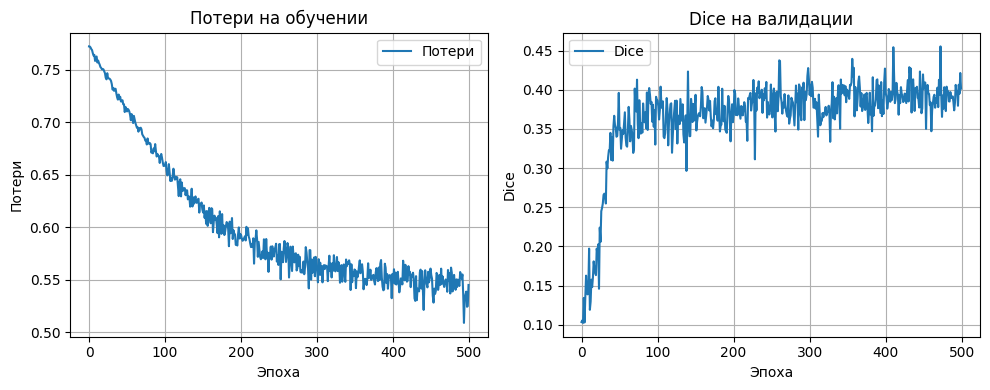

In [4]:
import matplotlib.pyplot as plt

num_epochs = 500
best_dice = 0.0
train_losses = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    dice_metric.reset()
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            val_outputs = model(val_inputs)
            val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)
            dice_metric(y_pred=val_outputs, y=val_labels)

        mean_dice = dice_metric.aggregate().item()
        val_dices.append(mean_dice)

    print(f"Эпоха {epoch + 1}/{num_epochs} | Потери: {epoch_loss:.4f} | Dice: {mean_dice:.4f}")

    # Сохраняем лучшую модель
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Сохранена новая лучшая модель (Dice: {best_dice:.4f})")

# Визуализация графиков
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Потери")
plt.xlabel("Эпоха")
plt.ylabel("Потери")
plt.title("Потери на обучении")
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_dices, label="Dice")
plt.xlabel("Эпоха")
plt.ylabel("Dice")
plt.title("Dice на валидации")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ToTensord(keys=["image", "label"]),
])


In [16]:
import os

# Define the base path for the dataset
base_path = r"C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData"

# Create the base directory if it doesn't exist
os.makedirs(base_path, exist_ok=True)

# Create folders BraTS20_Training_001 to BraTS20_Training_369
for i in range(1, 370):
    folder_name = f"BraTS20_Training_{i:03d}"
    folder_path = os.path.join(base_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created folder: {folder_path}")

print("Directory tree creation completed.")

Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_001
Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_002
Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_003
Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_004
Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData\BraTS20_Training_005
Created folder: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats

Initial RAM usage: 25.9%
Эпоха 1/100 | Потери: 0.8220 | Dice: 0.0290 | LR: 0.000100 | RAM: 30.0%
✅ Сохранена новая лучшая модель (Dice: 0.0290)
Эпоха 2/100 | Потери: 0.7330 | Dice: 0.0444 | LR: 0.000100 | RAM: 30.6%
✅ Сохранена новая лучшая модель (Dice: 0.0444)
Эпоха 3/100 | Потери: 0.6531 | Dice: 0.1212 | LR: 0.000100 | RAM: 30.6%
✅ Сохранена новая лучшая модель (Dice: 0.1212)
Эпоха 4/100 | Потери: 0.6143 | Dice: 0.2009 | LR: 0.000100 | RAM: 30.6%
✅ Сохранена новая лучшая модель (Dice: 0.2009)
Эпоха 5/100 | Потери: 0.5767 | Dice: 0.2716 | LR: 0.000100 | RAM: 31.5%
✅ Сохранена новая лучшая модель (Dice: 0.2716)
Эпоха 6/100 | Потери: 0.5595 | Dice: 0.2808 | LR: 0.000100 | RAM: 31.4%
✅ Сохранена новая лучшая модель (Dice: 0.2808)
Эпоха 7/100 | Потери: 0.5415 | Dice: 0.2506 | LR: 0.000100 | RAM: 31.9%
Эпоха 8/100 | Потери: 0.5239 | Dice: 0.3121 | LR: 0.000100 | RAM: 33.0%
✅ Сохранена новая лучшая модель (Dice: 0.3121)
Эпоха 9/100 | Потери: 0.5152 | Dice: 0.3674 | LR: 0.000100 | RAM: 32.6

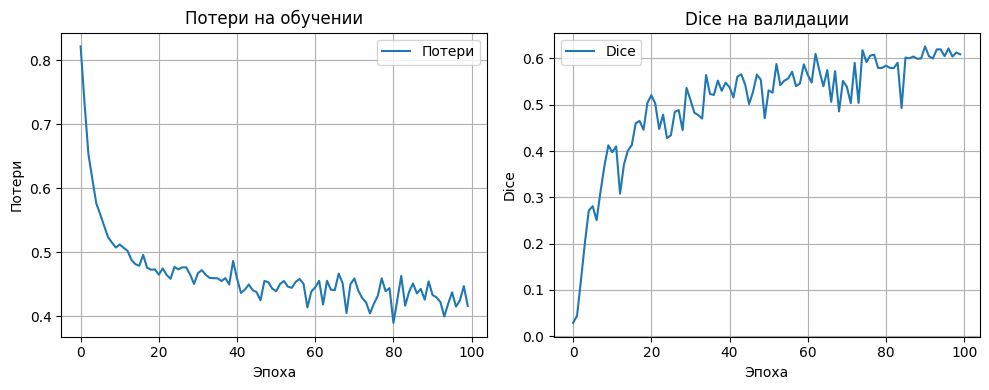

In [18]:
import os
import torch
import monai
from monai.data import Dataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, RandScaleIntensityd,
    RandShiftIntensityd, RandSpatialCropd, ToTensord, MapTransform
)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import psutil

# Print initial memory usage
print(f"Initial RAM usage: {psutil.virtual_memory().percent}%")

# Путь к датасету
data_dir = r'C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Папка {data_dir} не найдена.")

# Подготовка списка данных
def prepare_data(data_dir):
    subject_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    data_list = []
    for subject_dir in subject_dirs:
        subject_path = os.path.join(data_dir, subject_dir)
        subject_data = {
            'flair': os.path.join(subject_path, f'{subject_dir}_flair.nii'),
            't1': os.path.join(subject_path, f'{subject_dir}_t1.nii'),
            't1ce': os.path.join(subject_path, f'{subject_dir}_t1ce.nii'),
            't2': os.path.join(subject_path, f'{subject_dir}_t2.nii'),
            'label': os.path.join(subject_path, f'{subject_dir}_seg.nii'),
        }
        if all(os.path.exists(path) for path in subject_data.values()):
            data_list.append(subject_data)
    return data_list

data_list = prepare_data(data_dir)
train_subjects, val_subjects = train_test_split(data_list, test_size=0.2, random_state=42)

# Пользовательские трансформации
class ConcatImages(MapTransform):
    def __init__(self, keys, output_key):
        super().__init__(keys)
        self.output_key = output_key
    def __call__(self, data):
        d = dict(data)
        images = [d[key] for key in self.keys]
        concatenated = torch.cat(images, dim=0)
        d[self.output_key] = concatenated
        return d

class RemapLabels(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.label_map = {0: 0, 1: 1, 2: 2, 4: 3}
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = d[key]
            new_label = torch.zeros_like(label)
            for k, v in self.label_map.items():
                new_label[label == k] = v
            d[key] = new_label
        return d

# Трансформации для 3D
train_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'label']),
    EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'label']),
    Orientationd(keys=['flair', 't1', 't1ce', 't2', 'label'], axcodes='RAS'),
    Spacingd(keys=['flair', 't1', 't1ce', 't2', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    NormalizeIntensityd(keys=['flair', 't1', 't1ce', 't2'], nonzero=True),
    ConcatImages(keys=['flair', 't1', 't1ce', 't2'], output_key='image'),
    RemapLabels(keys=['label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=(96, 96, 96), random_size=False),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
    RandRotate90d(keys=['image', 'label'], prob=0.5, spatial_axes=(0, 1)),
    RandScaleIntensityd(keys='image', factors=0.1, prob=0.5),
    RandShiftIntensityd(keys='image', offsets=0.1, prob=0.5),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'label']),
    EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'label']),
    Orientationd(keys=['flair', 't1', 't1ce', 't2', 'label'], axcodes='RAS'),
    Spacingd(keys=['flair', 't1', 't1ce', 't2', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    NormalizeIntensityd(keys=['flair', 't1', 't1ce', 't2'], nonzero=True),
    ConcatImages(keys=['flair', 't1', 't1ce', 't2'], output_key='image'),
    RemapLabels(keys=['label']),
    ToTensord(keys=['image', 'label']),
])

# Датасеты и загрузчики
train_ds = Dataset(data=train_subjects, transform=train_transforms)
val_ds = Dataset(data=val_subjects, transform=val_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

# Модель и устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Оптимизация и метрики
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
dice_metric = DiceMetric(include_background=False, reduction='mean')

# Обучение с ранней остановкой
num_epochs = 100
best_dice = 0.0
patience = 20
no_improve_epochs = 0
train_losses = []
val_dices = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        for val_data in val_loader:
            val_images = val_data['image'].to(device)
            val_labels = val_data['label'].to(device)
            predictions = sliding_window_inference(val_images, (96, 96, 96), 4, model)
            pred_labels = torch.argmax(predictions, dim=1, keepdim=True)
            dice_metric(y_pred=pred_labels, y=val_labels)
        mean_dice = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dices.append(mean_dice)

    # Manual learning rate logging
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Эпоха {epoch+1}/{num_epochs} | Потери: {epoch_loss:.4f} | Dice: {mean_dice:.4f} | LR: {current_lr:.6f} | RAM: {psutil.virtual_memory().percent}%')
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save(model.state_dict(), 'best_model_3d.pth')
        print(f'✅ Сохранена новая лучшая модель (Dice: {best_dice:.4f})')
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # Step scheduler and log if learning rate changes
    prev_lr = current_lr
    scheduler.step(mean_dice)
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr < prev_lr:
        print(f'Learning rate reduced to {current_lr:.6f}')

    if no_improve_epochs >= patience:
        print(f'Ранняя остановка на эпохе {epoch+1}')
        break

# Визуализация
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Потери')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери на обучении')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Dice')
plt.xlabel('Эпоха')
plt.ylabel('Dice')
plt.title('Dice на валидации')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
!pip install monai==1.3.0

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------------- -------- 1.0/1.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 5.3 MB/s eta 0:00:00
  Attempting uninstall: monai
    Found existing installation: monai 1.4.0
    Uninstalling monai-1.4.0:
      Successfully uninstalled monai-1.4.0


In [40]:
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Path to dataset:", dataset_path)

Path to dataset: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1


In [41]:
import os
data_dir = r'C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1\BraTS2020_TrainingData\MICCAI_BraTS2020_TrainingData'
print("Directory exists:", os.path.exists(data_dir))
print("Directory contents:", os.listdir(data_dir) if os.path.exists(data_dir) else "Directory not found")

Directory exists: True
Directory contents: ['BraTS20_Training_001', 'BraTS20_Training_002', 'BraTS20_Training_003', 'BraTS20_Training_004', 'BraTS20_Training_005', 'BraTS20_Training_006', 'BraTS20_Training_007', 'BraTS20_Training_008', 'BraTS20_Training_009', 'BraTS20_Training_010', 'BraTS20_Training_011', 'BraTS20_Training_012', 'BraTS20_Training_013', 'BraTS20_Training_014', 'BraTS20_Training_015', 'BraTS20_Training_016', 'BraTS20_Training_017', 'BraTS20_Training_018', 'BraTS20_Training_019', 'BraTS20_Training_020', 'BraTS20_Training_021', 'BraTS20_Training_022', 'BraTS20_Training_023', 'BraTS20_Training_024', 'BraTS20_Training_025', 'BraTS20_Training_026', 'BraTS20_Training_027', 'BraTS20_Training_028', 'BraTS20_Training_029', 'BraTS20_Training_030', 'BraTS20_Training_031', 'BraTS20_Training_032', 'BraTS20_Training_033', 'BraTS20_Training_034', 'BraTS20_Training_035', 'BraTS20_Training_036', 'BraTS20_Training_037', 'BraTS20_Training_038', 'BraTS20_Training_039', 'BraTS20_Training_04

In [42]:
import kagglehub
import shutil
cache_dir = r'C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation'
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print("Cache cleared.")
dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Downloaded dataset to:", dataset_path)

Cache cleared.


100%|██████████| 4.16G/4.16G [06:21<00:00, 11.7MB/s]

Extracting files...


Downloaded dataset to: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1


In [43]:
test_subject = os.path.join(data_dir, 'BraTS20_Training_001')
print("Subject directory exists:", os.path.exists(test_subject))
if os.path.exists(test_subject):
    print("Files in BraTS20_Training_001:", os.listdir(test_subject))

Subject directory exists: True
Files in BraTS20_Training_001: ['BraTS20_Training_001_flair.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t2.nii']


Initial RAM usage: 45.6%
PyTorch version: 2.7.0+cu118
MONAI version: 1.4.0
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 SUPER
Dataset downloaded to: C:\Users\ankor\.cache\kagglehub\datasets\awsaf49\brats20-dataset-training-validation\versions\1
Found 369 subject directories.
Skipping BraTS20_Training_355: missing files ['label']
Found 368 valid subjects.
Verifying NIfTI metadata...
flair: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t1: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t1ce: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t2: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
label: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
flair: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t1: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t1ce: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
t2: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
label: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.0)
flair: shape = (240, 240, 155), pixdim = (1.0, 1.0, 1.

Loading dataset: 100%|██████████| 37/37 [00:23<00:00,  1.60it/s]


Epoch 1/150 | Loss: 0.9625 | Dice: 0.0404 | WT Dice: 0.0683 | TC Dice: 0.0228 | ET Dice: nan | LR: 0.000100 | RAM: 95.8%
✅ Saved new best model (Dice: 0.0404)
Epoch 2/150 | Loss: 0.9582 | Dice: 0.0512 | WT Dice: 0.0623 | TC Dice: 0.0203 | ET Dice: nan | LR: 0.000100 | RAM: 96.2%
✅ Saved new best model (Dice: 0.0512)
Epoch 3/150 | Loss: 0.9480 | Dice: 0.0484 | WT Dice: 0.0732 | TC Dice: 0.0240 | ET Dice: nan | LR: 0.000100 | RAM: 95.5%
Epoch 4/150 | Loss: 0.9399 | Dice: 0.0528 | WT Dice: 0.0700 | TC Dice: 0.0234 | ET Dice: nan | LR: 0.000100 | RAM: 95.9%
✅ Saved new best model (Dice: 0.0528)
Epoch 5/150 | Loss: 0.9416 | Dice: 0.0598 | WT Dice: 0.0662 | TC Dice: 0.0227 | ET Dice: nan | LR: 0.000100 | RAM: 95.8%
✅ Saved new best model (Dice: 0.0598)
Epoch 6/150 | Loss: 0.9232 | Dice: 0.0782 | WT Dice: 0.0450 | TC Dice: 0.0157 | ET Dice: nan | LR: 0.000100 | RAM: 94.3%
✅ Saved new best model (Dice: 0.0782)
Epoch 7/150 | Loss: 0.9260 | Dice: 0.0756 | WT Dice: 0.0530 | TC Dice: 0.0142 | ET D

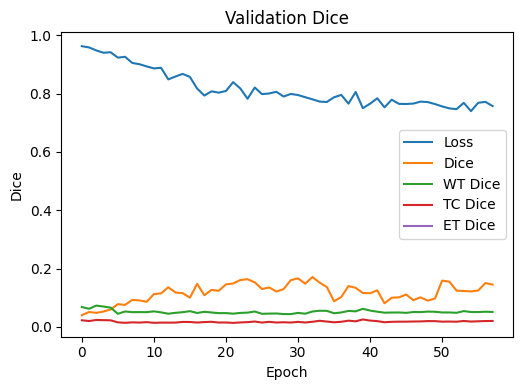

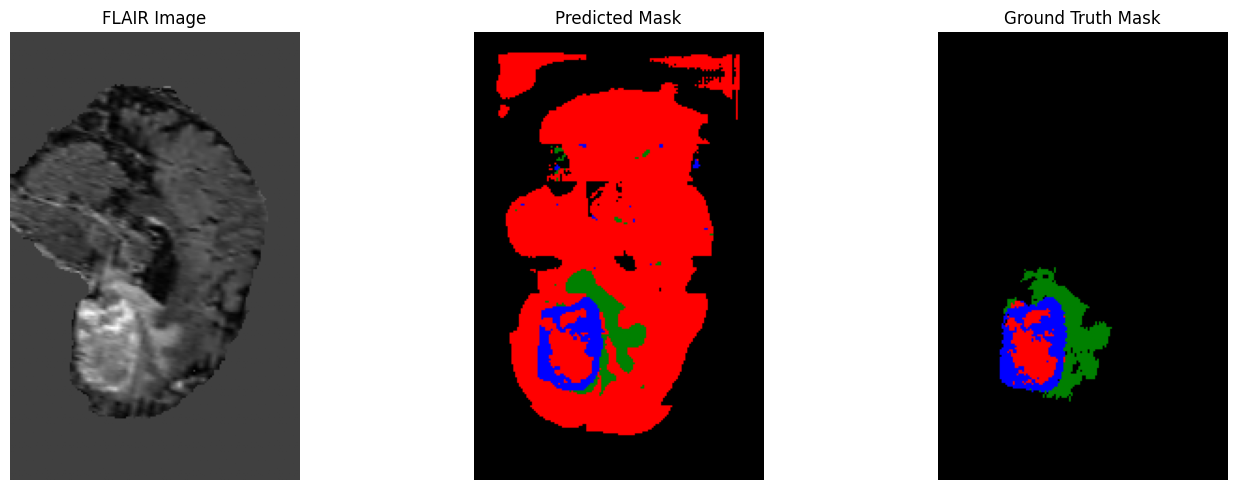

In [46]:
import os
import torch
import monai
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Orientationd, Spacingd,
    NormalizeIntensityd, RandFlipd, RandRotate90d, RandScaleIntensityd,
    RandShiftIntensityd, RandSpatialCropd, Rand3DElasticd, ToTensord, MapTransform
)
from monai.networks.nets import AttentionUnet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import psutil
from torch.amp import autocast, GradScaler
import nibabel as nib
import kagglehub

# Проверка начального использования памяти
print(f"Initial RAM usage: {psutil.virtual_memory().percent}%")

# Проверка версий библиотек
print("PyTorch version:", torch.__version__)
print("MONAI version:", monai.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

# Загрузка датасета
try:
    dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
    print("Dataset downloaded to:", dataset_path)
except Exception as e:
    print(f"Failed to download dataset: {e}")
    exit(1)

# Путь к датасету
data_dir = os.path.join(dataset_path, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
if not os.path.exists(data_dir):
    print(f"Directory {data_dir} not found. Available directories in {dataset_path}:")
    print(os.listdir(dataset_path))
    exit(1)

# Подготовка списка данных
def prepare_data(data_dir):
    """
    Подготовка списка словарей с путями к файлам модальностей и маскам сегментации.

    Args:
        data_dir (str): Путь к директории с данными BraTS2020 (MICCAI_BraTS2020_TrainingData).

    Returns:
        list: Список словарей, каждый из которых содержит пути к файлам flair, t1, t1ce, t2 и label.
    """
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist.")
    
    subject_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d.startswith('BraTS20_Training_')]
    print(f"Found {len(subject_dirs)} subject directories.")
    
    if not subject_dirs:
        print(f"No directories starting with 'BraTS20_Training_' found in {data_dir}.")
        print(f"Directory contents: {os.listdir(data_dir)}")
    
    data_list = []
    
    for subject_dir in sorted(subject_dirs):
        subject_id = subject_dir
        subject_path = os.path.join(data_dir, subject_id)
        
        subject_data = {
            'flair': os.path.join(subject_path, f'{subject_id}_flair.nii'),
            't1': os.path.join(subject_path, f'{subject_id}_t1.nii'),
            't1ce': os.path.join(subject_path, f'{subject_id}_t1ce.nii'),
            't2': os.path.join(subject_path, f'{subject_id}_t2.nii'),
            'label': os.path.join(subject_path, f'{subject_id}_seg.nii')
        }
        
        if all(os.path.exists(path) for path in subject_data.values()):
            data_list.append(subject_data)
        else:
            missing_files = [key for key, path in subject_data.items() if not os.path.exists(path)]
            print(f"Skipping {subject_id}: missing files {missing_files}")
    
    print(f"Found {len(data_list)} valid subjects.")
    return data_list

# Проверка метаданных NIfTI
def verify_nifti_metadata(data_list):
    print("Verifying NIfTI metadata...")
    if not data_list:
        print("No data to verify (empty data_list).")
        return
    for data in data_list[:5]:
        for key, path in data.items():
            try:
                img = nib.load(path)
                pixdim = img.header.get_zooms()
                print(f"{key}: shape = {img.shape}, pixdim = {pixdim}")
            except Exception as e:
                print(f"Error in {path}: {e}")
    print("Metadata verification complete.")

# Подготовка данных
data_list = prepare_data(data_dir)
verify_nifti_metadata(data_list)

# Проверка, что data_list не пуст
if len(data_list) == 0:
    raise ValueError("No valid subjects found in the dataset. Please check the dataset directory and ensure all required files are present.")

# Разделение на тренировочную и валидационную выборки
train_subjects, val_subjects = train_test_split(data_list, test_size=0.2, random_state=42)
print(f"Training subjects: {len(train_subjects)}")
print(f"Validation subjects: {len(val_subjects)}")

# Пользовательские трансформации
class ConcatImages(MapTransform):
    def __init__(self, keys, output_key):
        super().__init__(keys)
        self.output_key = output_key
    def __call__(self, data):
        d = dict(data)
        images = [d[key] for key in self.keys]
        concatenated = torch.cat(images, dim=0)
        d[self.output_key] = concatenated
        return d

class RemapLabels(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)
        self.label_map = {0: 0, 1: 1, 2: 2, 4: 3}
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            label = d[key]
            new_label = torch.zeros_like(label)
            for k, v in self.label_map.items():
                new_label[label == k] = v
            d[key] = new_label
        return d

# Пайплайны трансформаций
train_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'label'], ensure_channel_first=False, image_only=False),
    EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'label']),
    Orientationd(keys=['flair', 't1', 't1ce', 't2', 'label'], axcodes='RAS'),
    Spacingd(keys=['flair', 't1', 't1ce', 't2', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    NormalizeIntensityd(keys=['flair', 't1', 't1ce', 't2'], nonzero=True),
    ConcatImages(keys=['flair', 't1', 't1ce', 't2'], output_key='image'),
    RemapLabels(keys=['label']),
    RandSpatialCropd(keys=['image', 'label'], roi_size=(80, 80, 80), random_size=False),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=0),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=1),
    RandFlipd(keys=['image', 'label'], prob=0.5, spatial_axis=2),
    RandRotate90d(keys=['image', 'label'], prob=0.5, spatial_axes=(0, 1)),
    RandScaleIntensityd(keys='image', factors=0.1, prob=0.5),
    RandShiftIntensityd(keys='image', offsets=0.1, prob=0.5),
    Rand3DElasticd(keys=['image', 'label'], prob=0.3, sigma_range=(1, 2), magnitude_range=(100, 200), spatial_size=(80, 80, 80), mode=('bilinear', 'nearest')),
    ToTensord(keys=['image', 'label']),
])

val_transforms = Compose([
    LoadImaged(keys=['flair', 't1', 't1ce', 't2', 'label'], ensure_channel_first=False, image_only=False),
    EnsureChannelFirstd(keys=['flair', 't1', 't1ce', 't2', 'label']),
    Orientationd(keys=['flair', 't1', 't1ce', 't2', 'label'], axcodes='RAS'),
    Spacingd(keys=['flair', 't1', 't1ce', 't2', 'label'], pixdim=(1.0, 1.0, 1.0), mode=('bilinear', 'bilinear', 'bilinear', 'bilinear', 'nearest')),
    NormalizeIntensityd(keys=['flair', 't1', 't1ce', 't2'], nonzero=True),
    ConcatImages(keys=['flair', 't1', 't1ce', 't2'], output_key='image'),
    RemapLabels(keys=['label']),
    ToTensord(keys=['image', 'label']),
])

# Наборы данных и загрузчики
train_ds = CacheDataset(data=train_subjects, transform=train_transforms, cache_rate=0.5, num_workers=0)
val_ds = CacheDataset(data=val_subjects, transform=val_transforms, cache_rate=0.5, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)

# Модель и устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUnet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
).to(device)

# Оптимизация и метрики
loss_function = DiceLoss(to_onehot_y=True, softmax=True, weight=torch.tensor([0.1, 1.0, 1.0, 2.0]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
dice_metric = DiceMetric(include_background=False, reduction='mean')
scaler = GradScaler('cuda')

# Функция для вычисления Dice-метрик BraTS
def compute_brats_dice(prediction, label):
    wt_pred = prediction > 0
    wt_true = label > 0
    tc_pred = (prediction == 1) | (prediction == 3)
    tc_true = (label == 1) | (label == 3)
    et_pred = prediction == 3
    et_true = label == 3
    wt_dice = dice_metric(y_pred=wt_pred.unsqueeze(0).float(), y=wt_true.unsqueeze(0).float()).item()
    tc_dice = dice_metric(y_pred=tc_pred.unsqueeze(0).float(), y=tc_true.unsqueeze(0).float()).item()
    et_dice = dice_metric(y_pred=et_pred.unsqueeze(0).float(), y=et_true.unsqueeze(0).float()).item()
    return wt_dice, tc_dice, et_dice

# Обучение с ранней остановкой
num_epochs = 150
best_dice = 0.0
patience = 25
no_improve_epochs = 0
train_losses = []
val_dices = []
wt_dices, tc_dices, et_dices = [], [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(images)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        epoch_wt_dice, epoch_tc_dice, epoch_et_dice = 0.0, 0.0, 0.0
        for val_data in val_loader:
            val_images = val_data['image'].to(device)
            val_labels = val_data['label'].to(device)
            with autocast('cuda'):
                predictions = sliding_window_inference(val_images, (80, 80, 80), 4, model)
            pred_labels = torch.argmax(predictions, dim=1, keepdim=True)
            dice_metric(y_pred=pred_labels, y=val_labels)
            wt_dice, tc_dice, et_dice = compute_brats_dice(pred_labels[0], val_labels[0])
            epoch_wt_dice += wt_dice
            epoch_tc_dice += tc_dice
            epoch_et_dice += et_dice
        mean_dice = dice_metric.aggregate().item()
        dice_metric.reset()
        val_dices.append(mean_dice)
        wt_dices.append(epoch_wt_dice / len(val_loader))
        tc_dices.append(epoch_tc_dice / len(val_loader))
        et_dices.append(epoch_et_dice / len(val_loader))

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Dice: {mean_dice:.4f} | WT Dice: {wt_dices[-1]:.4f} | TC Dice: {tc_dices[-1]:.4f} | ET Dice: {et_dices[-1]:.4f} | LR: {current_lr:.6f} | RAM: {psutil.virtual_memory().percent}%')
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save(model.state_dict(), 'best_model_3d.pth')
        print(f'✅ Saved new best model (Dice: {best_dice:.4f})')
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    prev_lr = current_lr
    scheduler.step(mean_dice)
    current_lr = optimizer.param_groups[0]['lr']
    if current_lr < prev_lr:
        print(f'Learning rate reduced to {current_lr:.6f}')

    if no_improve_epochs >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Графики результатов обучения
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 1)
plt.plot(val_dices, label='Dice')
plt.plot(wt_dices, label='WT Dice')
plt.plot(tc_dices, label='TC Dice')
plt.plot(et_dices, label='ET Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Validation Dice')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Визуализация сегментации
model.eval()
with torch.no_grad():
    idx = torch.randint(0, len(val_ds), (1,)).item()
    val_sample = val_ds[idx]
    val_images = val_sample['image'].unsqueeze(0).to(device)
    val_labels = val_sample['label'].unsqueeze(0).to(device)
    with autocast('cuda'):
        predictions = sliding_window_inference(val_images, (80, 80, 80), 4, model)
    pred_labels = torch.argmax(predictions, dim=1).cpu().numpy()
    val_images = val_images.cpu().numpy()
    val_labels = val_labels.cpu().numpy()
    slice_idx = val_images.shape[2] // 2
    flair = val_images[0, 0, slice_idx, :, :]
    mask_pred = pred_labels[0, slice_idx, :, :]
    mask_gt = val_labels[0, 0, slice_idx, :, :]
    cmap = ListedColormap(['black', 'red', 'green', 'blue'])
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('FLAIR Image')
    axes[1].imshow(mask_pred, cmap=cmap, vmin=0, vmax=3)
    axes[1].set_title('Predicted Mask')
    axes[2].imshow(mask_gt, cmap=cmap, vmin=0, vmax=3)
    axes[2].set_title('Ground Truth Mask')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm

# --- Функции паддинга и crop ---
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        if rem == 0:
            pad.extend([0, 0])
        else:
            pad.extend([0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# --- Dataset ---
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True):
        self.patient_dirs = patient_dirs
        self.has_seg = has_seg

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"*{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = np.stack(images, axis=0)  # (4, H, W, D)
        image = torch.from_numpy(image)
        image = pad_to_multiple(image, 16)
        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"*{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return image, seg.long()
        else:
            return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1
        new[mask == 2] = 2
        new[mask == 4] = 3
        return new

# --- Attention Residual Block ---
class ResidualBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.proj = nn.Conv3d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        r = self.proj(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(r + out)

class AttentionBlock3D(nn.Module):
    def __init__(self, x_ch, g_ch, inter_ch):
        super().__init__()
        self.theta = nn.Conv3d(x_ch, inter_ch, 1)
        self.phi = nn.Conv3d(g_ch, inter_ch, 1)
        self.psi = nn.Conv3d(inter_ch, 1, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, g):
        t = self.theta(x)
        p = self.phi(g)
        if t.shape != p.shape:
            t = center_crop_to(t, p)
            p = center_crop_to(p, t)
        s = F.relu(t + p, inplace=True)
        a = self.sigmoid(self.psi(s))
        if a.shape != x.shape:
            a = center_crop_to(a, x)
            x = center_crop_to(x, a)
        return x * a

class AResUNet3D(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, base=8):  # base=8 для экономии памяти
        super().__init__()
        self.enc1 = ResidualBlock3D(in_ch, base)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock3D(base, base*2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ResidualBlock3D(base*2, base*4)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = ResidualBlock3D(base*4, base*8)
        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionBlock3D(base*4, base*4, base*2)
        self.dec3 = ResidualBlock3D(base*8, base*4)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionBlock3D(base*2, base*2, base)
        self.dec2 = ResidualBlock3D(base*4, base*2)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, stride=2)
        self.att1 = AttentionBlock3D(base, base, base//2)
        self.dec1 = ResidualBlock3D(base*2, base)
        self.outc = nn.Conv3d(base, out_ch, 1)
    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b)
        if u3.shape[2:] != c3.shape[2:]:
            u3 = center_crop_to(u3, c3)
            c3 = center_crop_to(c3, u3)
        a3 = self.att3(c3, u3)
        d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3)
        if u2.shape[2:] != c2.shape[2:]:
            u2 = center_crop_to(u2, c2)
            c2 = center_crop_to(c2, u2)
        a2 = self.att2(c2, u2)
        d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2)
        if u1.shape[2:] != c1.shape[2:]:
            u1 = center_crop_to(u1, c1)
            c1 = center_crop_to(c1, u1)
        a1 = self.att1(c1, u1)
        d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.outc(d1)

# --- Dice Loss (без фона) ---
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

def dice_per_class(pred, target):
    dices = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        dices.append(dice)
    return dices

def accuracy_per_class(pred, target):
    accs = []
    for c in range(1, 4):
        mask = (target == c)
        if np.sum(mask) == 0:
            accs.append(np.nan)
        else:
            accs.append(np.mean(pred[mask] == c))
    return accs

# --- Пути ---
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
VAL_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData"
OUTPUT_DIR = "predictions_3d"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Данные ---
train_dirs = glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*"))
train_dirs, val_dirs_train = train_test_split(train_dirs, test_size=0.2, random_state=42)
train_dataset = BraTS3DDataset(train_dirs, has_seg=True)
val_dataset = BraTS3DDataset(val_dirs_train, has_seg=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# --- Проверка загрузки первого примера ---
print("Пробую загрузить первый пример из train_dataset...")
img, mask = train_dataset[0]
print("Размер изображения:", img.shape)
print("Размер маски:", mask.shape)

# --- Модель, лоссы, оптимизатор ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используется устройство:", device)
model = AResUNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0, 1.0, 1.5]).to(device))

# --- Обучение ---
num_epochs = 50  # увеличьте для реального обучения
max_prints = 500
print_count = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    print(f"--- Эпоха {epoch+1}/{num_epochs} ---")
    for i, (images, masks) in enumerate(tqdm(train_loader, desc=f"Обучение (эпоха {epoch+1})", ncols=100)):
        if print_count < max_prints:
            print(f"Batch {i+1}/{len(train_loader)} | images.shape: {images.shape} | masks.shape: {masks.shape}")
            print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
            print_count += 1
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= max(1, len(train_loader))

    # --- Валидация ---
    model.eval()
    val_loss = 0
    dices, accs = [], []
    for i, (images, masks) in enumerate(tqdm(val_loader, desc=f"Валидация (эпоха {epoch+1})", ncols=100)):
        if print_count < max_prints:
            print(f"[VAL] Batch {i+1}/{len(val_loader)} | images.shape: {images.shape} | masks.shape: {masks.shape}")
            print_count += 1
        images = images.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices.append(dice_per_class(pred, true))
            accs.append(accuracy_per_class(pred, true))
    val_loss /= max(1, len(val_loader))
    dices = np.array(dices)
    accs = np.array(accs)
    print(f"Эпоха {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Dice (1,2,3): {np.nanmean(dices,0)}")
    print(f"Val Acc (1,2,3): {np.nanmean(accs,0)}")

# --- Визуализация 2D и 3D ---
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    tumor_area = np.sum(true_mask > 0, axis=(1,2))
    slice_idx = np.argmax(tumor_area)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image[0, slice_idx], cmap='gray')
    plt.title('FLAIR')
    plt.subplot(1,3,2)
    plt.imshow(true_mask[slice_idx], cmap='jet', vmin=0, vmax=3)
    plt.title('Истинная маска')
    plt.subplot(1,3,3)
    plt.imshow(pred_mask[slice_idx], cmap='jet', vmin=0, vmax=3)
    plt.title('Предсказанная маска')
    plt.savefig(f"{out_prefix}_2d.png")
    plt.show()

    def plot_3d(mask, title, fname):
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')
        for c, color, name in zip([1,2,3], ['yellow','green','red'], ['NCR/NET','ED','ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                mesh = Poly3DCollection(verts[faces], alpha=0.7, label=name)
                mesh.set_facecolor(color)
                ax.add_collection3d(mesh)
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend()
        plt.savefig(fname)
        plt.show()
    plot_3d(pred_mask, "3D предсказанная маска", f"{out_prefix}_3d_pred.png")
    plot_3d(true_mask, "3D истинная маска", f"{out_prefix}_3d_true.png")

# --- Визуализация на одном из пациентов ---
images, masks = train_dataset[0]
model.eval()
with torch.no_grad():
    pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
visualize_2d3d(images.numpy(), masks.numpy(), pred, "train_example")

print("Готово! Модель обучена, метрики и визуализации сохранены и показаны.")

Пробую загрузить первый пример из train_dataset...
Размер изображения: torch.Size([4, 240, 240, 160])
Размер маски: torch.Size([240, 240, 160])
Используется устройство: cuda
--- Эпоха 1/50 ---


Обучение (эпоха 1):   0%|                                                   | 0/295 [00:00<?, ?it/s]

Batch 1/295 | images.shape: torch.Size([1, 4, 240, 240, 160]) | masks.shape: torch.Size([1, 240, 240, 160])
GPU memory allocated: 3.91 GB


Skipping C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355 due to missing files


Валидация (эпоха 1): 100%|██████████████████████████████████████████| 74/74 [00:41<00:00,  1.78it/s]


Эпоха 1/50:
  Train Loss: 0.7172
  Val Loss: 0.5351
  Dice (NCR/NET, ED, ET): 0.2175, 0.4818, 0.4574
  Accuracy (NCR/NET, ED, ET): 0.2873, 0.4407, 0.5037


Валидация (эпоха 2): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.05it/s]


Эпоха 2/50:
  Train Loss: 0.4452
  Val Loss: 0.4852
  Dice (NCR/NET, ED, ET): 0.1842, 0.5662, 0.5304
  Accuracy (NCR/NET, ED, ET): 0.1753, 0.6449, 0.5975


Валидация (эпоха 3): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.05it/s]


Эпоха 3/50:
  Train Loss: 0.4110
  Val Loss: 0.5218
  Dice (NCR/NET, ED, ET): 0.2438, 0.5543, 0.4145
  Accuracy (NCR/NET, ED, ET): 0.3279, 0.5721, 0.3435


Валидация (эпоха 4): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 4/50:
  Train Loss: 0.3839
  Val Loss: 0.4671
  Dice (NCR/NET, ED, ET): 0.3158, 0.5056, 0.5987
  Accuracy (NCR/NET, ED, ET): 0.5414, 0.4516, 0.6424


Валидация (эпоха 5): 100%|██████████████████████████████████████████| 74/74 [00:37<00:00,  2.00it/s]


Эпоха 5/50:
  Train Loss: 0.3668
  Val Loss: 0.5326
  Dice (NCR/NET, ED, ET): 0.1272, 0.5883, 0.4386
  Accuracy (NCR/NET, ED, ET): 0.1008, 0.7597, 0.3691


Валидация (эпоха 6): 100%|██████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 6/50:
  Train Loss: 0.3529
  Val Loss: 0.4331
  Dice (NCR/NET, ED, ET): 0.3199, 0.5952, 0.6279
  Accuracy (NCR/NET, ED, ET): 0.3298, 0.5927, 0.6845


Валидация (эпоха 7): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.00it/s]


Эпоха 7/50:
  Train Loss: 0.3392
  Val Loss: 0.4308
  Dice (NCR/NET, ED, ET): 0.3068, 0.5956, 0.6308
  Accuracy (NCR/NET, ED, ET): 0.2716, 0.6479, 0.6721


Валидация (эпоха 8): 100%|██████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 8/50:
  Train Loss: 0.3341
  Val Loss: 0.4297
  Dice (NCR/NET, ED, ET): 0.3625, 0.5902, 0.6391
  Accuracy (NCR/NET, ED, ET): 0.4431, 0.6095, 0.7124


Валидация (эпоха 9): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 9/50:
  Train Loss: 0.3249
  Val Loss: 0.4801
  Dice (NCR/NET, ED, ET): 0.3042, 0.5913, 0.5407
  Accuracy (NCR/NET, ED, ET): 0.3200, 0.6083, 0.5066


Валидация (эпоха 10): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 10/50:
  Train Loss: 0.3230
  Val Loss: 0.4214
  Dice (NCR/NET, ED, ET): 0.3368, 0.6088, 0.6340
  Accuracy (NCR/NET, ED, ET): 0.2990, 0.6268, 0.7377


Валидация (эпоха 11): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 11/50:
  Train Loss: 0.3153
  Val Loss: 0.4433
  Dice (NCR/NET, ED, ET): 0.3566, 0.5851, 0.5967
  Accuracy (NCR/NET, ED, ET): 0.6139, 0.6268, 0.6007


Валидация (эпоха 12): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 12/50:
  Train Loss: 0.3101
  Val Loss: 0.4189
  Dice (NCR/NET, ED, ET): 0.4057, 0.6284, 0.5978
  Accuracy (NCR/NET, ED, ET): 0.4517, 0.7051, 0.5878


Валидация (эпоха 13): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 13/50:
  Train Loss: 0.3069
  Val Loss: 0.3944
  Dice (NCR/NET, ED, ET): 0.3886, 0.6197, 0.6372
  Accuracy (NCR/NET, ED, ET): 0.3939, 0.6750, 0.8154


Валидация (эпоха 14): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 14/50:
  Train Loss: 0.3006
  Val Loss: 0.3686
  Dice (NCR/NET, ED, ET): 0.4328, 0.6494, 0.6457
  Accuracy (NCR/NET, ED, ET): 0.5233, 0.7084, 0.6740


Валидация (эпоха 15): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 15/50:
  Train Loss: 0.2946
  Val Loss: 0.4251
  Dice (NCR/NET, ED, ET): 0.3463, 0.6427, 0.5786
  Accuracy (NCR/NET, ED, ET): 0.3099, 0.7249, 0.5352


Валидация (эпоха 16): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


Эпоха 16/50:
  Train Loss: 0.2926
  Val Loss: 0.4349
  Dice (NCR/NET, ED, ET): 0.3658, 0.6183, 0.6080
  Accuracy (NCR/NET, ED, ET): 0.3203, 0.6783, 0.6178


Валидация (эпоха 17): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 17/50:
  Train Loss: 0.2896
  Val Loss: 0.3514
  Dice (NCR/NET, ED, ET): 0.4727, 0.6510, 0.6681
  Accuracy (NCR/NET, ED, ET): 0.5201, 0.6804, 0.7623


Валидация (эпоха 18): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 18/50:
  Train Loss: 0.2814
  Val Loss: 0.3745
  Dice (NCR/NET, ED, ET): 0.4245, 0.6602, 0.6362
  Accuracy (NCR/NET, ED, ET): 0.4750, 0.7304, 0.6293


Валидация (эпоха 19): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 19/50:
  Train Loss: 0.2811
  Val Loss: 0.4256
  Dice (NCR/NET, ED, ET): 0.3953, 0.6176, 0.6188
  Accuracy (NCR/NET, ED, ET): 0.3607, 0.6313, 0.6372


Валидация (эпоха 20): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.00it/s]


Эпоха 20/50:
  Train Loss: 0.2765
  Val Loss: 0.4426
  Dice (NCR/NET, ED, ET): 0.4090, 0.5905, 0.6035
  Accuracy (NCR/NET, ED, ET): 0.4270, 0.5541, 0.6339


Валидация (эпоха 21): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 21/50:
  Train Loss: 0.2744
  Val Loss: 0.4293
  Dice (NCR/NET, ED, ET): 0.4266, 0.6183, 0.6107
  Accuracy (NCR/NET, ED, ET): 0.4144, 0.6359, 0.6347


Валидация (эпоха 22): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 22/50:
  Train Loss: 0.2721
  Val Loss: 0.3435
  Dice (NCR/NET, ED, ET): 0.5021, 0.6611, 0.6677
  Accuracy (NCR/NET, ED, ET): 0.5190, 0.7268, 0.7111


Валидация (эпоха 23): 100%|█████████████████████████████████████████| 74/74 [00:35<00:00,  2.06it/s]


Эпоха 23/50:
  Train Loss: 0.2691
  Val Loss: 0.4666
  Dice (NCR/NET, ED, ET): 0.3758, 0.5897, 0.5842
  Accuracy (NCR/NET, ED, ET): 0.3592, 0.5693, 0.7043


Валидация (эпоха 24): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 24/50:
  Train Loss: 0.2679
  Val Loss: 0.4151
  Dice (NCR/NET, ED, ET): 0.4034, 0.6222, 0.6371
  Accuracy (NCR/NET, ED, ET): 0.3488, 0.6106, 0.7305


Валидация (эпоха 25): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 25/50:
  Train Loss: 0.2580
  Val Loss: 0.4236
  Dice (NCR/NET, ED, ET): 0.4247, 0.6286, 0.6220
  Accuracy (NCR/NET, ED, ET): 0.3907, 0.6613, 0.6712


Валидация (эпоха 26): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 26/50:
  Train Loss: 0.2619
  Val Loss: 0.3914
  Dice (NCR/NET, ED, ET): 0.4632, 0.6432, 0.6344
  Accuracy (NCR/NET, ED, ET): 0.4568, 0.7464, 0.6861


Валидация (эпоха 27): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 27/50:
  Train Loss: 0.2551
  Val Loss: 0.3923
  Dice (NCR/NET, ED, ET): 0.4641, 0.6695, 0.6151
  Accuracy (NCR/NET, ED, ET): 0.4646, 0.7476, 0.6070


Валидация (эпоха 28): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 28/50:
  Train Loss: 0.2537
  Val Loss: 0.4384
  Dice (NCR/NET, ED, ET): 0.3935, 0.6240, 0.6120
  Accuracy (NCR/NET, ED, ET): 0.3566, 0.6405, 0.6927


Валидация (эпоха 29): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 29/50:
  Train Loss: 0.2523
  Val Loss: 0.3510
  Dice (NCR/NET, ED, ET): 0.4935, 0.6441, 0.6695
  Accuracy (NCR/NET, ED, ET): 0.4987, 0.6622, 0.8081


Валидация (эпоха 30): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 30/50:
  Train Loss: 0.2521
  Val Loss: 0.3343
  Dice (NCR/NET, ED, ET): 0.5282, 0.6576, 0.6705
  Accuracy (NCR/NET, ED, ET): 0.6044, 0.6873, 0.7647


Валидация (эпоха 31): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 31/50:
  Train Loss: 0.2548
  Val Loss: 0.3437
  Dice (NCR/NET, ED, ET): 0.5142, 0.6688, 0.6739
  Accuracy (NCR/NET, ED, ET): 0.5591, 0.7166, 0.7306


Валидация (эпоха 32): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 32/50:
  Train Loss: 0.2488
  Val Loss: 0.3922
  Dice (NCR/NET, ED, ET): 0.4540, 0.6560, 0.6279
  Accuracy (NCR/NET, ED, ET): 0.4233, 0.7234, 0.6283


Валидация (эпоха 33): 100%|█████████████████████████████████████████| 74/74 [00:35<00:00,  2.08it/s]


Эпоха 33/50:
  Train Loss: 0.2455
  Val Loss: 0.4218
  Dice (NCR/NET, ED, ET): 0.4448, 0.6302, 0.6244
  Accuracy (NCR/NET, ED, ET): 0.4365, 0.6316, 0.6954


Валидация (эпоха 34): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 34/50:
  Train Loss: 0.2466
  Val Loss: 0.3909
  Dice (NCR/NET, ED, ET): 0.4702, 0.6444, 0.6326
  Accuracy (NCR/NET, ED, ET): 0.5091, 0.6666, 0.6430


Валидация (эпоха 35): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


Эпоха 35/50:
  Train Loss: 0.2382
  Val Loss: 0.3838
  Dice (NCR/NET, ED, ET): 0.4732, 0.6592, 0.6244
  Accuracy (NCR/NET, ED, ET): 0.4230, 0.7113, 0.6097


Валидация (эпоха 36): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.16it/s]


Эпоха 36/50:
  Train Loss: 0.2387
  Val Loss: 0.3893
  Dice (NCR/NET, ED, ET): 0.4751, 0.6489, 0.6312
  Accuracy (NCR/NET, ED, ET): 0.4956, 0.6889, 0.6802


Валидация (эпоха 37): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 37/50:
  Train Loss: 0.2400
  Val Loss: 0.3521
  Dice (NCR/NET, ED, ET): 0.4978, 0.6608, 0.6654
  Accuracy (NCR/NET, ED, ET): 0.4800, 0.6738, 0.7794


Валидация (эпоха 38): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  2.00it/s]


Эпоха 38/50:
  Train Loss: 0.2357
  Val Loss: 0.4277
  Dice (NCR/NET, ED, ET): 0.4665, 0.6278, 0.6259
  Accuracy (NCR/NET, ED, ET): 0.4524, 0.6178, 0.6529


Валидация (эпоха 39): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 39/50:
  Train Loss: 0.2363
  Val Loss: 0.4130
  Dice (NCR/NET, ED, ET): 0.4332, 0.6555, 0.6177
  Accuracy (NCR/NET, ED, ET): 0.3897, 0.7112, 0.6325


Валидация (эпоха 40): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.05it/s]


Эпоха 40/50:
  Train Loss: 0.2329
  Val Loss: 0.3401
  Dice (NCR/NET, ED, ET): 0.5205, 0.6755, 0.6556
  Accuracy (NCR/NET, ED, ET): 0.5634, 0.7375, 0.6516


Валидация (эпоха 41): 100%|█████████████████████████████████████████| 74/74 [00:35<00:00,  2.10it/s]


Эпоха 41/50:
  Train Loss: 0.2322
  Val Loss: 0.3756
  Dice (NCR/NET, ED, ET): 0.4592, 0.6567, 0.6197
  Accuracy (NCR/NET, ED, ET): 0.4665, 0.7816, 0.5886


Валидация (эпоха 42): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.96it/s]


Эпоха 42/50:
  Train Loss: 0.2295
  Val Loss: 0.4066
  Dice (NCR/NET, ED, ET): 0.4577, 0.6489, 0.6344
  Accuracy (NCR/NET, ED, ET): 0.4189, 0.6790, 0.6804


Валидация (эпоха 43): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 43/50:
  Train Loss: 0.2330
  Val Loss: 0.3554
  Dice (NCR/NET, ED, ET): 0.4942, 0.6650, 0.6784
  Accuracy (NCR/NET, ED, ET): 0.4519, 0.6725, 0.7241


Валидация (эпоха 44): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.97it/s]


Эпоха 44/50:
  Train Loss: 0.2259
  Val Loss: 0.4209
  Dice (NCR/NET, ED, ET): 0.4446, 0.6487, 0.6165
  Accuracy (NCR/NET, ED, ET): 0.3925, 0.6930, 0.6693


Валидация (эпоха 45): 100%|█████████████████████████████████████████| 74/74 [00:39<00:00,  1.86it/s]


Эпоха 45/50:
  Train Loss: 0.2289
  Val Loss: 0.3564
  Dice (NCR/NET, ED, ET): 0.4722, 0.6668, 0.6697
  Accuracy (NCR/NET, ED, ET): 0.4679, 0.7263, 0.7094


Валидация (эпоха 46): 100%|█████████████████████████████████████████| 74/74 [00:39<00:00,  1.89it/s]


Эпоха 46/50:
  Train Loss: 0.2260
  Val Loss: 0.4568
  Dice (NCR/NET, ED, ET): 0.4381, 0.6074, 0.6122
  Accuracy (NCR/NET, ED, ET): 0.4227, 0.5934, 0.6878


Валидация (эпоха 47): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 47/50:
  Train Loss: 0.2255
  Val Loss: 0.4277
  Dice (NCR/NET, ED, ET): 0.4288, 0.6476, 0.6090
  Accuracy (NCR/NET, ED, ET): 0.4070, 0.6776, 0.6151


Валидация (эпоха 48): 100%|█████████████████████████████████████████| 74/74 [00:39<00:00,  1.85it/s]


Эпоха 48/50:
  Train Loss: 0.2257
  Val Loss: 0.3723
  Dice (NCR/NET, ED, ET): 0.4984, 0.6470, 0.6664
  Accuracy (NCR/NET, ED, ET): 0.5020, 0.6368, 0.7363


Валидация (эпоха 49): 100%|█████████████████████████████████████████| 74/74 [00:40<00:00,  1.85it/s]


Эпоха 49/50:
  Train Loss: 0.2224
  Val Loss: 0.3553
  Dice (NCR/NET, ED, ET): 0.4998, 0.6673, 0.6758
  Accuracy (NCR/NET, ED, ET): 0.4904, 0.7045, 0.7535


Валидация (эпоха 50): 100%|█████████████████████████████████████████| 74/74 [00:40<00:00,  1.83it/s]


Эпоха 50/50:
  Train Loss: 0.2202
  Val Loss: 0.3891
  Dice (NCR/NET, ED, ET): 0.4683, 0.6484, 0.6553
  Accuracy (NCR/NET, ED, ET): 0.4927, 0.6868, 0.7119


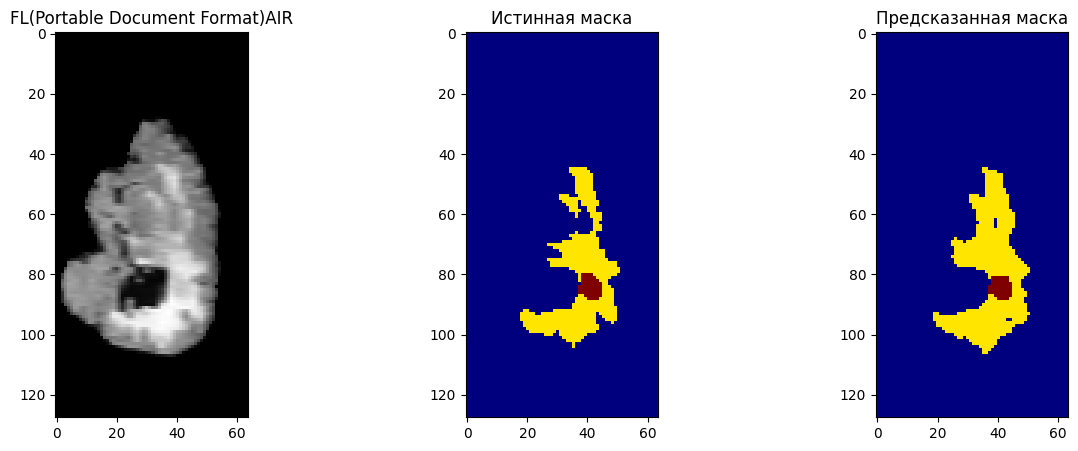

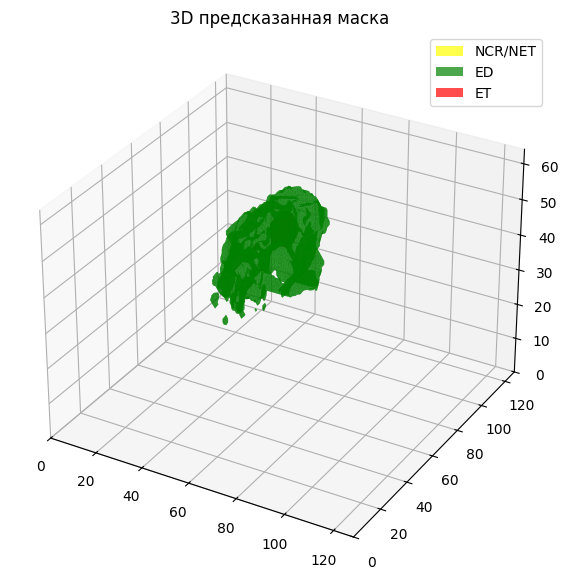

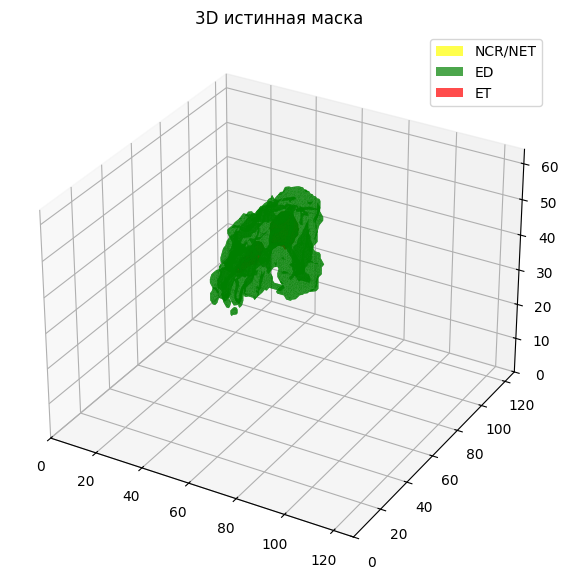

Готово! Модель обучена, метрики и визуализации сохранены и показаны.


In [5]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm

# --- Функции паддинга и crop ---
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        if rem == 0:
            pad.extend([0, 0])
        else:
            pad.extend([0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# --- Dataset ---
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True):
        self.patient_dirs = []
        for pdir in patient_dirs:
            base = os.path.basename(pdir)
            required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
            if has_seg:
                required_files.append(f"{base}_seg.nii*")
            if all(len(glob.glob(os.path.join(pdir, f))) > 0 for f in required_files):
                self.patient_dirs.append(pdir)
            else:
                print(f"Skipping {pdir} due to missing files")
        self.has_seg = has_seg

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = np.stack(images, axis=0)
        image = torch.from_numpy(image)
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)
        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return image, seg.long()
        else:
            return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1
        new[mask == 2] = 2
        new[mask == 4] = 3
        return new

# --- Attention Residual Block ---
class ResidualBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.proj = nn.Conv3d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        r = self.proj(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(r + out)

class AttentionBlock3D(nn.Module):
    def __init__(self, x_ch, g_ch, inter_ch):
        super().__init__()
        self.theta = nn.Conv3d(x_ch, inter_ch, 1)
        self.phi = nn.Conv3d(g_ch, inter_ch, 1)
        self.psi = nn.Conv3d(inter_ch, 1, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, g):
        t = self.theta(x)
        p = self.phi(g)
        if t.shape != p.shape:
            t = center_crop_to(t, p)
            p = center_crop_to(p, t)
        s = F.relu(t + p, inplace=True)
        a = self.sigmoid(self.psi(s))
        if a.shape != x.shape:
            a = center_crop_to(a, x)
            x = center_crop_to(x, a)
        return x * a

class AResUNet3D(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, base=4):
        super().__init__()
        self.enc1 = ResidualBlock3D(in_ch, base)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock3D(base, base*2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ResidualBlock3D(base*2, base*4)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = ResidualBlock3D(base*4, base*8)
        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionBlock3D(base*4, base*4, base*2)
        self.dec3 = ResidualBlock3D(base*8, base*4)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionBlock3D(base*2, base*2, base)
        self.dec2 = ResidualBlock3D(base*4, base*2)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, stride=2)
        self.att1 = AttentionBlock3D(base, base, base//2)
        self.dec1 = ResidualBlock3D(base*2, base)
        self.outc = nn.Conv3d(base, out_ch, 1)
    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b)
        if u3.shape[2:] != c3.shape[2:]:
            u3 = center_crop_to(u3, c3)
            c3 = center_crop_to(c3, u3)
        a3 = self.att3(c3, u3)
        d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3)
        if u2.shape[2:] != c2.shape[2:]:
            u2 = center_crop_to(u2, c2)
            c2 = center_crop_to(c2, u2)
        a2 = self.att2(c2, u2)
        d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2)
        if u1.shape[2:] != c1.shape[2:]:
            u1 = center_crop_to(u1, c1)
            c1 = center_crop_to(c1, u1)
        a1 = self.att1(c1, u1)
        d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.outc(d1)

# --- Dice Loss (без фона) ---
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

def dice_per_class(pred, target):
    dices = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        dices.append(dice)
    return dices

def accuracy_per_class(pred, target):
    accs = []
    for c in range(1, 4):
        mask = (target == c)
        if np.sum(mask) == 0:
            accs.append(np.nan)
        else:
            accs.append(np.mean(pred[mask] == c))
    return accs

# --- Пути ---
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
VAL_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData"
OUTPUT_DIR = "predictions_3d"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Данные ---
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs_train = train_test_split(train_dirs, test_size=0.2, random_state=42)
train_dataset = BraTS3DDataset(train_dirs, has_seg=True)
val_dataset = BraTS3DDataset(val_dirs_train, has_seg=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# --- Модель, лоссы, оптимизатор ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AResUNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.0, 1.0, 1.5]).to(device))

# --- Обучение ---
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, masks) in enumerate(tqdm(train_loader, desc=f"Обучение (эпоха {epoch+1})", ncols=100)):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= max(1, len(train_loader))

    # --- Валидация ---
    model.eval()
    val_loss = 0
    dices, accs = [], []
    for i, (images, masks) in enumerate(tqdm(val_loader, desc=f"Валидация (эпоха {epoch+1})", ncols=100)):
        images = images.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices.append(dice_per_class(pred, true))
            accs.append(accuracy_per_class(pred, true))
    val_loss /= max(1, len(val_loader))
    dices = np.nanmean(dices, axis=0)
    accs = np.nanmean(accs, axis=0)

    # --- Вывод метрик ---
    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    # --- Сохранение модели ---
    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))

# --- Визуализация 2D и 3D ---
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    tumor_area = np.sum(true_mask > 0, axis=(1,2))
    slice_idx = np.argmax(tumor_area)
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(image[0, slice_idx], cmap='gray')
    plt.title('FL(Portable Document Format)AIR')
    plt.subplot(1,3,2)
    plt.imshow(true_mask[slice_idx], cmap='jet', vmin=0, vmax=3)
    plt.title('Истинная маска')
    plt.subplot(1,3,3)
    plt.imshow(pred_mask[slice_idx], cmap='jet', vmin=0, vmax=3)
    plt.title('Предсказанная маска')
    plt.savefig(f"{out_prefix}_2d.png")
    plt.show()

    def plot_3d(mask, title, fname):
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(111, projection='3d')
        for c, color, name in zip([1,2,3], ['yellow','green','red'], ['NCR/NET','ED','ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                mesh = Poly3DCollection(verts[faces], alpha=0.7, label=name)
                mesh.set_facecolor(color)
                ax.add_collection3d(mesh)
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend()
        plt.savefig(fname)
        plt.show()
    plot_3d(pred_mask, "3D предсказанная маска", f"{out_prefix}_3d_pred.png")
    plot_3d(true_mask, "3D истинная маска", f"{out_prefix}_3d_true.png")

# --- Визуализация на одном из пациентов ---
images, masks = train_dataset[0]
model.eval()
with torch.no_grad():
    pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
visualize_2d3d(images.numpy(), masks.numpy(), pred, "train_example")

print("Готово! Модель обучена, метрики и визуализации сохранены и показаны.")

In [6]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Функции паддинга и crop ---
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        if rem == 0:
            pad.extend([0, 0])
        else:
            pad.extend([0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# --- Dataset ---
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True):
        self.patient_dirs = []
        for pdir in patient_dirs:
            base = os.path.basename(pdir)
            required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
            if has_seg:
                required_files.append(f"{base}_seg.nii*")
            if all(len(glob.glob(os.path.join(pdir, f))) > 0 for f in required_files):
                self.patient_dirs.append(pdir)
            else:
                print(f"Skipping {pdir} due to missing files")
        self.has_seg = has_seg

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = np.stack(images, axis=0)
        image = torch.from_numpy(image)
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)

            # Аугментация данных: случайные отражения
            if random.random() > 0.5:
                image = image.flip(1)  # flip X
                seg = seg.flip(0)
            if random.random() > 0.5:
                image = image.flip(2)  # flip Y
                seg = seg.flip(1)
            if random.random() > 0.5:
                image = image.flip(3)  # flip Z
                seg = seg.flip(2)

            return image, seg.long()
        else:
            return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1
        new[mask == 2] = 2
        new[mask == 4] = 3
        return new

# --- Attention Residual Block ---
class ResidualBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.proj = nn.Conv3d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x):
        r = self.proj(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(r + out)

class AttentionBlock3D(nn.Module):
    def __init__(self, x_ch, g_ch, inter_ch):
        super().__init__()
        self.theta = nn.Conv3d(x_ch, inter_ch, 1)
        self.phi = nn.Conv3d(g_ch, inter_ch, 1)
        self.psi = nn.Conv3d(inter_ch, 1, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x, g):
        t = self.theta(x)
        p = self.phi(g)
        if t.shape != p.shape:
            t = center_crop_to(t, p)
            p = center_crop_to(p, t)
        s = F.relu(t + p, inplace=True)
        a = self.sigmoid(self.psi(s))
        if a.shape != x.shape:
            a = center_crop_to(a, x)
            x = center_crop_to(x, a)
        return x * a

class AResUNet3D(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, base=4):
        super().__init__()
        self.enc1 = ResidualBlock3D(in_ch, base)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock3D(base, base*2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ResidualBlock3D(base*2, base*4)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = ResidualBlock3D(base*4, base*8)
        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionBlock3D(base*4, base*4, base*2)
        self.dec3 = ResidualBlock3D(base*8, base*4)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionBlock3D(base*2, base*2, base)
        self.dec2 = ResidualBlock3D(base*4, base*2)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, stride=2)
        self.att1 = AttentionBlock3D(base, base, base//2)
        self.dec1 = ResidualBlock3D(base*2, base)
        self.outc = nn.Conv3d(base, out_ch, 1)
    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b)
        if u3.shape[2:] != c3.shape[2:]:
            u3 = center_crop_to(u3, c3)
            c3 = center_crop_to(c3, u3)
        a3 = self.att3(c3, u3)
        d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3)
        if u2.shape[2:] != c2.shape[2:]:
            u2 = center_crop_to(u2, c2)
            c2 = center_crop_to(c2, u2)
        a2 = self.att2(c2, u2)
        d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2)
        if u1.shape[2:] != c1.shape[2:]:
            u1 = center_crop_to(u1, c1)
            c1 = center_crop_to(c1, u1)
        a1 = self.att1(c1, u1)
        d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.outc(d1)

# --- Dice Loss (без фона) ---
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

def dice_per_class(pred, target):
    dices = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        dices.append(dice)
    return dices

def accuracy_per_class(pred, target):
    accs = []
    for c in range(1, 4):
        mask = (target == c)
        if np.sum(mask) == 0:
            accs.append(np.nan)
        else:
            accs.append(np.mean(pred[mask] == c))
    return accs

# --- Пути ---
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
VAL_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData"
OUTPUT_DIR = "predictions_3d"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Данные ---
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs_train = train_test_split(train_dirs, test_size=0.2, random_state=42)
train_dataset = BraTS3DDataset(train_dirs, has_seg=True)
val_dataset = BraTS3DDataset(val_dirs_train, has_seg=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)

# --- Модель, лоссы, оптимизатор ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AResUNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=torch.tensor([0.1, 1.5, 1.0, 1.0]).to(device))  # Увеличен вес для NCR/NET
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# --- Обучение ---
num_epochs = 50
train_losses = []
val_losses = []
dices_NCR_NET = []
dices_ED = []
dices_ET = []
accs_NCR_NET = []
accs_ED = []
accs_ET = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for i, (images, masks) in enumerate(tqdm(train_loader, desc=f"Обучение (эпоха {epoch+1})", ncols=100)):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= max(1, len(train_loader))
    train_losses.append(train_loss)

    # --- Валидация ---
    model.eval()
    val_loss = 0
    dices_list = []
    accs_list = []
    for i, (images, masks) in enumerate(tqdm(val_loader, desc=f"Валидация (эпоха {epoch+1})", ncols=100)):
        images = images.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = 0.7 * dice_loss(outputs, masks) + 0.3 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices_list.append(dice_per_class(pred, true))
            accs_list.append(accuracy_per_class(pred, true))
    val_loss /= max(1, len(val_loader))
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    # --- Вывод метрик ---
    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    # --- Сохранение модели ---
    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))

    # --- Обновление скорости обучения ---
    scheduler.step(val_loss)

# --- Построение графиков метрик ---
# График потерь
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Кривая потерь')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'))
plt.close()

# График Dice-коэффициентов
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), dices_NCR_NET, label='NCR/NET')
plt.plot(range(1, num_epochs + 1), dices_ED, label='ED')
plt.plot(range(1, num_epochs + 1), dices_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Dice-коэффициент')
plt.title('Dice-коэффициенты по эпохам')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'))
plt.close()

# График точности
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), accs_NCR_NET, label='NCR/NET')
plt.plot(range(1, num_epochs + 1), accs_ED, label='ED')
plt.plot(range(1, num_epochs + 1), accs_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'))
plt.close()

# --- Визуализация 2D и 3D для пациента 369 ---
def visualize_2d3d_patient_369(image, true_mask, pred_mask, out_prefix):
    # Найти все срезы с опухолью (классы 1, 2, 3)
    tumor_slices = []
    for i in range(true_mask.shape[2]):
        if np.any(true_mask[:, :, i] > 0):
            tumor_slices.append(i)

    # Визуализация каждого среза
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title('FLAIR')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Истинная маска')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Предсказанная маска')
        plt.savefig(os.path.join(OUTPUT_DIR, f'{out_prefix}_slice_{slice_idx}.png'))
        plt.close()

    # 3D визуализация
    def plot_3d(mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                mesh = Poly3DCollection(verts[faces], alpha=0.7, label=name)
                mesh.set_facecolor(color)
                ax.add_collection3d(mesh)
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend()
        plt.savefig(os.path.join(OUTPUT_DIR, fname))
        plt.close()

    plot_3d(pred_mask, "3D предсказанная маска", f"{out_prefix}_3d_pred.png")
    plot_3d(true_mask, "3D истинная маска", f"{out_prefix}_3d_true.png")

# --- Загрузка данных пациента 369 ---
patient_369_dir = os.path.join(TRAIN_DIR, "BraTS20_Training_369")
if os.path.exists(patient_369_dir):
    dataset_369 = BraTS3DDataset([patient_369_dir], has_seg=True)
    images, masks = dataset_369[0]
    model.eval()
    with torch.no_grad():
        pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d_patient_369(images.numpy(), masks.numpy(), pred, "patient_369")
else:
    print(f"Пациент 369 не найден в {TRAIN_DIR}")

print("Готово! Модель обучена, метрики, визуализации и графики сохранены.")

Skipping C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355 due to missing files


Валидация (эпоха 1): 100%|██████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


Эпоха 1/50:
  Train Loss: 0.7547
  Val Loss: 0.6336
  Dice (NCR/NET, ED, ET): 0.0004, 0.4369, 0.2394
  Accuracy (NCR/NET, ED, ET): 0.0002, 0.7434, 0.7179


Валидация (эпоха 2): 100%|██████████████████████████████████████████| 74/74 [00:34<00:00,  2.14it/s]


Эпоха 2/50:
  Train Loss: 0.5400
  Val Loss: 0.5833
  Dice (NCR/NET, ED, ET): 0.0484, 0.5228, 0.3763
  Accuracy (NCR/NET, ED, ET): 0.0360, 0.6401, 0.3323


Валидация (эпоха 3): 100%|██████████████████████████████████████████| 74/74 [00:34<00:00,  2.17it/s]


Эпоха 3/50:
  Train Loss: 0.5004
  Val Loss: 0.6788
  Dice (NCR/NET, ED, ET): 0.0851, 0.3177, 0.3612
  Accuracy (NCR/NET, ED, ET): 0.0630, 0.2935, 0.3394


Валидация (эпоха 4): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.00it/s]


Эпоха 4/50:
  Train Loss: 0.4730
  Val Loss: 0.5371
  Dice (NCR/NET, ED, ET): 0.2771, 0.5037, 0.4299
  Accuracy (NCR/NET, ED, ET): 0.5017, 0.5624, 0.4133


Валидация (эпоха 5): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 5/50:
  Train Loss: 0.4460
  Val Loss: 0.6122
  Dice (NCR/NET, ED, ET): 0.2217, 0.4980, 0.3744
  Accuracy (NCR/NET, ED, ET): 0.2396, 0.5100, 0.3434


Валидация (эпоха 6): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 6/50:
  Train Loss: 0.4283
  Val Loss: 0.5214
  Dice (NCR/NET, ED, ET): 0.2680, 0.5327, 0.4825
  Accuracy (NCR/NET, ED, ET): 0.3762, 0.6250, 0.4877


Валидация (эпоха 7): 100%|██████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 7/50:
  Train Loss: 0.4136
  Val Loss: 0.5292
  Dice (NCR/NET, ED, ET): 0.2854, 0.5469, 0.4553
  Accuracy (NCR/NET, ED, ET): 0.5058, 0.5573, 0.4262


Валидация (эпоха 8): 100%|██████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 8/50:
  Train Loss: 0.3955
  Val Loss: 0.4856
  Dice (NCR/NET, ED, ET): 0.3246, 0.5605, 0.5137
  Accuracy (NCR/NET, ED, ET): 0.4443, 0.6284, 0.5631


Валидация (эпоха 9): 100%|██████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 9/50:
  Train Loss: 0.3906
  Val Loss: 0.5008
  Dice (NCR/NET, ED, ET): 0.3103, 0.5853, 0.5060
  Accuracy (NCR/NET, ED, ET): 0.4004, 0.6502, 0.5217


Валидация (эпоха 10): 100%|█████████████████████████████████████████| 74/74 [00:38<00:00,  1.94it/s]


Эпоха 10/50:
  Train Loss: 0.3831
  Val Loss: 0.4895
  Dice (NCR/NET, ED, ET): 0.3090, 0.5846, 0.5437
  Accuracy (NCR/NET, ED, ET): 0.3329, 0.6427, 0.5972


Валидация (эпоха 11): 100%|█████████████████████████████████████████| 74/74 [00:38<00:00,  1.95it/s]


Эпоха 11/50:
  Train Loss: 0.3706
  Val Loss: 0.4667
  Dice (NCR/NET, ED, ET): 0.3363, 0.5725, 0.5437
  Accuracy (NCR/NET, ED, ET): 0.4429, 0.6051, 0.5872


Валидация (эпоха 12): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.97it/s]


Эпоха 12/50:
  Train Loss: 0.3647
  Val Loss: 0.4871
  Dice (NCR/NET, ED, ET): 0.3384, 0.6038, 0.4720
  Accuracy (NCR/NET, ED, ET): 0.4143, 0.6851, 0.4317


Валидация (эпоха 13): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.99it/s]


Эпоха 13/50:
  Train Loss: 0.3598
  Val Loss: 0.4959
  Dice (NCR/NET, ED, ET): 0.3365, 0.5698, 0.5235
  Accuracy (NCR/NET, ED, ET): 0.3304, 0.6021, 0.5537


Валидация (эпоха 14): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.97it/s]


Эпоха 14/50:
  Train Loss: 0.3569
  Val Loss: 0.5316
  Dice (NCR/NET, ED, ET): 0.3303, 0.5343, 0.5121
  Accuracy (NCR/NET, ED, ET): 0.3649, 0.5081, 0.5428


Валидация (эпоха 15): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.16it/s]


Эпоха 15/50:
  Train Loss: 0.3497
  Val Loss: 0.4516
  Dice (NCR/NET, ED, ET): 0.3564, 0.6089, 0.5450
  Accuracy (NCR/NET, ED, ET): 0.4736, 0.6875, 0.5654


Валидация (эпоха 16): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.13it/s]


Эпоха 16/50:
  Train Loss: 0.3465
  Val Loss: 0.4423
  Dice (NCR/NET, ED, ET): 0.3783, 0.6186, 0.5252
  Accuracy (NCR/NET, ED, ET): 0.5183, 0.7010, 0.5128


Валидация (эпоха 17): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.14it/s]


Эпоха 17/50:
  Train Loss: 0.3437
  Val Loss: 0.4369
  Dice (NCR/NET, ED, ET): 0.3760, 0.6251, 0.5676
  Accuracy (NCR/NET, ED, ET): 0.4511, 0.6543, 0.6046


Валидация (эпоха 18): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 18/50:
  Train Loss: 0.3451
  Val Loss: 0.4375
  Dice (NCR/NET, ED, ET): 0.3751, 0.6113, 0.5676
  Accuracy (NCR/NET, ED, ET): 0.3709, 0.7177, 0.6183


Валидация (эпоха 19): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 19/50:
  Train Loss: 0.3424
  Val Loss: 0.4786
  Dice (NCR/NET, ED, ET): 0.3692, 0.5875, 0.5509
  Accuracy (NCR/NET, ED, ET): 0.4069, 0.5842, 0.5773


Валидация (эпоха 20): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 20/50:
  Train Loss: 0.3396
  Val Loss: 0.4372
  Dice (NCR/NET, ED, ET): 0.3663, 0.6000, 0.5728
  Accuracy (NCR/NET, ED, ET): 0.4802, 0.6796, 0.6258


Валидация (эпоха 21): 100%|█████████████████████████████████████████| 74/74 [00:35<00:00,  2.08it/s]


Эпоха 21/50:
  Train Loss: 0.3349
  Val Loss: 0.4844
  Dice (NCR/NET, ED, ET): 0.3399, 0.5857, 0.5415
  Accuracy (NCR/NET, ED, ET): 0.2944, 0.6137, 0.5588


Валидация (эпоха 22): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.00it/s]


Эпоха 22/50:
  Train Loss: 0.3325
  Val Loss: 0.4442
  Dice (NCR/NET, ED, ET): 0.3812, 0.6037, 0.5405
  Accuracy (NCR/NET, ED, ET): 0.4865, 0.6365, 0.5411


Валидация (эпоха 23): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 23/50:
  Train Loss: 0.3305
  Val Loss: 0.4926
  Dice (NCR/NET, ED, ET): 0.3569, 0.5648, 0.5451
  Accuracy (NCR/NET, ED, ET): 0.3219, 0.5609, 0.5782


Валидация (эпоха 24): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.96it/s]


Эпоха 24/50:
  Train Loss: 0.3230
  Val Loss: 0.4818
  Dice (NCR/NET, ED, ET): 0.3586, 0.5788, 0.5399
  Accuracy (NCR/NET, ED, ET): 0.3310, 0.5832, 0.6011


Валидация (эпоха 25): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 25/50:
  Train Loss: 0.3209
  Val Loss: 0.4802
  Dice (NCR/NET, ED, ET): 0.3625, 0.5755, 0.5470
  Accuracy (NCR/NET, ED, ET): 0.3556, 0.5655, 0.6004


Валидация (эпоха 26): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.14it/s]


Эпоха 26/50:
  Train Loss: 0.3189
  Val Loss: 0.4902
  Dice (NCR/NET, ED, ET): 0.3657, 0.5796, 0.5275
  Accuracy (NCR/NET, ED, ET): 0.3334, 0.5784, 0.5708


Валидация (эпоха 27): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.14it/s]


Эпоха 27/50:
  Train Loss: 0.3193
  Val Loss: 0.4119
  Dice (NCR/NET, ED, ET): 0.4084, 0.6364, 0.5695
  Accuracy (NCR/NET, ED, ET): 0.4506, 0.7271, 0.5903


Валидация (эпоха 28): 100%|█████████████████████████████████████████| 74/74 [00:33<00:00,  2.18it/s]


Эпоха 28/50:
  Train Loss: 0.3156
  Val Loss: 0.4131
  Dice (NCR/NET, ED, ET): 0.3973, 0.6330, 0.5823
  Accuracy (NCR/NET, ED, ET): 0.4176, 0.7040, 0.6694


Валидация (эпоха 29): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 29/50:
  Train Loss: 0.3136
  Val Loss: 0.4746
  Dice (NCR/NET, ED, ET): 0.3643, 0.6002, 0.5427
  Accuracy (NCR/NET, ED, ET): 0.3323, 0.6129, 0.5914


Валидация (эпоха 30): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 30/50:
  Train Loss: 0.3154
  Val Loss: 0.4506
  Dice (NCR/NET, ED, ET): 0.3965, 0.5985, 0.5725
  Accuracy (NCR/NET, ED, ET): 0.3902, 0.5927, 0.6562


Валидация (эпоха 31): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 31/50:
  Train Loss: 0.3141
  Val Loss: 0.4449
  Dice (NCR/NET, ED, ET): 0.3926, 0.6173, 0.5719
  Accuracy (NCR/NET, ED, ET): 0.3558, 0.6337, 0.6288


Валидация (эпоха 32): 100%|█████████████████████████████████████████| 74/74 [00:34<00:00,  2.12it/s]


Эпоха 32/50:
  Train Loss: 0.3123
  Val Loss: 0.4801
  Dice (NCR/NET, ED, ET): 0.3454, 0.6074, 0.5307
  Accuracy (NCR/NET, ED, ET): 0.3209, 0.6405, 0.5785


Валидация (эпоха 33): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 33/50:
  Train Loss: 0.3134
  Val Loss: 0.4443
  Dice (NCR/NET, ED, ET): 0.3964, 0.6192, 0.5591
  Accuracy (NCR/NET, ED, ET): 0.4226, 0.6771, 0.5979


Валидация (эпоха 34): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 34/50:
  Train Loss: 0.3061
  Val Loss: 0.4464
  Dice (NCR/NET, ED, ET): 0.3938, 0.6126, 0.5583
  Accuracy (NCR/NET, ED, ET): 0.4412, 0.6494, 0.5828


Валидация (эпоха 35): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Эпоха 35/50:
  Train Loss: 0.3047
  Val Loss: 0.4155
  Dice (NCR/NET, ED, ET): 0.4080, 0.6303, 0.5869
  Accuracy (NCR/NET, ED, ET): 0.4323, 0.6394, 0.6564


Валидация (эпоха 36): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 36/50:
  Train Loss: 0.3048
  Val Loss: 0.4497
  Dice (NCR/NET, ED, ET): 0.4039, 0.6084, 0.5518
  Accuracy (NCR/NET, ED, ET): 0.4087, 0.6411, 0.5955


Валидация (эпоха 37): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 37/50:
  Train Loss: 0.3034
  Val Loss: 0.4169
  Dice (NCR/NET, ED, ET): 0.4172, 0.6384, 0.5800
  Accuracy (NCR/NET, ED, ET): 0.4330, 0.6632, 0.6341


Валидация (эпоха 38): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 38/50:
  Train Loss: 0.3024
  Val Loss: 0.4218
  Dice (NCR/NET, ED, ET): 0.4141, 0.6284, 0.5785
  Accuracy (NCR/NET, ED, ET): 0.4417, 0.6538, 0.6469


Валидация (эпоха 39): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.03it/s]


Эпоха 39/50:
  Train Loss: 0.3028
  Val Loss: 0.4381
  Dice (NCR/NET, ED, ET): 0.3958, 0.6130, 0.5721
  Accuracy (NCR/NET, ED, ET): 0.4106, 0.6429, 0.6391


Валидация (эпоха 40): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 40/50:
  Train Loss: 0.2996
  Val Loss: 0.4205
  Dice (NCR/NET, ED, ET): 0.4249, 0.6319, 0.5679
  Accuracy (NCR/NET, ED, ET): 0.4516, 0.6744, 0.6087


Валидация (эпоха 41): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 41/50:
  Train Loss: 0.2970
  Val Loss: 0.4223
  Dice (NCR/NET, ED, ET): 0.4261, 0.6237, 0.5739
  Accuracy (NCR/NET, ED, ET): 0.4315, 0.6613, 0.6207


Валидация (эпоха 42): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  2.00it/s]


Эпоха 42/50:
  Train Loss: 0.2971
  Val Loss: 0.4077
  Dice (NCR/NET, ED, ET): 0.4217, 0.6517, 0.5816
  Accuracy (NCR/NET, ED, ET): 0.4600, 0.6934, 0.6169


Валидация (эпоха 43): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 43/50:
  Train Loss: 0.2981
  Val Loss: 0.4202
  Dice (NCR/NET, ED, ET): 0.4244, 0.6342, 0.5721
  Accuracy (NCR/NET, ED, ET): 0.4460, 0.6772, 0.6228


Валидация (эпоха 44): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 44/50:
  Train Loss: 0.2971
  Val Loss: 0.4141
  Dice (NCR/NET, ED, ET): 0.4114, 0.6358, 0.5796
  Accuracy (NCR/NET, ED, ET): 0.4684, 0.6634, 0.6373


Валидация (эпоха 45): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 45/50:
  Train Loss: 0.2951
  Val Loss: 0.4596
  Dice (NCR/NET, ED, ET): 0.3863, 0.6064, 0.5410
  Accuracy (NCR/NET, ED, ET): 0.3678, 0.6413, 0.5713


Валидация (эпоха 46): 100%|█████████████████████████████████████████| 74/74 [00:37<00:00,  1.98it/s]


Эпоха 46/50:
  Train Loss: 0.2960
  Val Loss: 0.4036
  Dice (NCR/NET, ED, ET): 0.4287, 0.6458, 0.5896
  Accuracy (NCR/NET, ED, ET): 0.4311, 0.6954, 0.6582


Валидация (эпоха 47): 100%|█████████████████████████████████████████| 74/74 [00:35<00:00,  2.06it/s]


Эпоха 47/50:
  Train Loss: 0.2972
  Val Loss: 0.4100
  Dice (NCR/NET, ED, ET): 0.4277, 0.6399, 0.5769
  Accuracy (NCR/NET, ED, ET): 0.4530, 0.6717, 0.6351


Валидация (эпоха 48): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.01it/s]


Эпоха 48/50:
  Train Loss: 0.2954
  Val Loss: 0.4281
  Dice (NCR/NET, ED, ET): 0.4262, 0.6208, 0.5675
  Accuracy (NCR/NET, ED, ET): 0.4240, 0.6413, 0.6226


Валидация (эпоха 49): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.02it/s]


Эпоха 49/50:
  Train Loss: 0.2970
  Val Loss: 0.4340
  Dice (NCR/NET, ED, ET): 0.4144, 0.6213, 0.5675
  Accuracy (NCR/NET, ED, ET): 0.4088, 0.6459, 0.6056


Валидация (эпоха 50): 100%|█████████████████████████████████████████| 74/74 [00:36<00:00,  2.00it/s]


Эпоха 50/50:
  Train Loss: 0.2941
  Val Loss: 0.4282
  Dice (NCR/NET, ED, ET): 0.4268, 0.6276, 0.5666
  Accuracy (NCR/NET, ED, ET): 0.4452, 0.6548, 0.5974


C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\1790285313.py:385: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(OUTPUT_DIR, fname))


Готово! Модель обучена, метрики, визуализации и графики сохранены.


In [10]:
!pip install torchio

  Using cached Deprecated-1.2.18-py2.py3-none-any.whl.metadata (5.7 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
Using cached Deprecated-1.2.18-py2.py3-none-any.whl (10.0 kB)
   ---------------------------------------- 0.0/18.8 MB ? eta -:--:--
    --------------------------------------- 0.3/18.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/18.8 MB 1.5 MB/s eta 0:00:12
   - -------------------------------------- 0.8/18.8 MB 1.3 MB/s eta 0:00:14
   - -------------------------------------- 0.8/18.8 MB 1.3 MB/s eta 0:00:14
   -- ------------------------------------- 1.0/18.8 MB 1.3 MB/s eta 0:00:15
   -- ------------------------------------- 1.3/18.8 MB 1.2 MB/s eta 0:00:15
   --- ------------------------------------ 1.6/18.8 MB 1.2 MB/s eta 0:00:15
   --- ------------------------------------ 1.8/18.8 MB 1.2 MB/s eta 0:00:15
   ---- ----------------------------------- 2.1/18.8 MB 1.2 MB/s eta 0:00:15
   ----- ---------------------------------- 2.4/

In [13]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio
import torchio as tio
from torchio.data import SubjectsLoader

# --- Функции паддинга и crop ---
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        if rem == 0:
            pad.extend([0, 0])
        else:
            pad.extend([0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# --- Dataset ---
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = []
        for pdir in patient_dirs:
            base = os.path.basename(pdir)
            required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
            if has_seg:
                required_files.append(f"{base}_seg.nii*")
            if all(len(glob.glob(os.path.join(pdir, f))) > 0 for f in required_files):
                self.patient_dirs.append(pdir)
            else:
                print(f"Skipping {pdir} due to missing files")
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = []
        for idx in range(len(self.patient_dirs)):
            image, mask = self._load_subject(idx)
            if self.has_seg:
                subject = tio.Subject(
                    image=tio.Image(tensor=image, type=tio.INTENSITY),
                    label=tio.LabelMap(tensor=mask.unsqueeze(0))
                )
                self.subjects.append(subject)
            else:
                subject = tio.Subject(
                    image=tio.Image(tensor=image, type=tio.INTENSITY)
                )
                self.subjects.append(subject)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = np.stack(images, axis=0)
        image = torch.from_numpy(image)
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return image, seg
        return image, None

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                seg = transformed['label'].tensor.squeeze(0).long()
                return image, seg
        image = subject['image'].tensor
        if self.has_seg:
            seg = subject['label'].tensor.squeeze(0).long()
            return image, seg
        return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1
        new[mask == 2] = 2
        new[mask == 4] = 3
        return new

# --- Attention Residual Block с dropout ---
class ResidualBlock3D(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_prob=0.6):  # Увеличен dropout
        super().__init__()
        self.conv1 = nn.Conv3d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_ch)
        self.conv2 = nn.Conv3d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout3d(p=dropout_prob) if dropout_prob > 0 else nn.Identity()
        self.proj = nn.Conv3d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x):
        r = self.proj(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout(out)
        return self.relu(r + out)

class AttentionBlock3D(nn.Module):
    def __init__(self, x_ch, g_ch, inter_ch):
        super().__init__()
        self.theta = nn.Conv3d(x_ch, inter_ch, 1)
        self.phi = nn.Conv3d(g_ch, inter_ch, 1)
        self.psi = nn.Conv3d(inter_ch, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, g):
        t = self.theta(x)
        p = self.phi(g)
        if t.shape != p.shape:
            t = center_crop_to(t, p)
            p = center_crop_to(p, t)
        s = F.relu(t + p, inplace=True)
        a = self.sigmoid(self.psi(s))
        if a.shape != x.shape:
            a = center_crop_to(a, x)
            x = center_crop_to(x, a)
        return x * a

class AResUNet3D(nn.Module):
    def __init__(self, in_ch=4, out_ch=4, base=4, dropout_prob=0.6):
        super().__init__()
        self.enc1 = ResidualBlock3D(in_ch, base, dropout_prob)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock3D(base, base*2, dropout_prob)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ResidualBlock3D(base*2, base*4, dropout_prob)
        self.pool3 = nn.MaxPool3d(2)
        self.bottleneck = ResidualBlock3D(base*4, base*8, dropout_prob)
        self.up3 = nn.ConvTranspose3d(base*8, base*4, 2, stride=2)
        self.att3 = AttentionBlock3D(base*4, base*4, base*2)
        self.dec3 = ResidualBlock3D(base*8, base*4, dropout_prob)
        self.up2 = nn.ConvTranspose3d(base*4, base*2, 2, stride=2)
        self.att2 = AttentionBlock3D(base*2, base*2, base)
        self.dec2 = ResidualBlock3D(base*4, base*2, dropout_prob)
        self.up1 = nn.ConvTranspose3d(base*2, base, 2, stride=2)
        self.att1 = AttentionBlock3D(base, base, base//2)
        self.dec1 = ResidualBlock3D(base*2, base, dropout_prob)
        self.outc = nn.Conv3d(base, out_ch, 1)

    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool1(c1)
        c2 = self.enc2(p1)
        p2 = self.pool2(c2)
        c3 = self.enc3(p2)
        p3 = self.pool3(c3)
        b = self.bottleneck(p3)
        u3 = self.up3(b)
        if u3.shape[2:] != c3.shape[2:]:
            u3 = center_crop_to(u3, c3)
            c3 = center_crop_to(c3, u3)
        a3 = self.att3(c3, u3)
        d3 = self.dec3(torch.cat([u3, a3], dim=1))
        u2 = self.up2(d3)
        if u2.shape[2:] != c2.shape[2:]:
            u2 = center_crop_to(u2, c2)
            c2 = center_crop_to(c2, u2)
        a2 = self.att2(c2, u2)
        d2 = self.dec2(torch.cat([u2, a2], dim=1))
        u1 = self.up1(d2)
        if u1.shape[2:] != c1.shape[2:]:
            u1 = center_crop_to(u1, c1)
            c1 = center_crop_to(c1, u1)
        a1 = self.att1(c1, u1)
        d1 = self.dec1(torch.cat([u1, a1], dim=1))
        return self.outc(d1)

# --- Dice Loss и комбинация с CrossEntropy ---
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

def dice_per_class(pred, target):
    dices = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        dices.append(dice)
    return dices

def accuracy_per_class(pred, target):
    accs = []
    for c in range(1, 4):
        mask = (target == c)
        if np.sum(mask) == 0:
            accs.append(np.nan)
        else:
            accs.append(np.mean(pred[mask] == c))
    return accs

# --- Расчет весов классов с логарифмическим сглаживанием ---
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for patient_dir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(patient_dir, f"{os.path.basename(patient_dir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / class_counts + 1)  # Логарифмическое сглаживание
    return torch.from_numpy(class_weights).float().to(device)

# --- Пути ---
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
VAL_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_ValidationData\\MICCAI_BraTS2020_ValidationData"
OUTPUT_DIR = "predictions_3d_improved_v3_optimized"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Данные ---
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs_train = train_test_split(train_dirs, test_size=0.2, random_state=42)
train_dataset = BraTS3DDataset(train_dirs, has_seg=True)
val_dataset = BraTS3DDataset(val_dirs_train, has_seg=True)

# Трансформации с torchio
transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=5, p=0.5),  # Уменьшено max_displacement
    tio.RandomGamma(p=0.5, log_gamma=(-0.1, 0.1))
])

train_dataset.transform = transform
val_dataset.transform = None  # Без аугментации на валидации

train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# --- Модель, лоссы, оптимизатор ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AResUNet3D(dropout_prob=0.6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)  # Уменьшена скорость, добавлен weight decay
class_weights = compute_class_weights(train_dataset)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# --- Обучение ---
num_epochs = 100
train_losses = []
val_losses = []
dices_NCR_NET = []
dices_ED = []
dices_ET = []
accs_NCR_NET = []
accs_ED = []
accs_ET = []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Обучение (эпоха {epoch+1})", ncols=100):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)  # Убираем канал из маски
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)  # Увеличен вес Dice Loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= max(1, len(train_loader))
    train_losses.append(train_loss)

    # --- Валидация ---
    model.eval()
    val_loss = 0
    dices_list = []
    accs_list = []
    for batch in tqdm(val_loader, desc=f"Валидация (эпоха {epoch+1})", ncols=100):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.no_grad():
            outputs = model(images)
            loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices_list.append(dice_per_class(pred, true))
            accs_list.append(accuracy_per_class(pred, true))
    val_loss /= max(1, len(val_loader))
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    # --- Вывод метрик ---
    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    # --- Сохранение модели ---
    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))

    # --- Раннее прекращение ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Раннее прекращение после {epoch+1} эпох")
            break

    # --- Обновление скорости обучения ---
    scheduler.step(val_loss)

# --- Построение графиков метрик ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Кривая потерь')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'))
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(dices_NCR_NET) + 1), dices_NCR_NET, label='NCR/NET')
plt.plot(range(1, len(dices_ED) + 1), dices_ED, label='ED')
plt.plot(range(1, len(dices_ET) + 1), dices_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Dice-коэффициент')
plt.title('Dice-коэффициенты по эпохам')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'))
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accs_NCR_NET) + 1), accs_NCR_NET, label='NCR/NET')
plt.plot(range(1, len(accs_ED) + 1), accs_ED, label='ED')
plt.plot(range(1, len(accs_ET) + 1), accs_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend()
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'))
plt.close()

# --- Визуализация 2D и 3D для пациента 369 ---
def visualize_2d3d_patient_369(image, true_mask, pred_mask, out_prefix):
    tumor_slices = []
    for i in range(true_mask.shape[2]):
        if np.any(true_mask[:, :, i] > 0):
            tumor_slices.append(i)

    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Истинная маска')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Предсказанная маска')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)

    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    def plot_3d(mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                mesh.set_facecolor(color)
                ax.add_collection3d(mesh)
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend()
        plt.savefig(os.path.join(OUTPUT_DIR, fname))
        plt.close()

    plot_3d(pred_mask, "3D предсказанная маска", f"{out_prefix}_3d_pred.png")
    plot_3d(true_mask, "3D истинная маска", f"{out_prefix}_3d_true.png")

# --- Загрузка данных пациента 369 ---
patient_369_dir = os.path.join(TRAIN_DIR, "BraTS20_Training_369")
if os.path.exists(patient_369_dir):
    dataset_369 = BraTS3DDataset([patient_369_dir], has_seg=True)
    images, masks = dataset_369[0]
    model.eval()
    with torch.no_grad():
        pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d_patient_369(images.numpy(), masks.numpy(), pred, "patient_369")
else:
    print(f"Пациент 369 не найден в {TRAIN_DIR}")

print("Готово! Модель обучена, метрики, визуализации и графики сохранены.")

Skipping C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData\BraTS20_Training_355 due to missing files


Валидация (эпоха 1): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 25.88it/s]


Эпоха 1/100:
  Train Loss: 1.0564
  Val Loss: 1.0174
  Dice (NCR/NET, ED, ET): 0.0585, 0.0367, 0.0003
  Accuracy (NCR/NET, ED, ET): 0.8690, 0.3677, 0.0004


Валидация (эпоха 2): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 25.82it/s]


Эпоха 2/100:
  Train Loss: 0.9787
  Val Loss: 0.9397
  Dice (NCR/NET, ED, ET): 0.0301, 0.0000, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.9988, 0.0000, 0.0000


Валидация (эпоха 3): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.51it/s]


Эпоха 3/100:
  Train Loss: 0.9193
  Val Loss: 0.8902
  Dice (NCR/NET, ED, ET): 0.0318, 0.0000, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.9947, 0.0000, 0.0000


Валидация (эпоха 4): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.60it/s]


Эпоха 4/100:
  Train Loss: 0.8637
  Val Loss: 0.8355
  Dice (NCR/NET, ED, ET): 0.0331, 0.0002, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.9898, 0.0001, 0.0000


Валидация (эпоха 5): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.08it/s]


Эпоха 5/100:
  Train Loss: 0.8300
  Val Loss: 0.8072
  Dice (NCR/NET, ED, ET): 0.0161, 0.3997, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0845, 0.7516, 0.0000


Валидация (эпоха 6): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 28.35it/s]


Эпоха 6/100:
  Train Loss: 0.8170
  Val Loss: 0.7470
  Dice (NCR/NET, ED, ET): 0.1216, 0.3130, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.4629, 0.2563, 0.0000


Валидация (эпоха 7): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 26.23it/s]


Эпоха 7/100:
  Train Loss: 0.7926
  Val Loss: 0.7165
  Dice (NCR/NET, ED, ET): 0.1451, 0.2845, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.2371, 0.2282, 0.0000


Валидация (эпоха 8): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 26.15it/s]


Эпоха 8/100:
  Train Loss: 0.7821
  Val Loss: 0.7151
  Dice (NCR/NET, ED, ET): 0.1029, 0.3508, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.1656, 0.3151, 0.0000


Валидация (эпоха 9): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.83it/s]


Эпоха 9/100:
  Train Loss: 0.7615
  Val Loss: 0.7174
  Dice (NCR/NET, ED, ET): 0.0526, 0.4213, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0592, 0.4341, 0.0000


Валидация (эпоха 10): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 25.34it/s]


Эпоха 10/100:
  Train Loss: 0.7466
  Val Loss: 0.7266
  Dice (NCR/NET, ED, ET): 0.1406, 0.2866, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.2517, 0.2362, 0.0000


Валидация (эпоха 11): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.10it/s]


Эпоха 11/100:
  Train Loss: 0.7382
  Val Loss: 0.7127
  Dice (NCR/NET, ED, ET): 0.0913, 0.3731, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.1386, 0.3488, 0.0000


Валидация (эпоха 12): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.56it/s]


Эпоха 12/100:
  Train Loss: 0.7308
  Val Loss: 0.6992
  Dice (NCR/NET, ED, ET): 0.0518, 0.4732, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0741, 0.5348, 0.0000


Валидация (эпоха 13): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 28.29it/s]


Эпоха 13/100:
  Train Loss: 0.7210
  Val Loss: 0.6908
  Dice (NCR/NET, ED, ET): 0.0325, 0.4984, 0.0002
  Accuracy (NCR/NET, ED, ET): 0.0338, 0.5960, 0.0001


Валидация (эпоха 14): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 28.27it/s]


Эпоха 14/100:
  Train Loss: 0.7139
  Val Loss: 0.7023
  Dice (NCR/NET, ED, ET): 0.0381, 0.4732, 0.0002
  Accuracy (NCR/NET, ED, ET): 0.0394, 0.5374, 0.0001


Валидация (эпоха 15): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 31.61it/s]


Эпоха 15/100:
  Train Loss: 0.7159
  Val Loss: 0.6929
  Dice (NCR/NET, ED, ET): 0.0312, 0.5027, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0364, 0.6716, 0.0000


Валидация (эпоха 16): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.41it/s]


Эпоха 16/100:
  Train Loss: 0.7129
  Val Loss: 0.6938
  Dice (NCR/NET, ED, ET): 0.0000, 0.4926, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.6509, 0.0000


Валидация (эпоха 17): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 31.83it/s]


Эпоха 17/100:
  Train Loss: 0.7033
  Val Loss: 0.6935
  Dice (NCR/NET, ED, ET): 0.0000, 0.4928, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.6207, 0.0000


Валидация (эпоха 18): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 29.39it/s]


Эпоха 18/100:
  Train Loss: 0.7070
  Val Loss: 0.7103
  Dice (NCR/NET, ED, ET): 0.0000, 0.4670, 0.0000
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.5323, 0.0000
Раннее прекращение после 18 эпох


C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\1900985504.py:433: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_file))
C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\1900985504.py:453: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(OUTPUT_DIR, fname))


Готово! Модель обучена, метрики, визуализации и графики сохранены.


In [14]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)))
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY))

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long()
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long()
        return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Dice Loss
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

# Metric computation
def compute_metrics(pred, target):
    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=5, p=0.5),
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.6
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

# Training loop
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"Обучение (эпоха {epoch+1})", ncols=100):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Валидация (эпоха {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            outputs = model(images)
            loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    print(f"Эпоха {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Раннее прекращение после {epoch+1} эпох")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.title('Кривая потерь')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Dice-коэффициент')
plt.title('Dice-коэффициенты по эпохам')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность по эпохам')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Истинная маска')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Предсказанная маска')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    def plot_3d(mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                mesh.set_facecolor(color)
                ax.add_collection3d(mesh)
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d(pred_mask, "3D предсказанная маска", f"{out_prefix}_3d_pred.png")
    plot_3d(true_mask, "3D истинная маска", f"{out_prefix}_3d_true.png")

# Visualize patient 369
patient_369_dir = os.path.join(TRAIN_DIR, "BraTS20_Training_369")
if os.path.exists(patient_369_dir):
    dataset_369 = BraTS3DDataset([patient_369_dir], has_seg=True)
    images, masks = dataset_369[0]
    model.eval()
    with torch.no_grad():
        pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, "patient_369")
else:
    print(f"Пациент 369 не найден в {TRAIN_DIR}")

print("Готово! Модель обучена, метрики, визуализации и графики сохранены.")

Валидация (эпоха 1): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 28.47it/s]


Эпоха 1/100:
  Train Loss: 1.0060
  Val Loss: 0.9201
  Dice (NCR/NET, ED, ET): 0.0090, 0.1109, 0.0778
  Accuracy (NCR/NET, ED, ET): 0.0533, 0.9726, 0.2098


Валидация (эпоха 2): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.04it/s]


Эпоха 2/100:
  Train Loss: 0.8857
  Val Loss: 0.7795
  Dice (NCR/NET, ED, ET): 0.0450, 0.4351, 0.2624
  Accuracy (NCR/NET, ED, ET): 0.0391, 0.8969, 0.2783


Валидация (эпоха 3): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 24.84it/s]


Эпоха 3/100:
  Train Loss: 0.7818
  Val Loss: 0.6641
  Dice (NCR/NET, ED, ET): 0.0833, 0.5541, 0.3842
  Accuracy (NCR/NET, ED, ET): 0.0610, 0.7756, 0.6232


Валидация (эпоха 4): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 24.80it/s]


Эпоха 4/100:
  Train Loss: 0.6982
  Val Loss: 0.5975
  Dice (NCR/NET, ED, ET): 0.1034, 0.5255, 0.4339
  Accuracy (NCR/NET, ED, ET): 0.0710, 0.8512, 0.6391


Валидация (эпоха 5): 100%|██████████████████████████████████████████| 74/74 [00:03<00:00, 24.37it/s]


Эпоха 5/100:
  Train Loss: 0.6299
  Val Loss: 0.5311
  Dice (NCR/NET, ED, ET): 0.2146, 0.6061, 0.4827
  Accuracy (NCR/NET, ED, ET): 0.1833, 0.6374, 0.7001


Валидация (эпоха 6): 100%|██████████████████████████████████████████| 74/74 [00:03<00:00, 24.47it/s]


Эпоха 6/100:
  Train Loss: 0.5786
  Val Loss: 0.5012
  Dice (NCR/NET, ED, ET): 0.3030, 0.6069, 0.4795
  Accuracy (NCR/NET, ED, ET): 0.3211, 0.7988, 0.6193


Валидация (эпоха 7): 100%|██████████████████████████████████████████| 74/74 [00:03<00:00, 24.59it/s]


Эпоха 7/100:
  Train Loss: 0.5323
  Val Loss: 0.4665
  Dice (NCR/NET, ED, ET): 0.3444, 0.6350, 0.5153
  Accuracy (NCR/NET, ED, ET): 0.3435, 0.7590, 0.6406


Валидация (эпоха 8): 100%|██████████████████████████████████████████| 74/74 [00:03<00:00, 24.24it/s]


Эпоха 8/100:
  Train Loss: 0.5081
  Val Loss: 0.4499
  Dice (NCR/NET, ED, ET): 0.3745, 0.6458, 0.5194
  Accuracy (NCR/NET, ED, ET): 0.4189, 0.6900, 0.5293


Валидация (эпоха 9): 100%|██████████████████████████████████████████| 74/74 [00:02<00:00, 27.73it/s]


Эпоха 9/100:
  Train Loss: 0.4876
  Val Loss: 0.4305
  Dice (NCR/NET, ED, ET): 0.3728, 0.6468, 0.5592
  Accuracy (NCR/NET, ED, ET): 0.3674, 0.7250, 0.7198


Валидация (эпоха 10): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.90it/s]


Эпоха 10/100:
  Train Loss: 0.4668
  Val Loss: 0.4336
  Dice (NCR/NET, ED, ET): 0.3858, 0.6230, 0.5704
  Accuracy (NCR/NET, ED, ET): 0.3947, 0.6074, 0.7508


Валидация (эпоха 11): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.47it/s]


Эпоха 11/100:
  Train Loss: 0.4510
  Val Loss: 0.4085
  Dice (NCR/NET, ED, ET): 0.3866, 0.6612, 0.5956
  Accuracy (NCR/NET, ED, ET): 0.3507, 0.7271, 0.6615


Валидация (эпоха 12): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.42it/s]


Эпоха 12/100:
  Train Loss: 0.4411
  Val Loss: 0.4120
  Dice (NCR/NET, ED, ET): 0.4097, 0.6313, 0.5655
  Accuracy (NCR/NET, ED, ET): 0.5091, 0.7920, 0.6462


Валидация (эпоха 13): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.05it/s]


Эпоха 13/100:
  Train Loss: 0.4237
  Val Loss: 0.3912
  Dice (NCR/NET, ED, ET): 0.4376, 0.6648, 0.6026
  Accuracy (NCR/NET, ED, ET): 0.4728, 0.6955, 0.7359


Валидация (эпоха 14): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.17it/s]


Эпоха 14/100:
  Train Loss: 0.4130
  Val Loss: 0.3848
  Dice (NCR/NET, ED, ET): 0.4253, 0.6810, 0.6125
  Accuracy (NCR/NET, ED, ET): 0.4189, 0.7632, 0.7344


Валидация (эпоха 15): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.75it/s]


Эпоха 15/100:
  Train Loss: 0.4052
  Val Loss: 0.3645
  Dice (NCR/NET, ED, ET): 0.4721, 0.6920, 0.6270
  Accuracy (NCR/NET, ED, ET): 0.4947, 0.7486, 0.6903


Валидация (эпоха 16): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.16it/s]


Эпоха 16/100:
  Train Loss: 0.3965
  Val Loss: 0.3620
  Dice (NCR/NET, ED, ET): 0.4714, 0.6961, 0.6262
  Accuracy (NCR/NET, ED, ET): 0.4531, 0.7412, 0.6684


Валидация (эпоха 17): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.20it/s]


Эпоха 17/100:
  Train Loss: 0.3887
  Val Loss: 0.4100
  Dice (NCR/NET, ED, ET): 0.4529, 0.6592, 0.5431
  Accuracy (NCR/NET, ED, ET): 0.4560, 0.6571, 0.4926


Валидация (эпоха 18): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.74it/s]


Эпоха 18/100:
  Train Loss: 0.3867
  Val Loss: 0.3571
  Dice (NCR/NET, ED, ET): 0.4893, 0.6846, 0.6354
  Accuracy (NCR/NET, ED, ET): 0.4958, 0.6791, 0.7965


Валидация (эпоха 19): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.34it/s]


Эпоха 19/100:
  Train Loss: 0.3798
  Val Loss: 0.3753
  Dice (NCR/NET, ED, ET): 0.4755, 0.6757, 0.6336
  Accuracy (NCR/NET, ED, ET): 0.4251, 0.6678, 0.6970


Валидация (эпоха 20): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.18it/s]


Эпоха 20/100:
  Train Loss: 0.3718
  Val Loss: 0.3718
  Dice (NCR/NET, ED, ET): 0.4567, 0.6949, 0.6232
  Accuracy (NCR/NET, ED, ET): 0.4182, 0.7394, 0.6410


Валидация (эпоха 21): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 24.27it/s]


Эпоха 21/100:
  Train Loss: 0.3663
  Val Loss: 0.3536
  Dice (NCR/NET, ED, ET): 0.4967, 0.6954, 0.6418
  Accuracy (NCR/NET, ED, ET): 0.4577, 0.7239, 0.6897


Валидация (эпоха 22): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.49it/s]


Эпоха 22/100:
  Train Loss: 0.3574
  Val Loss: 0.3392
  Dice (NCR/NET, ED, ET): 0.5212, 0.6976, 0.6526
  Accuracy (NCR/NET, ED, ET): 0.5478, 0.7233, 0.7698


Валидация (эпоха 23): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 24.16it/s]


Эпоха 23/100:
  Train Loss: 0.3550
  Val Loss: 0.4181
  Dice (NCR/NET, ED, ET): 0.4319, 0.6588, 0.5577
  Accuracy (NCR/NET, ED, ET): 0.4121, 0.6847, 0.5023


Валидация (эпоха 24): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.49it/s]


Эпоха 24/100:
  Train Loss: 0.3547
  Val Loss: 0.3393
  Dice (NCR/NET, ED, ET): 0.4892, 0.7209, 0.6646
  Accuracy (NCR/NET, ED, ET): 0.4362, 0.7744, 0.7740


Валидация (эпоха 25): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 24.19it/s]


Эпоха 25/100:
  Train Loss: 0.3440
  Val Loss: 0.3469
  Dice (NCR/NET, ED, ET): 0.4952, 0.7143, 0.6388
  Accuracy (NCR/NET, ED, ET): 0.4654, 0.7874, 0.6524


Валидация (эпоха 26): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.40it/s]


Эпоха 26/100:
  Train Loss: 0.3405
  Val Loss: 0.3272
  Dice (NCR/NET, ED, ET): 0.5406, 0.7146, 0.6582
  Accuracy (NCR/NET, ED, ET): 0.5191, 0.7397, 0.6981


Валидация (эпоха 27): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.85it/s]


Эпоха 27/100:
  Train Loss: 0.3356
  Val Loss: 0.3449
  Dice (NCR/NET, ED, ET): 0.5235, 0.6770, 0.6587
  Accuracy (NCR/NET, ED, ET): 0.6084, 0.6536, 0.7372


Валидация (эпоха 28): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.25it/s]


Эпоха 28/100:
  Train Loss: 0.3310
  Val Loss: 0.3390
  Dice (NCR/NET, ED, ET): 0.5149, 0.7130, 0.6662
  Accuracy (NCR/NET, ED, ET): 0.4880, 0.7362, 0.7208


Валидация (эпоха 29): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 25.36it/s]


Эпоха 29/100:
  Train Loss: 0.3298
  Val Loss: 0.3325
  Dice (NCR/NET, ED, ET): 0.5074, 0.7230, 0.6645
  Accuracy (NCR/NET, ED, ET): 0.4696, 0.8173, 0.7308


Валидация (эпоха 30): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.55it/s]


Эпоха 30/100:
  Train Loss: 0.3234
  Val Loss: 0.3394
  Dice (NCR/NET, ED, ET): 0.5222, 0.7174, 0.6438
  Accuracy (NCR/NET, ED, ET): 0.5286, 0.7684, 0.6378


Валидация (эпоха 31): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 25.62it/s]


Эпоха 31/100:
  Train Loss: 0.3199
  Val Loss: 0.3422
  Dice (NCR/NET, ED, ET): 0.4897, 0.7179, 0.6636
  Accuracy (NCR/NET, ED, ET): 0.4247, 0.7760, 0.7428


Валидация (эпоха 32): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.64it/s]


Эпоха 32/100:
  Train Loss: 0.3190
  Val Loss: 0.3351
  Dice (NCR/NET, ED, ET): 0.5147, 0.7274, 0.6520
  Accuracy (NCR/NET, ED, ET): 0.4976, 0.7871, 0.6578


Валидация (эпоха 33): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.08it/s]


Эпоха 33/100:
  Train Loss: 0.3027
  Val Loss: 0.3323
  Dice (NCR/NET, ED, ET): 0.5198, 0.7178, 0.6746
  Accuracy (NCR/NET, ED, ET): 0.4871, 0.7414, 0.7429


Валидация (эпоха 34): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.06it/s]


Эпоха 34/100:
  Train Loss: 0.2985
  Val Loss: 0.3247
  Dice (NCR/NET, ED, ET): 0.5345, 0.7240, 0.6720
  Accuracy (NCR/NET, ED, ET): 0.5153, 0.7585, 0.7221


Валидация (эпоха 35): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.10it/s]


Эпоха 35/100:
  Train Loss: 0.2989
  Val Loss: 0.3236
  Dice (NCR/NET, ED, ET): 0.5443, 0.7144, 0.6725
  Accuracy (NCR/NET, ED, ET): 0.5592, 0.7147, 0.7581


Валидация (эпоха 36): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 22.89it/s]


Эпоха 36/100:
  Train Loss: 0.2933
  Val Loss: 0.3191
  Dice (NCR/NET, ED, ET): 0.5356, 0.7261, 0.6767
  Accuracy (NCR/NET, ED, ET): 0.5299, 0.7653, 0.7695


Валидация (эпоха 37): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 24.16it/s]


Эпоха 37/100:
  Train Loss: 0.2938
  Val Loss: 0.3256
  Dice (NCR/NET, ED, ET): 0.5317, 0.7276, 0.6670
  Accuracy (NCR/NET, ED, ET): 0.5163, 0.7828, 0.6984


Валидация (эпоха 38): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.00it/s]


Эпоха 38/100:
  Train Loss: 0.2899
  Val Loss: 0.3191
  Dice (NCR/NET, ED, ET): 0.5461, 0.7215, 0.6739
  Accuracy (NCR/NET, ED, ET): 0.5508, 0.7525, 0.7508


Валидация (эпоха 39): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.38it/s]


Эпоха 39/100:
  Train Loss: 0.2871
  Val Loss: 0.3384
  Dice (NCR/NET, ED, ET): 0.5263, 0.7043, 0.6640
  Accuracy (NCR/NET, ED, ET): 0.5028, 0.7041, 0.7315


Валидация (эпоха 40): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.28it/s]


Эпоха 40/100:
  Train Loss: 0.2875
  Val Loss: 0.3339
  Dice (NCR/NET, ED, ET): 0.5301, 0.7068, 0.6698
  Accuracy (NCR/NET, ED, ET): 0.5236, 0.6998, 0.7534


Валидация (эпоха 41): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 23.74it/s]


Эпоха 41/100:
  Train Loss: 0.2850
  Val Loss: 0.3271
  Dice (NCR/NET, ED, ET): 0.5307, 0.7149, 0.6653
  Accuracy (NCR/NET, ED, ET): 0.5195, 0.8217, 0.7035


Валидация (эпоха 42): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.52it/s]


Эпоха 42/100:
  Train Loss: 0.2828
  Val Loss: 0.3251
  Dice (NCR/NET, ED, ET): 0.5397, 0.7209, 0.6658
  Accuracy (NCR/NET, ED, ET): 0.5353, 0.7613, 0.6993


Валидация (эпоха 43): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 22.87it/s]


Эпоха 43/100:
  Train Loss: 0.2773
  Val Loss: 0.3264
  Dice (NCR/NET, ED, ET): 0.5227, 0.7265, 0.6766
  Accuracy (NCR/NET, ED, ET): 0.4874, 0.7524, 0.7447


Валидация (эпоха 44): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.35it/s]


Эпоха 44/100:
  Train Loss: 0.2748
  Val Loss: 0.3302
  Dice (NCR/NET, ED, ET): 0.5265, 0.7259, 0.6711
  Accuracy (NCR/NET, ED, ET): 0.5045, 0.7604, 0.7082


Валидация (эпоха 45): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 24.55it/s]


Эпоха 45/100:
  Train Loss: 0.2742
  Val Loss: 0.3277
  Dice (NCR/NET, ED, ET): 0.5241, 0.7240, 0.6770
  Accuracy (NCR/NET, ED, ET): 0.4948, 0.7495, 0.7462


Валидация (эпоха 46): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 27.10it/s]


Эпоха 46/100:
  Train Loss: 0.2729
  Val Loss: 0.3281
  Dice (NCR/NET, ED, ET): 0.5337, 0.7218, 0.6667
  Accuracy (NCR/NET, ED, ET): 0.5257, 0.7616, 0.7111
Раннее прекращение после 46 эпох
Готово! Модель обучена, метрики, визуализации и графики сохранены.


In [15]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)))
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY))

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long()
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long()
        return image

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Dice Loss
class DiceLossNoBG(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

# Metric computation
def compute_metrics(pred, target):
    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=5, p=0.5),
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(64, 128, 256, 512),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.6
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
dice_loss = DiceLossNoBG()
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4  # Accumulate gradients over 4 steps

# Training loop with mixed precision and gradient accumulation
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with autocast():
            outputs = model(images)
            loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            with autocast():
                outputs = model(images)
                loss = 0.8 * dice_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Visualize patient 369
patient_369_dir = os.path.join(TRAIN_DIR, "BraTS20_Training_369")
if os.path.exists(patient_369_dir):
    dataset_369 = BraTS3DDataset([patient_369_dir], has_seg=True)
    images, masks = dataset_369[0]
    model.eval()
    with torch.no_grad():
        with autocast():
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, "patient_369")
else:
    print(f"Patient 369 not found in {TRAIN_DIR}")

print("Done! Model trained, metrics, visualizations, and plots saved.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\2030961275.py:180: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training (Epoch 1):   0%|                                                   | 0/294 [00:00<?, ?it/s]C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\2030961275.py:199: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation (Epoch 1):   0%|                                                  | 0/74 [00:00<?, ?it/s]C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\2030961275.py:221: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.79it/s]


Epoch 1/100:
  Train Loss: 1.0552
  Val Loss: 0.9838
  Dice (NCR/NET, ED, ET): 0.0091, 0.0638, 0.0494
  Accuracy (NCR/NET, ED, ET): 0.0579, 0.4202, 0.7115


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.31it/s]


Epoch 2/100:
  Train Loss: 0.9953
  Val Loss: 0.9417
  Dice (NCR/NET, ED, ET): 0.0042, 0.1282, 0.1131
  Accuracy (NCR/NET, ED, ET): 0.0326, 0.8190, 0.5460


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.17it/s]


Epoch 3/100:
  Train Loss: 0.9556
  Val Loss: 0.8930
  Dice (NCR/NET, ED, ET): 0.0059, 0.1862, 0.2584
  Accuracy (NCR/NET, ED, ET): 0.0231, 0.9487, 0.3472


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 25.87it/s]


Epoch 4/100:
  Train Loss: 0.9149
  Val Loss: 0.8570
  Dice (NCR/NET, ED, ET): 0.0097, 0.3469, 0.2854
  Accuracy (NCR/NET, ED, ET): 0.0218, 0.8555, 0.6368


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.47it/s]


Epoch 5/100:
  Train Loss: 0.8855
  Val Loss: 0.8305
  Dice (NCR/NET, ED, ET): 0.0157, 0.3484, 0.3488
  Accuracy (NCR/NET, ED, ET): 0.0191, 0.8708, 0.6739


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.45it/s]


Epoch 6/100:
  Train Loss: 0.8605
  Val Loss: 0.8037
  Dice (NCR/NET, ED, ET): 0.0145, 0.4578, 0.3445
  Accuracy (NCR/NET, ED, ET): 0.0097, 0.8819, 0.4507


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.25it/s]


Epoch 7/100:
  Train Loss: 0.8351
  Val Loss: 0.7723
  Dice (NCR/NET, ED, ET): 0.0329, 0.4314, 0.4510
  Accuracy (NCR/NET, ED, ET): 0.0229, 0.8719, 0.6766


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 26.15it/s]


Epoch 8/100:
  Train Loss: 0.8097
  Val Loss: 0.7372
  Dice (NCR/NET, ED, ET): 0.0229, 0.4869, 0.4224
  Accuracy (NCR/NET, ED, ET): 0.0134, 0.8687, 0.6436


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:02<00:00, 25.90it/s]


Epoch 9/100:
  Train Loss: 0.7860
  Val Loss: 0.7048
  Dice (NCR/NET, ED, ET): 0.0436, 0.5375, 0.4475
  Accuracy (NCR/NET, ED, ET): 0.0273, 0.8429, 0.6218


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.65it/s]


Epoch 10/100:
  Train Loss: 0.7615
  Val Loss: 0.6743
  Dice (NCR/NET, ED, ET): 0.0677, 0.5437, 0.4734
  Accuracy (NCR/NET, ED, ET): 0.0451, 0.8624, 0.6445


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 28.61it/s]


Epoch 11/100:
  Train Loss: 0.7354
  Val Loss: 0.6444
  Dice (NCR/NET, ED, ET): 0.0703, 0.5929, 0.4642
  Accuracy (NCR/NET, ED, ET): 0.0479, 0.7648, 0.6524


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.69it/s]


Epoch 12/100:
  Train Loss: 0.7117
  Val Loss: 0.6075
  Dice (NCR/NET, ED, ET): 0.1572, 0.5824, 0.4512
  Accuracy (NCR/NET, ED, ET): 0.1276, 0.7816, 0.7590


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.48it/s]


Epoch 13/100:
  Train Loss: 0.6828
  Val Loss: 0.5777
  Dice (NCR/NET, ED, ET): 0.1211, 0.5953, 0.4837
  Accuracy (NCR/NET, ED, ET): 0.0877, 0.8100, 0.7263


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.95it/s]


Epoch 14/100:
  Train Loss: 0.6506
  Val Loss: 0.5773
  Dice (NCR/NET, ED, ET): 0.0911, 0.5913, 0.4658
  Accuracy (NCR/NET, ED, ET): 0.0617, 0.8867, 0.4920


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 28.38it/s]


Epoch 15/100:
  Train Loss: 0.6224
  Val Loss: 0.5142
  Dice (NCR/NET, ED, ET): 0.2736, 0.6242, 0.5258
  Accuracy (NCR/NET, ED, ET): 0.2492, 0.7238, 0.7740


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.95it/s]


Epoch 16/100:
  Train Loss: 0.5955
  Val Loss: 0.4960
  Dice (NCR/NET, ED, ET): 0.2832, 0.6431, 0.5420
  Accuracy (NCR/NET, ED, ET): 0.2438, 0.7908, 0.6990


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.60it/s]


Epoch 17/100:
  Train Loss: 0.5744
  Val Loss: 0.4767
  Dice (NCR/NET, ED, ET): 0.3105, 0.6535, 0.5619
  Accuracy (NCR/NET, ED, ET): 0.2678, 0.7106, 0.7013


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 28.22it/s]


Epoch 18/100:
  Train Loss: 0.5490
  Val Loss: 0.4539
  Dice (NCR/NET, ED, ET): 0.3603, 0.6407, 0.5664
  Accuracy (NCR/NET, ED, ET): 0.3692, 0.7804, 0.6918


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.90it/s]


Epoch 19/100:
  Train Loss: 0.5269
  Val Loss: 0.4480
  Dice (NCR/NET, ED, ET): 0.3804, 0.6269, 0.5877
  Accuracy (NCR/NET, ED, ET): 0.3656, 0.6204, 0.7555


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 27.25it/s]


Epoch 20/100:
  Train Loss: 0.5117
  Val Loss: 0.4274
  Dice (NCR/NET, ED, ET): 0.3890, 0.6607, 0.5852
  Accuracy (NCR/NET, ED, ET): 0.3963, 0.7961, 0.6629


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 27.48it/s]


Epoch 21/100:
  Train Loss: 0.4908
  Val Loss: 0.4200
  Dice (NCR/NET, ED, ET): 0.4002, 0.6756, 0.6013
  Accuracy (NCR/NET, ED, ET): 0.3616, 0.7638, 0.6690


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.85it/s]


Epoch 22/100:
  Train Loss: 0.4785
  Val Loss: 0.4079
  Dice (NCR/NET, ED, ET): 0.4294, 0.6578, 0.5883
  Accuracy (NCR/NET, ED, ET): 0.4751, 0.7779, 0.7023


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.94it/s]


Epoch 23/100:
  Train Loss: 0.4612
  Val Loss: 0.4150
  Dice (NCR/NET, ED, ET): 0.3926, 0.6803, 0.5866
  Accuracy (NCR/NET, ED, ET): 0.3375, 0.7920, 0.6012


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 32.14it/s]


Epoch 24/100:
  Train Loss: 0.4538
  Val Loss: 0.3981
  Dice (NCR/NET, ED, ET): 0.4379, 0.6731, 0.5923
  Accuracy (NCR/NET, ED, ET): 0.4002, 0.7738, 0.7451


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 32.40it/s]


Epoch 25/100:
  Train Loss: 0.4437
  Val Loss: 0.3826
  Dice (NCR/NET, ED, ET): 0.4550, 0.6909, 0.6154
  Accuracy (NCR/NET, ED, ET): 0.4371, 0.7469, 0.6754


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.90it/s]


Epoch 26/100:
  Train Loss: 0.4322
  Val Loss: 0.4023
  Dice (NCR/NET, ED, ET): 0.4291, 0.6812, 0.5730
  Accuracy (NCR/NET, ED, ET): 0.4006, 0.7388, 0.5740


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.78it/s]


Epoch 27/100:
  Train Loss: 0.4190
  Val Loss: 0.3646
  Dice (NCR/NET, ED, ET): 0.4910, 0.6887, 0.6294
  Accuracy (NCR/NET, ED, ET): 0.4739, 0.7642, 0.7132


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 28.85it/s]


Epoch 28/100:
  Train Loss: 0.4100
  Val Loss: 0.3687
  Dice (NCR/NET, ED, ET): 0.4920, 0.6793, 0.6233
  Accuracy (NCR/NET, ED, ET): 0.4720, 0.7352, 0.6873


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 35.70it/s]


Epoch 29/100:
  Train Loss: 0.4009
  Val Loss: 0.3594
  Dice (NCR/NET, ED, ET): 0.5069, 0.6800, 0.6326
  Accuracy (NCR/NET, ED, ET): 0.4925, 0.7348, 0.7798


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.97it/s]


Epoch 30/100:
  Train Loss: 0.3975
  Val Loss: 0.3613
  Dice (NCR/NET, ED, ET): 0.4978, 0.6822, 0.6352
  Accuracy (NCR/NET, ED, ET): 0.4578, 0.6906, 0.7487


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 27.34it/s]


Epoch 31/100:
  Train Loss: 0.3872
  Val Loss: 0.3770
  Dice (NCR/NET, ED, ET): 0.4849, 0.6844, 0.5868
  Accuracy (NCR/NET, ED, ET): 0.4675, 0.7585, 0.5809


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.64it/s]


Epoch 32/100:
  Train Loss: 0.3802
  Val Loss: 0.3546
  Dice (NCR/NET, ED, ET): 0.5101, 0.6844, 0.6311
  Accuracy (NCR/NET, ED, ET): 0.5369, 0.7620, 0.7145


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.35it/s]


Epoch 33/100:
  Train Loss: 0.3710
  Val Loss: 0.3536
  Dice (NCR/NET, ED, ET): 0.5040, 0.6907, 0.6194
  Accuracy (NCR/NET, ED, ET): 0.4979, 0.7745, 0.6444


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.51it/s]


Epoch 34/100:
  Train Loss: 0.3694
  Val Loss: 0.3539
  Dice (NCR/NET, ED, ET): 0.4954, 0.6977, 0.6367
  Accuracy (NCR/NET, ED, ET): 0.4666, 0.7389, 0.6806


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.92it/s]


Epoch 35/100:
  Train Loss: 0.3610
  Val Loss: 0.3484
  Dice (NCR/NET, ED, ET): 0.5083, 0.6984, 0.6424
  Accuracy (NCR/NET, ED, ET): 0.4773, 0.7235, 0.7307


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.84it/s]


Epoch 36/100:
  Train Loss: 0.3566
  Val Loss: 0.3450
  Dice (NCR/NET, ED, ET): 0.5139, 0.6951, 0.6433
  Accuracy (NCR/NET, ED, ET): 0.5010, 0.7453, 0.7245


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.55it/s]


Epoch 37/100:
  Train Loss: 0.3515
  Val Loss: 0.3434
  Dice (NCR/NET, ED, ET): 0.5190, 0.6977, 0.6430
  Accuracy (NCR/NET, ED, ET): 0.5256, 0.7720, 0.7259


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.67it/s]


Epoch 38/100:
  Train Loss: 0.3459
  Val Loss: 0.3439
  Dice (NCR/NET, ED, ET): 0.5314, 0.6795, 0.6469
  Accuracy (NCR/NET, ED, ET): 0.5344, 0.7156, 0.7362


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.22it/s]


Epoch 39/100:
  Train Loss: 0.3448
  Val Loss: 0.3591
  Dice (NCR/NET, ED, ET): 0.4722, 0.6972, 0.6263
  Accuracy (NCR/NET, ED, ET): 0.4370, 0.8034, 0.6642


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.86it/s]


Epoch 40/100:
  Train Loss: 0.3405
  Val Loss: 0.3468
  Dice (NCR/NET, ED, ET): 0.4940, 0.7029, 0.6435
  Accuracy (NCR/NET, ED, ET): 0.4561, 0.7508, 0.7094


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.24it/s]


Epoch 41/100:
  Train Loss: 0.3343
  Val Loss: 0.3502
  Dice (NCR/NET, ED, ET): 0.4908, 0.7015, 0.6472
  Accuracy (NCR/NET, ED, ET): 0.4456, 0.7758, 0.7116


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 27.75it/s]


Epoch 42/100:
  Train Loss: 0.3330
  Val Loss: 0.3478
  Dice (NCR/NET, ED, ET): 0.5131, 0.6945, 0.6345
  Accuracy (NCR/NET, ED, ET): 0.5057, 0.7845, 0.6607


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.69it/s]


Epoch 43/100:
  Train Loss: 0.3277
  Val Loss: 0.3408
  Dice (NCR/NET, ED, ET): 0.5094, 0.7008, 0.6539
  Accuracy (NCR/NET, ED, ET): 0.4880, 0.7498, 0.7278


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.23it/s]


Epoch 44/100:
  Train Loss: 0.3237
  Val Loss: 0.3542
  Dice (NCR/NET, ED, ET): 0.5131, 0.6737, 0.6483
  Accuracy (NCR/NET, ED, ET): 0.5042, 0.6636, 0.7331


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.93it/s]


Epoch 45/100:
  Train Loss: 0.3208
  Val Loss: 0.3426
  Dice (NCR/NET, ED, ET): 0.5379, 0.6919, 0.6432
  Accuracy (NCR/NET, ED, ET): 0.5687, 0.6948, 0.6732


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.00it/s]


Epoch 46/100:
  Train Loss: 0.3185
  Val Loss: 0.3501
  Dice (NCR/NET, ED, ET): 0.5027, 0.6898, 0.6553
  Accuracy (NCR/NET, ED, ET): 0.4657, 0.7090, 0.7389


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.46it/s]


Epoch 47/100:
  Train Loss: 0.3168
  Val Loss: 0.3372
  Dice (NCR/NET, ED, ET): 0.5127, 0.7043, 0.6539
  Accuracy (NCR/NET, ED, ET): 0.4881, 0.7703, 0.7301


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 25.64it/s]


Epoch 48/100:
  Train Loss: 0.3122
  Val Loss: 0.3393
  Dice (NCR/NET, ED, ET): 0.5181, 0.7055, 0.6561
  Accuracy (NCR/NET, ED, ET): 0.4955, 0.7403, 0.7050


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 30.90it/s]


Epoch 49/100:
  Train Loss: 0.3094
  Val Loss: 0.3465
  Dice (NCR/NET, ED, ET): 0.5329, 0.6878, 0.6393
  Accuracy (NCR/NET, ED, ET): 0.5374, 0.6897, 0.6610


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.61it/s]


Epoch 50/100:
  Train Loss: 0.3072
  Val Loss: 0.3505
  Dice (NCR/NET, ED, ET): 0.5031, 0.6923, 0.6518
  Accuracy (NCR/NET, ED, ET): 0.4659, 0.6820, 0.7284


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.06it/s]


Epoch 51/100:
  Train Loss: 0.3030
  Val Loss: 0.3467
  Dice (NCR/NET, ED, ET): 0.5099, 0.6899, 0.6627
  Accuracy (NCR/NET, ED, ET): 0.4793, 0.6761, 0.7681


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.37it/s]


Epoch 52/100:
  Train Loss: 0.3003
  Val Loss: 0.3392
  Dice (NCR/NET, ED, ET): 0.5163, 0.6992, 0.6499
  Accuracy (NCR/NET, ED, ET): 0.4913, 0.7129, 0.7531


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.97it/s]


Epoch 53/100:
  Train Loss: 0.3001
  Val Loss: 0.3321
  Dice (NCR/NET, ED, ET): 0.5355, 0.7086, 0.6584
  Accuracy (NCR/NET, ED, ET): 0.5196, 0.7322, 0.7160


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 30.09it/s]


Epoch 54/100:
  Train Loss: 0.2958
  Val Loss: 0.3469
  Dice (NCR/NET, ED, ET): 0.5180, 0.7021, 0.6390
  Accuracy (NCR/NET, ED, ET): 0.5247, 0.7316, 0.6560


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.40it/s]


Epoch 55/100:
  Train Loss: 0.2944
  Val Loss: 0.3352
  Dice (NCR/NET, ED, ET): 0.5190, 0.7012, 0.6567
  Accuracy (NCR/NET, ED, ET): 0.5007, 0.8207, 0.7137


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.41it/s]


Epoch 56/100:
  Train Loss: 0.2943
  Val Loss: 0.3309
  Dice (NCR/NET, ED, ET): 0.5254, 0.7032, 0.6687
  Accuracy (NCR/NET, ED, ET): 0.5293, 0.7593, 0.7682


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.78it/s]


Epoch 57/100:
  Train Loss: 0.2913
  Val Loss: 0.3389
  Dice (NCR/NET, ED, ET): 0.5080, 0.7035, 0.6566
  Accuracy (NCR/NET, ED, ET): 0.4965, 0.7250, 0.7649


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.43it/s]


Epoch 58/100:
  Train Loss: 0.2900
  Val Loss: 0.3380
  Dice (NCR/NET, ED, ET): 0.5170, 0.7128, 0.6554
  Accuracy (NCR/NET, ED, ET): 0.4925, 0.7664, 0.6858


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.28it/s]


Epoch 59/100:
  Train Loss: 0.2881
  Val Loss: 0.3364
  Dice (NCR/NET, ED, ET): 0.5250, 0.7045, 0.6560
  Accuracy (NCR/NET, ED, ET): 0.5152, 0.7281, 0.7295


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 25.96it/s]


Epoch 60/100:
  Train Loss: 0.2848
  Val Loss: 0.3454
  Dice (NCR/NET, ED, ET): 0.5214, 0.6981, 0.6477
  Accuracy (NCR/NET, ED, ET): 0.5114, 0.7175, 0.6725


Validation (Epoch 61): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 31.45it/s]


Epoch 61/100:
  Train Loss: 0.2828
  Val Loss: 0.3452
  Dice (NCR/NET, ED, ET): 0.5079, 0.7056, 0.6487
  Accuracy (NCR/NET, ED, ET): 0.4716, 0.7448, 0.6965


Validation (Epoch 62): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 27.25it/s]


Epoch 62/100:
  Train Loss: 0.2803
  Val Loss: 0.3358
  Dice (NCR/NET, ED, ET): 0.5149, 0.7125, 0.6560
  Accuracy (NCR/NET, ED, ET): 0.4777, 0.7964, 0.7001


Validation (Epoch 63): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 30.52it/s]


Epoch 63/100:
  Train Loss: 0.2750
  Val Loss: 0.3326
  Dice (NCR/NET, ED, ET): 0.5250, 0.7166, 0.6585
  Accuracy (NCR/NET, ED, ET): 0.4965, 0.7586, 0.7024


Validation (Epoch 64): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 26.26it/s]


Epoch 64/100:
  Train Loss: 0.2726
  Val Loss: 0.3342
  Dice (NCR/NET, ED, ET): 0.5274, 0.7121, 0.6528
  Accuracy (NCR/NET, ED, ET): 0.5044, 0.7336, 0.6870


Validation (Epoch 65): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 29.41it/s]


Epoch 65/100:
  Train Loss: 0.2705
  Val Loss: 0.3332
  Dice (NCR/NET, ED, ET): 0.5179, 0.7148, 0.6681
  Accuracy (NCR/NET, ED, ET): 0.4782, 0.7512, 0.7462


Validation (Epoch 66): 100%|████████████████████████████████████████| 74/74 [00:02<00:00, 24.70it/s]


Epoch 66/100:
  Train Loss: 0.2707
  Val Loss: 0.3357
  Dice (NCR/NET, ED, ET): 0.5290, 0.7118, 0.6513
  Accuracy (NCR/NET, ED, ET): 0.5093, 0.7481, 0.6769
Early stopping after 66 epochs


C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\2030961275.py:369: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Done! Model trained, metrics, visualizations, and plots saved.


In [16]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Metric computation
def compute_metrics(pred, target):
    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=5, p=0.5),
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup with increased capacity and dropout
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 512, 1024),  # Increased channels
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.7  # Increased dropout
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Changed to AdamW
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4  # Accumulate gradients over 4 steps

# Training loop with mixed precision and gradient accumulation
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.amp.autocast('cuda'):  # Updated autocast
            outputs = model(images)
            loss = 0.8 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = 0.8 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_8088\2036972588.py:185: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.25it/s]


Epoch 1/100:
  Train Loss: 1.0969
  Val Loss: 1.0252
  Dice (NCR/NET, ED, ET): 0.0160, 0.1029, 0.0230
  Accuracy (NCR/NET, ED, ET): 0.2186, 0.7685, 0.1177


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.20it/s]


Epoch 2/100:
  Train Loss: 1.0407
  Val Loss: 0.9971
  Dice (NCR/NET, ED, ET): 0.0073, 0.1044, 0.0406
  Accuracy (NCR/NET, ED, ET): 0.0530, 0.9518, 0.1352


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.59it/s]


Epoch 3/100:
  Train Loss: 1.0132
  Val Loss: 0.9707
  Dice (NCR/NET, ED, ET): 0.0235, 0.1093, 0.0699
  Accuracy (NCR/NET, ED, ET): 0.1644, 0.9404, 0.2049


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.18it/s]


Epoch 4/100:
  Train Loss: 0.9886
  Val Loss: 0.9412
  Dice (NCR/NET, ED, ET): 0.0146, 0.1211, 0.1002
  Accuracy (NCR/NET, ED, ET): 0.1180, 0.9525, 0.3453


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 19.76it/s]


Epoch 5/100:
  Train Loss: 0.9615
  Val Loss: 0.8984
  Dice (NCR/NET, ED, ET): 0.0893, 0.0955, 0.0703
  Accuracy (NCR/NET, ED, ET): 0.3256, 0.8581, 0.4363


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.36it/s]


Epoch 6/100:
  Train Loss: 0.9173
  Val Loss: 0.8282
  Dice (NCR/NET, ED, ET): 0.0651, 0.3429, 0.2589
  Accuracy (NCR/NET, ED, ET): 0.0638, 0.9127, 0.4180


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.04it/s]


Epoch 7/100:
  Train Loss: 0.8696
  Val Loss: 0.7832
  Dice (NCR/NET, ED, ET): 0.0490, 0.4367, 0.2886
  Accuracy (NCR/NET, ED, ET): 0.0345, 0.8910, 0.2881


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.44it/s]


Epoch 8/100:
  Train Loss: 0.8346
  Val Loss: 0.7517
  Dice (NCR/NET, ED, ET): 0.1628, 0.5514, 0.3987
  Accuracy (NCR/NET, ED, ET): 0.1371, 0.7226, 0.6004


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.16it/s]


Epoch 9/100:
  Train Loss: 0.8056
  Val Loss: 0.7107
  Dice (NCR/NET, ED, ET): 0.1807, 0.4553, 0.3863
  Accuracy (NCR/NET, ED, ET): 0.1688, 0.8617, 0.6367


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.49it/s]


Epoch 10/100:
  Train Loss: 0.7774
  Val Loss: 0.6790
  Dice (NCR/NET, ED, ET): 0.1303, 0.5329, 0.4234
  Accuracy (NCR/NET, ED, ET): 0.0974, 0.8596, 0.5185


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.70it/s]


Epoch 11/100:
  Train Loss: 0.7512
  Val Loss: 0.6414
  Dice (NCR/NET, ED, ET): 0.2117, 0.5116, 0.4206
  Accuracy (NCR/NET, ED, ET): 0.1872, 0.8527, 0.6346


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.77it/s]


Epoch 12/100:
  Train Loss: 0.7245
  Val Loss: 0.6190
  Dice (NCR/NET, ED, ET): 0.2506, 0.4814, 0.4434
  Accuracy (NCR/NET, ED, ET): 0.2999, 0.8801, 0.5279


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.79it/s]


Epoch 13/100:
  Train Loss: 0.6978
  Val Loss: 0.5827
  Dice (NCR/NET, ED, ET): 0.2621, 0.5736, 0.4424
  Accuracy (NCR/NET, ED, ET): 0.2557, 0.8767, 0.4811


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.62it/s]


Epoch 14/100:
  Train Loss: 0.6724
  Val Loss: 0.5650
  Dice (NCR/NET, ED, ET): 0.2178, 0.5446, 0.4570
  Accuracy (NCR/NET, ED, ET): 0.1816, 0.8947, 0.5696


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.01it/s]


Epoch 15/100:
  Train Loss: 0.6470
  Val Loss: 0.5289
  Dice (NCR/NET, ED, ET): 0.2817, 0.5780, 0.5050
  Accuracy (NCR/NET, ED, ET): 0.2634, 0.8677, 0.5877


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.60it/s]


Epoch 16/100:
  Train Loss: 0.6243
  Val Loss: 0.5055
  Dice (NCR/NET, ED, ET): 0.2915, 0.5747, 0.4915
  Accuracy (NCR/NET, ED, ET): 0.2843, 0.8674, 0.6367


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.75it/s]


Epoch 17/100:
  Train Loss: 0.6000
  Val Loss: 0.4885
  Dice (NCR/NET, ED, ET): 0.3292, 0.6247, 0.5176
  Accuracy (NCR/NET, ED, ET): 0.3829, 0.6728, 0.7629


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.57it/s]


Epoch 18/100:
  Train Loss: 0.5798
  Val Loss: 0.4629
  Dice (NCR/NET, ED, ET): 0.3608, 0.6471, 0.5349
  Accuracy (NCR/NET, ED, ET): 0.4438, 0.7696, 0.5982


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.31it/s]


Epoch 19/100:
  Train Loss: 0.5665
  Val Loss: 0.4815
  Dice (NCR/NET, ED, ET): 0.1934, 0.6200, 0.5074
  Accuracy (NCR/NET, ED, ET): 0.1387, 0.8198, 0.7554


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.63it/s]


Epoch 20/100:
  Train Loss: 0.5475
  Val Loss: 0.4381
  Dice (NCR/NET, ED, ET): 0.3656, 0.6240, 0.5595
  Accuracy (NCR/NET, ED, ET): 0.4925, 0.7220, 0.7082


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.71it/s]


Epoch 21/100:
  Train Loss: 0.5237
  Val Loss: 0.4224
  Dice (NCR/NET, ED, ET): 0.3689, 0.6562, 0.5699
  Accuracy (NCR/NET, ED, ET): 0.3435, 0.7918, 0.7140


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.92it/s]


Epoch 22/100:
  Train Loss: 0.5071
  Val Loss: 0.4221
  Dice (NCR/NET, ED, ET): 0.3482, 0.6613, 0.5825
  Accuracy (NCR/NET, ED, ET): 0.2998, 0.8200, 0.7091


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.20it/s]


Epoch 23/100:
  Train Loss: 0.4956
  Val Loss: 0.4007
  Dice (NCR/NET, ED, ET): 0.4210, 0.6300, 0.5831
  Accuracy (NCR/NET, ED, ET): 0.4949, 0.7166, 0.7928


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.14it/s]


Epoch 24/100:
  Train Loss: 0.4802
  Val Loss: 0.3871
  Dice (NCR/NET, ED, ET): 0.4190, 0.6531, 0.5847
  Accuracy (NCR/NET, ED, ET): 0.4223, 0.8159, 0.7521


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.55it/s]


Epoch 25/100:
  Train Loss: 0.4660
  Val Loss: 0.3915
  Dice (NCR/NET, ED, ET): 0.4213, 0.6389, 0.5833
  Accuracy (NCR/NET, ED, ET): 0.5108, 0.7549, 0.7450


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.39it/s]


Epoch 26/100:
  Train Loss: 0.4571
  Val Loss: 0.3769
  Dice (NCR/NET, ED, ET): 0.4430, 0.6406, 0.6114
  Accuracy (NCR/NET, ED, ET): 0.4378, 0.8375, 0.7439


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.46it/s]


Epoch 27/100:
  Train Loss: 0.4467
  Val Loss: 0.3708
  Dice (NCR/NET, ED, ET): 0.4556, 0.6448, 0.6075
  Accuracy (NCR/NET, ED, ET): 0.4513, 0.8511, 0.7321


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.58it/s]


Epoch 28/100:
  Train Loss: 0.4316
  Val Loss: 0.3709
  Dice (NCR/NET, ED, ET): 0.4540, 0.6788, 0.6124
  Accuracy (NCR/NET, ED, ET): 0.4330, 0.8256, 0.6943


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.05it/s]


Epoch 29/100:
  Train Loss: 0.4226
  Val Loss: 0.3648
  Dice (NCR/NET, ED, ET): 0.4489, 0.6797, 0.6082
  Accuracy (NCR/NET, ED, ET): 0.4294, 0.8210, 0.7575


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.33it/s]


Epoch 30/100:
  Train Loss: 0.4153
  Val Loss: 0.3611
  Dice (NCR/NET, ED, ET): 0.4600, 0.6905, 0.6261
  Accuracy (NCR/NET, ED, ET): 0.4200, 0.8024, 0.7302


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.95it/s]


Epoch 31/100:
  Train Loss: 0.4063
  Val Loss: 0.3540
  Dice (NCR/NET, ED, ET): 0.4755, 0.6568, 0.6180
  Accuracy (NCR/NET, ED, ET): 0.4446, 0.8455, 0.7687


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.20it/s]


Epoch 32/100:
  Train Loss: 0.3994
  Val Loss: 0.3510
  Dice (NCR/NET, ED, ET): 0.4881, 0.6864, 0.6106
  Accuracy (NCR/NET, ED, ET): 0.5421, 0.8063, 0.6574


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.31it/s]


Epoch 33/100:
  Train Loss: 0.3940
  Val Loss: 0.3467
  Dice (NCR/NET, ED, ET): 0.4796, 0.6725, 0.6290
  Accuracy (NCR/NET, ED, ET): 0.4486, 0.8207, 0.7953


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.89it/s]


Epoch 34/100:
  Train Loss: 0.3838
  Val Loss: 0.3399
  Dice (NCR/NET, ED, ET): 0.4990, 0.6868, 0.6264
  Accuracy (NCR/NET, ED, ET): 0.4935, 0.7894, 0.7854


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.16it/s]


Epoch 35/100:
  Train Loss: 0.3856
  Val Loss: 0.3471
  Dice (NCR/NET, ED, ET): 0.4942, 0.6960, 0.6251
  Accuracy (NCR/NET, ED, ET): 0.4945, 0.8208, 0.6684


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.74it/s]


Epoch 36/100:
  Train Loss: 0.3751
  Val Loss: 0.3420
  Dice (NCR/NET, ED, ET): 0.4856, 0.6891, 0.6455
  Accuracy (NCR/NET, ED, ET): 0.4392, 0.7891, 0.7889


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.16it/s]


Epoch 37/100:
  Train Loss: 0.3652
  Val Loss: 0.3459
  Dice (NCR/NET, ED, ET): 0.4809, 0.6929, 0.6425
  Accuracy (NCR/NET, ED, ET): 0.4258, 0.7949, 0.7803


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.41it/s]


Epoch 38/100:
  Train Loss: 0.3652
  Val Loss: 0.3765
  Dice (NCR/NET, ED, ET): 0.4463, 0.6133, 0.6113
  Accuracy (NCR/NET, ED, ET): 0.6469, 0.6361, 0.7153


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.38it/s]


Epoch 39/100:
  Train Loss: 0.3627
  Val Loss: 0.3313
  Dice (NCR/NET, ED, ET): 0.5150, 0.6836, 0.6349
  Accuracy (NCR/NET, ED, ET): 0.5101, 0.7675, 0.8154


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.38it/s]


Epoch 40/100:
  Train Loss: 0.3524
  Val Loss: 0.3375
  Dice (NCR/NET, ED, ET): 0.5092, 0.7032, 0.6404
  Accuracy (NCR/NET, ED, ET): 0.5084, 0.7993, 0.6993


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.93it/s]


Epoch 41/100:
  Train Loss: 0.3483
  Val Loss: 0.3325
  Dice (NCR/NET, ED, ET): 0.5113, 0.6934, 0.6532
  Accuracy (NCR/NET, ED, ET): 0.4712, 0.8034, 0.7654


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.56it/s]


Epoch 42/100:
  Train Loss: 0.3436
  Val Loss: 0.3394
  Dice (NCR/NET, ED, ET): 0.4999, 0.6722, 0.6306
  Accuracy (NCR/NET, ED, ET): 0.4950, 0.8750, 0.6837


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.80it/s]


Epoch 43/100:
  Train Loss: 0.3419
  Val Loss: 0.3331
  Dice (NCR/NET, ED, ET): 0.5160, 0.6944, 0.6445
  Accuracy (NCR/NET, ED, ET): 0.4970, 0.8036, 0.7401


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.52it/s]


Epoch 44/100:
  Train Loss: 0.3363
  Val Loss: 0.3284
  Dice (NCR/NET, ED, ET): 0.5200, 0.6922, 0.6476
  Accuracy (NCR/NET, ED, ET): 0.5296, 0.7632, 0.7669


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.06it/s]


Epoch 45/100:
  Train Loss: 0.3341
  Val Loss: 0.3402
  Dice (NCR/NET, ED, ET): 0.5090, 0.6886, 0.6177
  Accuracy (NCR/NET, ED, ET): 0.5247, 0.8544, 0.6336


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.40it/s]


Epoch 46/100:
  Train Loss: 0.3299
  Val Loss: 0.3361
  Dice (NCR/NET, ED, ET): 0.4930, 0.6990, 0.6516
  Accuracy (NCR/NET, ED, ET): 0.4521, 0.8177, 0.7547


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.12it/s]


Epoch 47/100:
  Train Loss: 0.3245
  Val Loss: 0.3246
  Dice (NCR/NET, ED, ET): 0.5111, 0.7019, 0.6572
  Accuracy (NCR/NET, ED, ET): 0.4823, 0.8234, 0.7688


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.37it/s]


Epoch 48/100:
  Train Loss: 0.3224
  Val Loss: 0.3237
  Dice (NCR/NET, ED, ET): 0.5362, 0.7030, 0.6489
  Accuracy (NCR/NET, ED, ET): 0.5261, 0.7839, 0.7495


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.64it/s]


Epoch 49/100:
  Train Loss: 0.3202
  Val Loss: 0.3315
  Dice (NCR/NET, ED, ET): 0.5086, 0.6976, 0.6446
  Accuracy (NCR/NET, ED, ET): 0.4864, 0.8400, 0.7141


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.17it/s]


Epoch 50/100:
  Train Loss: 0.3168
  Val Loss: 0.3350
  Dice (NCR/NET, ED, ET): 0.5163, 0.7069, 0.6433
  Accuracy (NCR/NET, ED, ET): 0.5189, 0.8041, 0.6728


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.65it/s]


Epoch 51/100:
  Train Loss: 0.3138
  Val Loss: 0.3350
  Dice (NCR/NET, ED, ET): 0.5146, 0.7006, 0.6459
  Accuracy (NCR/NET, ED, ET): 0.5008, 0.8295, 0.6972


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.37it/s]


Epoch 52/100:
  Train Loss: 0.3124
  Val Loss: 0.3278
  Dice (NCR/NET, ED, ET): 0.5075, 0.7044, 0.6522
  Accuracy (NCR/NET, ED, ET): 0.4624, 0.8312, 0.7627


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.03it/s]


Epoch 53/100:
  Train Loss: 0.3069
  Val Loss: 0.3365
  Dice (NCR/NET, ED, ET): 0.5287, 0.7014, 0.6490
  Accuracy (NCR/NET, ED, ET): 0.5099, 0.7353, 0.7249


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 22.41it/s]


Epoch 54/100:
  Train Loss: 0.3052
  Val Loss: 0.3401
  Dice (NCR/NET, ED, ET): 0.5141, 0.7116, 0.6417
  Accuracy (NCR/NET, ED, ET): 0.5112, 0.7632, 0.6824


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.74it/s]


Epoch 55/100:
  Train Loss: 0.2991
  Val Loss: 0.3237
  Dice (NCR/NET, ED, ET): 0.5284, 0.7070, 0.6517
  Accuracy (NCR/NET, ED, ET): 0.5426, 0.7738, 0.7315


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 16.79it/s]


Epoch 56/100:
  Train Loss: 0.2955
  Val Loss: 0.3170
  Dice (NCR/NET, ED, ET): 0.5273, 0.6997, 0.6577
  Accuracy (NCR/NET, ED, ET): 0.5408, 0.7951, 0.7744


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.10it/s]


Epoch 57/100:
  Train Loss: 0.2937
  Val Loss: 0.3321
  Dice (NCR/NET, ED, ET): 0.5048, 0.7140, 0.6532
  Accuracy (NCR/NET, ED, ET): 0.4795, 0.8068, 0.7312


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.86it/s]


Epoch 58/100:
  Train Loss: 0.2933
  Val Loss: 0.3249
  Dice (NCR/NET, ED, ET): 0.5241, 0.7097, 0.6518
  Accuracy (NCR/NET, ED, ET): 0.5297, 0.7972, 0.7199


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.58it/s]


Epoch 59/100:
  Train Loss: 0.2912
  Val Loss: 0.3217
  Dice (NCR/NET, ED, ET): 0.5308, 0.7113, 0.6493
  Accuracy (NCR/NET, ED, ET): 0.5393, 0.8111, 0.6978


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.77it/s]


Epoch 60/100:
  Train Loss: 0.2914
  Val Loss: 0.3260
  Dice (NCR/NET, ED, ET): 0.5241, 0.7103, 0.6524
  Accuracy (NCR/NET, ED, ET): 0.5167, 0.7949, 0.7326


Validation (Epoch 61): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.38it/s]


Epoch 61/100:
  Train Loss: 0.2905
  Val Loss: 0.3402
  Dice (NCR/NET, ED, ET): 0.5179, 0.7109, 0.6358
  Accuracy (NCR/NET, ED, ET): 0.5398, 0.7651, 0.6620


Validation (Epoch 62): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.52it/s]


Epoch 62/100:
  Train Loss: 0.2882
  Val Loss: 0.3300
  Dice (NCR/NET, ED, ET): 0.5151, 0.7166, 0.6576
  Accuracy (NCR/NET, ED, ET): 0.5085, 0.7677, 0.7334


Validation (Epoch 63): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.67it/s]


Epoch 63/100:
  Train Loss: 0.2846
  Val Loss: 0.3244
  Dice (NCR/NET, ED, ET): 0.5225, 0.7135, 0.6516
  Accuracy (NCR/NET, ED, ET): 0.5241, 0.8041, 0.7130


Validation (Epoch 64): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.88it/s]


Epoch 64/100:
  Train Loss: 0.2832
  Val Loss: 0.3237
  Dice (NCR/NET, ED, ET): 0.5138, 0.7106, 0.6567
  Accuracy (NCR/NET, ED, ET): 0.4917, 0.7982, 0.7709


Validation (Epoch 65): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.39it/s]


Epoch 65/100:
  Train Loss: 0.2817
  Val Loss: 0.3246
  Dice (NCR/NET, ED, ET): 0.5229, 0.7145, 0.6537
  Accuracy (NCR/NET, ED, ET): 0.5206, 0.7928, 0.7265


Validation (Epoch 66): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.59it/s]


Epoch 66/100:
  Train Loss: 0.2806
  Val Loss: 0.3261
  Dice (NCR/NET, ED, ET): 0.5253, 0.7068, 0.6488
  Accuracy (NCR/NET, ED, ET): 0.5285, 0.8076, 0.7146
Early stopping after 66 epochs
Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.


In [1]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Metric computation
def compute_metrics(pred, target):
    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 1.5  # Легкое увеличение веса для NCR/NET
    class_weights[3] *= 1.2  # Легкое увеличение веса для ET
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=5, p=0.5),
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
    tio.RandomBiasField(p=0.2),  # Легкая аугментация с BiasField
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup with increased capacity and dropout
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 512, 1024),  # Сохранены исходные каналы
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.7
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4  # Accumulate gradients over 4 steps

# Training loop with mixed precision and gradient accumulation
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = 0.8 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = 0.8 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_26920\3772886898.py:188: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 22.15it/s]


Epoch 1/100:
  Train Loss: 1.0954
  Val Loss: 1.0218
  Dice (NCR/NET, ED, ET): 0.0186, 0.0940, 0.0089
  Accuracy (NCR/NET, ED, ET): 0.0932, 0.9539, 0.0517


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.99it/s]


Epoch 2/100:
  Train Loss: 1.0383
  Val Loss: 0.9941
  Dice (NCR/NET, ED, ET): 0.0237, 0.0968, 0.0446
  Accuracy (NCR/NET, ED, ET): 0.1016, 0.9784, 0.1666


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 18.69it/s]


Epoch 3/100:
  Train Loss: 1.0113
  Val Loss: 0.9730
  Dice (NCR/NET, ED, ET): 0.0243, 0.0957, 0.0677
  Accuracy (NCR/NET, ED, ET): 0.0776, 0.9798, 0.2512


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 20.64it/s]


Epoch 4/100:
  Train Loss: 0.9905
  Val Loss: 0.9489
  Dice (NCR/NET, ED, ET): 0.0311, 0.0948, 0.0611
  Accuracy (NCR/NET, ED, ET): 0.0757, 0.9832, 0.2497


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:04<00:00, 17.24it/s]


Epoch 5/100:
  Train Loss: 0.9631
  Val Loss: 0.8956
  Dice (NCR/NET, ED, ET): 0.0479, 0.3103, 0.0297
  Accuracy (NCR/NET, ED, ET): 0.2138, 0.7741, 0.6236


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:04<00:00, 18.26it/s]


Epoch 6/100:
  Train Loss: 0.9156
  Val Loss: 0.8184
  Dice (NCR/NET, ED, ET): 0.0838, 0.3855, 0.2642
  Accuracy (NCR/NET, ED, ET): 0.1237, 0.8651, 0.3565


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:04<00:00, 17.03it/s]


Epoch 7/100:
  Train Loss: 0.8651
  Val Loss: 0.7695
  Dice (NCR/NET, ED, ET): 0.1004, 0.4384, 0.3390
  Accuracy (NCR/NET, ED, ET): 0.0976, 0.8703, 0.3835


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:04<00:00, 17.25it/s]


Epoch 8/100:
  Train Loss: 0.8241
  Val Loss: 0.7283
  Dice (NCR/NET, ED, ET): 0.1016, 0.4774, 0.3048
  Accuracy (NCR/NET, ED, ET): 0.0982, 0.8953, 0.3924


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:03<00:00, 19.33it/s]


Epoch 9/100:
  Train Loss: 0.7907
  Val Loss: 0.6965
  Dice (NCR/NET, ED, ET): 0.0610, 0.5789, 0.3788
  Accuracy (NCR/NET, ED, ET): 0.0404, 0.7659, 0.4910


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.55it/s]


Epoch 10/100:
  Train Loss: 0.7586
  Val Loss: 0.6530
  Dice (NCR/NET, ED, ET): 0.1865, 0.5680, 0.3764
  Accuracy (NCR/NET, ED, ET): 0.1867, 0.8512, 0.3862


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.06it/s]


Epoch 11/100:
  Train Loss: 0.7270
  Val Loss: 0.6192
  Dice (NCR/NET, ED, ET): 0.0859, 0.5725, 0.4141
  Accuracy (NCR/NET, ED, ET): 0.0630, 0.8636, 0.5325


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.41it/s]


Epoch 12/100:
  Train Loss: 0.7022
  Val Loss: 0.6089
  Dice (NCR/NET, ED, ET): 0.0524, 0.5788, 0.4037
  Accuracy (NCR/NET, ED, ET): 0.0336, 0.8734, 0.4477


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.85it/s]


Epoch 13/100:
  Train Loss: 0.6762
  Val Loss: 0.5704
  Dice (NCR/NET, ED, ET): 0.1549, 0.6113, 0.4588
  Accuracy (NCR/NET, ED, ET): 0.1194, 0.8305, 0.5336


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 19.05it/s]


Epoch 14/100:
  Train Loss: 0.6526
  Val Loss: 0.5391
  Dice (NCR/NET, ED, ET): 0.1374, 0.6174, 0.4621
  Accuracy (NCR/NET, ED, ET): 0.1024, 0.8240, 0.7089


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.46it/s]


Epoch 15/100:
  Train Loss: 0.6300
  Val Loss: 0.5155
  Dice (NCR/NET, ED, ET): 0.2297, 0.6497, 0.5160
  Accuracy (NCR/NET, ED, ET): 0.1931, 0.7842, 0.5950


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 17.53it/s]


Epoch 16/100:
  Train Loss: 0.6096
  Val Loss: 0.4959
  Dice (NCR/NET, ED, ET): 0.2442, 0.6247, 0.5163
  Accuracy (NCR/NET, ED, ET): 0.3558, 0.7501, 0.6778


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.63it/s]


Epoch 17/100:
  Train Loss: 0.5888
  Val Loss: 0.4813
  Dice (NCR/NET, ED, ET): 0.2709, 0.6503, 0.5282
  Accuracy (NCR/NET, ED, ET): 0.2396, 0.7857, 0.6155


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 22.78it/s]


Epoch 18/100:
  Train Loss: 0.5678
  Val Loss: 0.4654
  Dice (NCR/NET, ED, ET): 0.2741, 0.6616, 0.5515
  Accuracy (NCR/NET, ED, ET): 0.2342, 0.7718, 0.6779


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 22.49it/s]


Epoch 19/100:
  Train Loss: 0.5488
  Val Loss: 0.4712
  Dice (NCR/NET, ED, ET): 0.2241, 0.6610, 0.5566
  Accuracy (NCR/NET, ED, ET): 0.1731, 0.7793, 0.6535


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.08it/s]


Epoch 20/100:
  Train Loss: 0.5296
  Val Loss: 0.4214
  Dice (NCR/NET, ED, ET): 0.3653, 0.6645, 0.5824
  Accuracy (NCR/NET, ED, ET): 0.3724, 0.8008, 0.7059


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.79it/s]


Epoch 21/100:
  Train Loss: 0.5116
  Val Loss: 0.4225
  Dice (NCR/NET, ED, ET): 0.3614, 0.6456, 0.5637
  Accuracy (NCR/NET, ED, ET): 0.3625, 0.8666, 0.6435


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.47it/s]


Epoch 22/100:
  Train Loss: 0.4997
  Val Loss: 0.4165
  Dice (NCR/NET, ED, ET): 0.3410, 0.6591, 0.5944
  Accuracy (NCR/NET, ED, ET): 0.2826, 0.8384, 0.7017


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 18.51it/s]


Epoch 23/100:
  Train Loss: 0.4860
  Val Loss: 0.4038
  Dice (NCR/NET, ED, ET): 0.3754, 0.6744, 0.5912
  Accuracy (NCR/NET, ED, ET): 0.3237, 0.8284, 0.7038


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.22it/s]


Epoch 24/100:
  Train Loss: 0.4710
  Val Loss: 0.3961
  Dice (NCR/NET, ED, ET): 0.4169, 0.6767, 0.6121
  Accuracy (NCR/NET, ED, ET): 0.4159, 0.7103, 0.7140


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.31it/s]


Epoch 25/100:
  Train Loss: 0.4577
  Val Loss: 0.3782
  Dice (NCR/NET, ED, ET): 0.4327, 0.6675, 0.6056
  Accuracy (NCR/NET, ED, ET): 0.4670, 0.7691, 0.7666


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.19it/s]


Epoch 26/100:
  Train Loss: 0.4472
  Val Loss: 0.3706
  Dice (NCR/NET, ED, ET): 0.4509, 0.6897, 0.6179
  Accuracy (NCR/NET, ED, ET): 0.4513, 0.7715, 0.7638


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:04<00:00, 18.22it/s]


Epoch 27/100:
  Train Loss: 0.4391
  Val Loss: 0.3651
  Dice (NCR/NET, ED, ET): 0.4533, 0.6809, 0.6099
  Accuracy (NCR/NET, ED, ET): 0.4303, 0.7778, 0.8273


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.45it/s]


Epoch 28/100:
  Train Loss: 0.4279
  Val Loss: 0.3611
  Dice (NCR/NET, ED, ET): 0.4741, 0.6541, 0.6115
  Accuracy (NCR/NET, ED, ET): 0.5224, 0.7933, 0.7690


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.56it/s]


Epoch 29/100:
  Train Loss: 0.4189
  Val Loss: 0.3633
  Dice (NCR/NET, ED, ET): 0.4630, 0.6903, 0.6288
  Accuracy (NCR/NET, ED, ET): 0.4222, 0.7245, 0.8021


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.07it/s]


Epoch 30/100:
  Train Loss: 0.4091
  Val Loss: 0.3741
  Dice (NCR/NET, ED, ET): 0.4715, 0.6965, 0.6121
  Accuracy (NCR/NET, ED, ET): 0.4410, 0.7371, 0.6606


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.89it/s]


Epoch 31/100:
  Train Loss: 0.4019
  Val Loss: 0.3677
  Dice (NCR/NET, ED, ET): 0.4430, 0.6755, 0.6083
  Accuracy (NCR/NET, ED, ET): 0.3986, 0.8393, 0.7156


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.20it/s]


Epoch 32/100:
  Train Loss: 0.3959
  Val Loss: 0.3456
  Dice (NCR/NET, ED, ET): 0.4855, 0.6988, 0.6383
  Accuracy (NCR/NET, ED, ET): 0.4617, 0.7971, 0.7673


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.70it/s]


Epoch 33/100:
  Train Loss: 0.3869
  Val Loss: 0.3467
  Dice (NCR/NET, ED, ET): 0.4859, 0.6787, 0.6307
  Accuracy (NCR/NET, ED, ET): 0.4934, 0.7436, 0.8183


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.61it/s]


Epoch 34/100:
  Train Loss: 0.3800
  Val Loss: 0.3426
  Dice (NCR/NET, ED, ET): 0.4976, 0.6816, 0.6328
  Accuracy (NCR/NET, ED, ET): 0.4910, 0.7729, 0.7837


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.39it/s]


Epoch 35/100:
  Train Loss: 0.3708
  Val Loss: 0.3343
  Dice (NCR/NET, ED, ET): 0.5163, 0.6875, 0.6478
  Accuracy (NCR/NET, ED, ET): 0.5241, 0.7876, 0.7580


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.50it/s]


Epoch 36/100:
  Train Loss: 0.3671
  Val Loss: 0.3676
  Dice (NCR/NET, ED, ET): 0.4685, 0.6969, 0.6031
  Accuracy (NCR/NET, ED, ET): 0.4347, 0.8399, 0.6159


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.46it/s]


Epoch 37/100:
  Train Loss: 0.3676
  Val Loss: 0.3406
  Dice (NCR/NET, ED, ET): 0.4938, 0.7057, 0.6476
  Accuracy (NCR/NET, ED, ET): 0.4539, 0.7748, 0.7770


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.42it/s]


Epoch 38/100:
  Train Loss: 0.3553
  Val Loss: 0.3353
  Dice (NCR/NET, ED, ET): 0.5149, 0.6926, 0.6374
  Accuracy (NCR/NET, ED, ET): 0.5555, 0.7540, 0.7350


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.97it/s]


Epoch 39/100:
  Train Loss: 0.3487
  Val Loss: 0.3357
  Dice (NCR/NET, ED, ET): 0.5148, 0.6873, 0.6431
  Accuracy (NCR/NET, ED, ET): 0.4985, 0.7923, 0.7667


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.21it/s]


Epoch 40/100:
  Train Loss: 0.3435
  Val Loss: 0.3303
  Dice (NCR/NET, ED, ET): 0.5177, 0.6967, 0.6455
  Accuracy (NCR/NET, ED, ET): 0.4798, 0.7914, 0.7858


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.37it/s]


Epoch 41/100:
  Train Loss: 0.3482
  Val Loss: 0.3380
  Dice (NCR/NET, ED, ET): 0.5097, 0.6508, 0.6195
  Accuracy (NCR/NET, ED, ET): 0.5538, 0.7706, 0.8290


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.29it/s]


Epoch 42/100:
  Train Loss: 0.3400
  Val Loss: 0.3417
  Dice (NCR/NET, ED, ET): 0.4876, 0.7043, 0.6430
  Accuracy (NCR/NET, ED, ET): 0.4716, 0.8222, 0.7276


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.87it/s]


Epoch 43/100:
  Train Loss: 0.3336
  Val Loss: 0.3305
  Dice (NCR/NET, ED, ET): 0.5135, 0.7090, 0.6544
  Accuracy (NCR/NET, ED, ET): 0.4913, 0.7870, 0.7794


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.11it/s]


Epoch 44/100:
  Train Loss: 0.3312
  Val Loss: 0.3366
  Dice (NCR/NET, ED, ET): 0.4985, 0.6940, 0.6471
  Accuracy (NCR/NET, ED, ET): 0.4753, 0.8508, 0.7471


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 24.15it/s]


Epoch 45/100:
  Train Loss: 0.3303
  Val Loss: 0.3324
  Dice (NCR/NET, ED, ET): 0.5113, 0.6996, 0.6466
  Accuracy (NCR/NET, ED, ET): 0.4971, 0.8442, 0.7159


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 24.00it/s]


Epoch 46/100:
  Train Loss: 0.3239
  Val Loss: 0.3325
  Dice (NCR/NET, ED, ET): 0.5155, 0.7088, 0.6475
  Accuracy (NCR/NET, ED, ET): 0.5100, 0.8065, 0.7141


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.36it/s]


Epoch 47/100:
  Train Loss: 0.3166
  Val Loss: 0.3238
  Dice (NCR/NET, ED, ET): 0.5252, 0.7156, 0.6523
  Accuracy (NCR/NET, ED, ET): 0.4960, 0.8021, 0.7705


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.43it/s]


Epoch 48/100:
  Train Loss: 0.3126
  Val Loss: 0.3274
  Dice (NCR/NET, ED, ET): 0.5348, 0.7121, 0.6508
  Accuracy (NCR/NET, ED, ET): 0.5331, 0.7889, 0.7163


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.19it/s]


Epoch 49/100:
  Train Loss: 0.3096
  Val Loss: 0.3276
  Dice (NCR/NET, ED, ET): 0.5352, 0.7097, 0.6494
  Accuracy (NCR/NET, ED, ET): 0.5433, 0.8128, 0.7007


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 23.05it/s]


Epoch 50/100:
  Train Loss: 0.3084
  Val Loss: 0.3205
  Dice (NCR/NET, ED, ET): 0.5329, 0.7083, 0.6558
  Accuracy (NCR/NET, ED, ET): 0.5264, 0.8030, 0.7569


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 22.53it/s]


Epoch 51/100:
  Train Loss: 0.3054
  Val Loss: 0.3264
  Dice (NCR/NET, ED, ET): 0.5210, 0.7071, 0.6590
  Accuracy (NCR/NET, ED, ET): 0.4875, 0.8096, 0.7742


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.27it/s]


Epoch 52/100:
  Train Loss: 0.3048
  Val Loss: 0.3265
  Dice (NCR/NET, ED, ET): 0.5207, 0.7077, 0.6529
  Accuracy (NCR/NET, ED, ET): 0.4966, 0.7862, 0.7915


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.23it/s]


Epoch 53/100:
  Train Loss: 0.3024
  Val Loss: 0.3256
  Dice (NCR/NET, ED, ET): 0.5357, 0.7078, 0.6459
  Accuracy (NCR/NET, ED, ET): 0.5700, 0.7860, 0.6921


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.50it/s]


Epoch 54/100:
  Train Loss: 0.3025
  Val Loss: 0.3320
  Dice (NCR/NET, ED, ET): 0.5190, 0.7183, 0.6497
  Accuracy (NCR/NET, ED, ET): 0.5016, 0.8181, 0.7057


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 20.81it/s]


Epoch 55/100:
  Train Loss: 0.3000
  Val Loss: 0.3213
  Dice (NCR/NET, ED, ET): 0.5272, 0.7061, 0.6510
  Accuracy (NCR/NET, ED, ET): 0.5267, 0.8248, 0.7555


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.61it/s]


Epoch 56/100:
  Train Loss: 0.2985
  Val Loss: 0.3376
  Dice (NCR/NET, ED, ET): 0.5228, 0.7135, 0.6489
  Accuracy (NCR/NET, ED, ET): 0.5044, 0.7868, 0.7048


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.05it/s]


Epoch 57/100:
  Train Loss: 0.2945
  Val Loss: 0.3251
  Dice (NCR/NET, ED, ET): 0.5283, 0.7128, 0.6553
  Accuracy (NCR/NET, ED, ET): 0.5129, 0.8159, 0.7380


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 24.04it/s]


Epoch 58/100:
  Train Loss: 0.2924
  Val Loss: 0.3231
  Dice (NCR/NET, ED, ET): 0.5363, 0.7161, 0.6577
  Accuracy (NCR/NET, ED, ET): 0.5372, 0.7865, 0.7370


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.98it/s]


Epoch 59/100:
  Train Loss: 0.2924
  Val Loss: 0.3295
  Dice (NCR/NET, ED, ET): 0.5223, 0.7172, 0.6552
  Accuracy (NCR/NET, ED, ET): 0.4956, 0.8057, 0.7323


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:03<00:00, 21.66it/s]


Epoch 60/100:
  Train Loss: 0.2913
  Val Loss: 0.3287
  Dice (NCR/NET, ED, ET): 0.5246, 0.7120, 0.6521
  Accuracy (NCR/NET, ED, ET): 0.5174, 0.8179, 0.7137
Early stopping after 60 epochs
Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.


In [2]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random
from skimage.morphology import remove_small_objects

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Metric computation with post-processing
def compute_metrics(pred, target):
    # Post-process predictions to remove small objects
    pred_processed = pred.copy()
    for c in range(1, 4):
        binary_mask = (pred == c).astype(bool)
        binary_mask = remove_small_objects(binary_mask, min_size=50)  # Remove objects smaller than 50 voxels
        pred_processed[binary_mask] = c

    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred_processed == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred_processed[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 1.5  # Увеличение веса для NCR/NET
    class_weights[3] *= 1.2  # Увеличение веса для ET
    class_weights /= class_weights.sum()  # Нормализация
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain_v3"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.9, 1.1), isotropic=True, p=0.5),
    tio.RandomElasticDeformation(max_displacement=7, p=0.5),  # Увеличен max_displacement
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
    tio.RandomBiasField(p=0.3),  # Добавлен BiasField
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 512, 1024),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.7
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
focal_loss = FocalLoss(alpha=class_weights, gamma=2.0)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4

# Training loop
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_dice = 0
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = 0.7 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks) + 0.1 * focal_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = 0.7 * tversky_loss(outputs, masks) + 0.2 * ce_loss(outputs, masks) + 0.1 * focal_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    # Early stopping based on average Dice
    avg_dice = np.mean(dices)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if avg_dice > best_val_dice:
        best_val_dice = avg_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in Dice")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_26920\529393912.py:216: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.05it/s]


Epoch 1/100:
  Train Loss: 1.0047
  Val Loss: 0.9349
  Dice (NCR/NET, ED, ET): 0.0361, 0.1022, 0.0051
  Accuracy (NCR/NET, ED, ET): 0.1377, 0.9210, 0.0559


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.03it/s]


Epoch 2/100:
  Train Loss: 0.9499
  Val Loss: 0.9060
  Dice (NCR/NET, ED, ET): 0.0593, 0.1040, 0.0065
  Accuracy (NCR/NET, ED, ET): 0.2163, 0.9285, 0.0536


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 12.86it/s]


Epoch 3/100:
  Train Loss: 0.9217
  Val Loss: 0.8790
  Dice (NCR/NET, ED, ET): 0.0521, 0.1003, 0.0105
  Accuracy (NCR/NET, ED, ET): 0.1312, 0.9815, 0.0651


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.21it/s]


Epoch 4/100:
  Train Loss: 0.8966
  Val Loss: 0.8507
  Dice (NCR/NET, ED, ET): 0.0686, 0.1113, 0.0257
  Accuracy (NCR/NET, ED, ET): 0.1723, 0.9666, 0.2087


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 12.97it/s]


Epoch 5/100:
  Train Loss: 0.8733
  Val Loss: 0.8268
  Dice (NCR/NET, ED, ET): 0.0739, 0.1695, 0.0220
  Accuracy (NCR/NET, ED, ET): 0.1739, 0.9195, 0.3157


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.01it/s]


Epoch 6/100:
  Train Loss: 0.8490
  Val Loss: 0.7855
  Dice (NCR/NET, ED, ET): 0.0967, 0.2124, 0.0469
  Accuracy (NCR/NET, ED, ET): 0.2296, 0.8155, 0.5739


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.28it/s]


Epoch 7/100:
  Train Loss: 0.8111
  Val Loss: 0.7389
  Dice (NCR/NET, ED, ET): 0.1510, 0.3214, 0.0848
  Accuracy (NCR/NET, ED, ET): 0.1839, 0.8161, 0.6528


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.36it/s]


Epoch 8/100:
  Train Loss: 0.7724
  Val Loss: 0.6984
  Dice (NCR/NET, ED, ET): 0.1290, 0.4316, 0.2273
  Accuracy (NCR/NET, ED, ET): 0.1134, 0.9052, 0.4624


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 13.29it/s]


Epoch 9/100:
  Train Loss: 0.7416
  Val Loss: 0.6659
  Dice (NCR/NET, ED, ET): 0.1987, 0.3903, 0.2730
  Accuracy (NCR/NET, ED, ET): 0.2363, 0.8721, 0.6502


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.61it/s]


Epoch 10/100:
  Train Loss: 0.7178
  Val Loss: 0.6440
  Dice (NCR/NET, ED, ET): 0.1483, 0.3827, 0.3919
  Accuracy (NCR/NET, ED, ET): 0.1187, 0.9117, 0.5902


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.35it/s]


Epoch 11/100:
  Train Loss: 0.6938
  Val Loss: 0.6130
  Dice (NCR/NET, ED, ET): 0.2092, 0.4015, 0.4164
  Accuracy (NCR/NET, ED, ET): 0.2105, 0.8772, 0.6692


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.49it/s]


Epoch 12/100:
  Train Loss: 0.6690
  Val Loss: 0.5760
  Dice (NCR/NET, ED, ET): 0.2474, 0.5538, 0.4499
  Accuracy (NCR/NET, ED, ET): 0.2328, 0.7641, 0.7137


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.20it/s]


Epoch 13/100:
  Train Loss: 0.6476
  Val Loss: 0.5695
  Dice (NCR/NET, ED, ET): 0.1217, 0.5847, 0.4630
  Accuracy (NCR/NET, ED, ET): 0.0863, 0.7547, 0.5623


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.54it/s]


Epoch 14/100:
  Train Loss: 0.6270
  Val Loss: 0.5213
  Dice (NCR/NET, ED, ET): 0.2587, 0.5425, 0.4488
  Accuracy (NCR/NET, ED, ET): 0.2682, 0.7747, 0.7906


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.37it/s]


Epoch 15/100:
  Train Loss: 0.6039
  Val Loss: 0.5072
  Dice (NCR/NET, ED, ET): 0.1776, 0.5206, 0.4740
  Accuracy (NCR/NET, ED, ET): 0.1366, 0.8638, 0.7382


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.63it/s]


Epoch 16/100:
  Train Loss: 0.5794
  Val Loss: 0.4958
  Dice (NCR/NET, ED, ET): 0.2200, 0.4774, 0.4530
  Accuracy (NCR/NET, ED, ET): 0.2367, 0.7946, 0.8140


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.78it/s]


Epoch 17/100:
  Train Loss: 0.5582
  Val Loss: 0.4525
  Dice (NCR/NET, ED, ET): 0.3166, 0.6123, 0.5397
  Accuracy (NCR/NET, ED, ET): 0.3176, 0.7865, 0.6858


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.95it/s]


Epoch 18/100:
  Train Loss: 0.5361
  Val Loss: 0.4487
  Dice (NCR/NET, ED, ET): 0.2995, 0.6190, 0.5174
  Accuracy (NCR/NET, ED, ET): 0.2596, 0.7025, 0.7282


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.58it/s]


Epoch 19/100:
  Train Loss: 0.5166
  Val Loss: 0.4248
  Dice (NCR/NET, ED, ET): 0.3122, 0.5937, 0.5056
  Accuracy (NCR/NET, ED, ET): 0.2720, 0.7500, 0.8321


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.73it/s]


Epoch 20/100:
  Train Loss: 0.4988
  Val Loss: 0.4140
  Dice (NCR/NET, ED, ET): 0.3000, 0.6447, 0.5522
  Accuracy (NCR/NET, ED, ET): 0.2464, 0.7874, 0.6894


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.99it/s]


Epoch 21/100:
  Train Loss: 0.4784
  Val Loss: 0.4125
  Dice (NCR/NET, ED, ET): 0.2909, 0.6345, 0.5684
  Accuracy (NCR/NET, ED, ET): 0.2314, 0.7792, 0.6904


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.78it/s]


Epoch 22/100:
  Train Loss: 0.4672
  Val Loss: 0.3835
  Dice (NCR/NET, ED, ET): 0.3609, 0.6610, 0.5963
  Accuracy (NCR/NET, ED, ET): 0.3187, 0.7231, 0.7558


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.49it/s]


Epoch 23/100:
  Train Loss: 0.4475
  Val Loss: 0.3694
  Dice (NCR/NET, ED, ET): 0.3782, 0.6624, 0.5932
  Accuracy (NCR/NET, ED, ET): 0.3418, 0.7994, 0.7092


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.37it/s]


Epoch 24/100:
  Train Loss: 0.4373
  Val Loss: 0.3544
  Dice (NCR/NET, ED, ET): 0.3998, 0.6591, 0.6060
  Accuracy (NCR/NET, ED, ET): 0.3843, 0.7844, 0.7623


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.30it/s]


Epoch 25/100:
  Train Loss: 0.4199
  Val Loss: 0.3521
  Dice (NCR/NET, ED, ET): 0.4047, 0.6352, 0.5787
  Accuracy (NCR/NET, ED, ET): 0.4723, 0.7153, 0.8176


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.90it/s]


Epoch 26/100:
  Train Loss: 0.4105
  Val Loss: 0.3522
  Dice (NCR/NET, ED, ET): 0.4146, 0.6598, 0.6010
  Accuracy (NCR/NET, ED, ET): 0.4344, 0.7227, 0.7582


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.69it/s]


Epoch 27/100:
  Train Loss: 0.3976
  Val Loss: 0.3367
  Dice (NCR/NET, ED, ET): 0.4469, 0.6376, 0.6125
  Accuracy (NCR/NET, ED, ET): 0.4192, 0.7957, 0.8160


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.40it/s]


Epoch 28/100:
  Train Loss: 0.3873
  Val Loss: 0.3253
  Dice (NCR/NET, ED, ET): 0.4545, 0.6752, 0.6256
  Accuracy (NCR/NET, ED, ET): 0.4386, 0.7969, 0.7664


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.54it/s]


Epoch 29/100:
  Train Loss: 0.3813
  Val Loss: 0.3271
  Dice (NCR/NET, ED, ET): 0.4607, 0.6779, 0.6066
  Accuracy (NCR/NET, ED, ET): 0.4703, 0.7747, 0.7685


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.66it/s]


Epoch 30/100:
  Train Loss: 0.3739
  Val Loss: 0.3194
  Dice (NCR/NET, ED, ET): 0.4705, 0.6788, 0.6185
  Accuracy (NCR/NET, ED, ET): 0.4903, 0.7747, 0.7748


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.46it/s]


Epoch 31/100:
  Train Loss: 0.3654
  Val Loss: 0.3249
  Dice (NCR/NET, ED, ET): 0.4763, 0.6776, 0.6084
  Accuracy (NCR/NET, ED, ET): 0.5070, 0.7569, 0.7417


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.16it/s]


Epoch 32/100:
  Train Loss: 0.3630
  Val Loss: 0.3426
  Dice (NCR/NET, ED, ET): 0.4432, 0.6869, 0.6192
  Accuracy (NCR/NET, ED, ET): 0.4006, 0.7869, 0.6734


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.73it/s]


Epoch 33/100:
  Train Loss: 0.3600
  Val Loss: 0.3159
  Dice (NCR/NET, ED, ET): 0.4725, 0.6778, 0.6126
  Accuracy (NCR/NET, ED, ET): 0.5063, 0.7466, 0.8139


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.03it/s]


Epoch 34/100:
  Train Loss: 0.3492
  Val Loss: 0.3073
  Dice (NCR/NET, ED, ET): 0.4916, 0.6878, 0.6419
  Accuracy (NCR/NET, ED, ET): 0.4598, 0.8063, 0.7637


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.45it/s]


Epoch 35/100:
  Train Loss: 0.3468
  Val Loss: 0.3126
  Dice (NCR/NET, ED, ET): 0.4802, 0.7002, 0.6393
  Accuracy (NCR/NET, ED, ET): 0.4503, 0.8168, 0.6995


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.45it/s]


Epoch 36/100:
  Train Loss: 0.3384
  Val Loss: 0.3068
  Dice (NCR/NET, ED, ET): 0.4971, 0.6891, 0.6371
  Accuracy (NCR/NET, ED, ET): 0.4914, 0.7896, 0.7579


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.23it/s]


Epoch 37/100:
  Train Loss: 0.3348
  Val Loss: 0.3096
  Dice (NCR/NET, ED, ET): 0.5104, 0.6924, 0.6350
  Accuracy (NCR/NET, ED, ET): 0.5096, 0.7868, 0.7074


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.51it/s]


Epoch 38/100:
  Train Loss: 0.3333
  Val Loss: 0.3153
  Dice (NCR/NET, ED, ET): 0.4793, 0.6653, 0.6087
  Accuracy (NCR/NET, ED, ET): 0.4504, 0.7822, 0.8337


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.19it/s]


Epoch 39/100:
  Train Loss: 0.3320
  Val Loss: 0.2996
  Dice (NCR/NET, ED, ET): 0.5186, 0.6845, 0.6391
  Accuracy (NCR/NET, ED, ET): 0.5168, 0.8135, 0.7287


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.19it/s]


Epoch 40/100:
  Train Loss: 0.3235
  Val Loss: 0.3032
  Dice (NCR/NET, ED, ET): 0.5049, 0.6963, 0.6351
  Accuracy (NCR/NET, ED, ET): 0.4884, 0.8046, 0.7519


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.36it/s]


Epoch 41/100:
  Train Loss: 0.3209
  Val Loss: 0.3105
  Dice (NCR/NET, ED, ET): 0.4770, 0.6985, 0.6462
  Accuracy (NCR/NET, ED, ET): 0.4447, 0.8152, 0.7219


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.53it/s]


Epoch 42/100:
  Train Loss: 0.3167
  Val Loss: 0.3198
  Dice (NCR/NET, ED, ET): 0.4865, 0.6769, 0.6448
  Accuracy (NCR/NET, ED, ET): 0.4521, 0.8121, 0.7090


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.27it/s]


Epoch 43/100:
  Train Loss: 0.3132
  Val Loss: 0.2984
  Dice (NCR/NET, ED, ET): 0.5056, 0.7013, 0.6498
  Accuracy (NCR/NET, ED, ET): 0.4623, 0.8198, 0.7611


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.98it/s]


Epoch 44/100:
  Train Loss: 0.3058
  Val Loss: 0.2917
  Dice (NCR/NET, ED, ET): 0.5177, 0.6821, 0.6421
  Accuracy (NCR/NET, ED, ET): 0.4884, 0.8136, 0.8117


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.69it/s]


Epoch 45/100:
  Train Loss: 0.3056
  Val Loss: 0.2993
  Dice (NCR/NET, ED, ET): 0.5130, 0.6748, 0.6463
  Accuracy (NCR/NET, ED, ET): 0.5161, 0.7800, 0.7806


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.79it/s]


Epoch 46/100:
  Train Loss: 0.3042
  Val Loss: 0.2910
  Dice (NCR/NET, ED, ET): 0.5280, 0.6989, 0.6539
  Accuracy (NCR/NET, ED, ET): 0.5110, 0.7967, 0.7685


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.81it/s]


Epoch 47/100:
  Train Loss: 0.3007
  Val Loss: 0.3124
  Dice (NCR/NET, ED, ET): 0.4911, 0.7006, 0.6441
  Accuracy (NCR/NET, ED, ET): 0.4705, 0.8197, 0.6961


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.32it/s]


Epoch 48/100:
  Train Loss: 0.2971
  Val Loss: 0.3093
  Dice (NCR/NET, ED, ET): 0.4832, 0.7061, 0.6453
  Accuracy (NCR/NET, ED, ET): 0.4325, 0.7784, 0.7936


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.97it/s]


Epoch 49/100:
  Train Loss: 0.2973
  Val Loss: 0.2898
  Dice (NCR/NET, ED, ET): 0.5188, 0.6999, 0.6560
  Accuracy (NCR/NET, ED, ET): 0.4876, 0.7744, 0.8057


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.05it/s]


Epoch 50/100:
  Train Loss: 0.2942
  Val Loss: 0.2941
  Dice (NCR/NET, ED, ET): 0.5143, 0.7062, 0.6519
  Accuracy (NCR/NET, ED, ET): 0.4743, 0.7745, 0.8063


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.60it/s]


Epoch 51/100:
  Train Loss: 0.2905
  Val Loss: 0.2915
  Dice (NCR/NET, ED, ET): 0.5261, 0.7074, 0.6578
  Accuracy (NCR/NET, ED, ET): 0.5004, 0.7994, 0.7478


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.63it/s]


Epoch 52/100:
  Train Loss: 0.2849
  Val Loss: 0.2905
  Dice (NCR/NET, ED, ET): 0.5325, 0.6804, 0.6496
  Accuracy (NCR/NET, ED, ET): 0.5676, 0.7464, 0.8052


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.26it/s]


Epoch 53/100:
  Train Loss: 0.2861
  Val Loss: 0.2859
  Dice (NCR/NET, ED, ET): 0.5293, 0.7122, 0.6587
  Accuracy (NCR/NET, ED, ET): 0.5057, 0.7918, 0.7906


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.21it/s]


Epoch 54/100:
  Train Loss: 0.2813
  Val Loss: 0.2865
  Dice (NCR/NET, ED, ET): 0.5371, 0.7061, 0.6608
  Accuracy (NCR/NET, ED, ET): 0.5490, 0.7730, 0.7553


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.51it/s]


Epoch 55/100:
  Train Loss: 0.2799
  Val Loss: 0.2953
  Dice (NCR/NET, ED, ET): 0.5297, 0.7070, 0.6587
  Accuracy (NCR/NET, ED, ET): 0.5228, 0.7846, 0.7207


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.46it/s]


Epoch 56/100:
  Train Loss: 0.2780
  Val Loss: 0.2916
  Dice (NCR/NET, ED, ET): 0.5160, 0.6989, 0.6687
  Accuracy (NCR/NET, ED, ET): 0.4899, 0.8268, 0.7714


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.64it/s]


Epoch 57/100:
  Train Loss: 0.2757
  Val Loss: 0.2863
  Dice (NCR/NET, ED, ET): 0.5370, 0.6885, 0.6575
  Accuracy (NCR/NET, ED, ET): 0.5727, 0.8087, 0.7249


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.77it/s]


Epoch 58/100:
  Train Loss: 0.2728
  Val Loss: 0.2945
  Dice (NCR/NET, ED, ET): 0.5187, 0.6979, 0.6615
  Accuracy (NCR/NET, ED, ET): 0.4966, 0.8149, 0.7543


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.60it/s]


Epoch 59/100:
  Train Loss: 0.2733
  Val Loss: 0.2844
  Dice (NCR/NET, ED, ET): 0.5322, 0.6964, 0.6617
  Accuracy (NCR/NET, ED, ET): 0.5375, 0.7926, 0.7990


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.30it/s]


Epoch 60/100:
  Train Loss: 0.2696
  Val Loss: 0.2935
  Dice (NCR/NET, ED, ET): 0.5337, 0.7127, 0.6551
  Accuracy (NCR/NET, ED, ET): 0.5276, 0.7956, 0.7122


Validation (Epoch 61): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.94it/s]


Epoch 61/100:
  Train Loss: 0.2702
  Val Loss: 0.3017
  Dice (NCR/NET, ED, ET): 0.5056, 0.7119, 0.6609
  Accuracy (NCR/NET, ED, ET): 0.4757, 0.7631, 0.7868


Validation (Epoch 62): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.83it/s]


Epoch 62/100:
  Train Loss: 0.2677
  Val Loss: 0.2982
  Dice (NCR/NET, ED, ET): 0.5418, 0.7070, 0.6527
  Accuracy (NCR/NET, ED, ET): 0.5420, 0.7756, 0.6878


Validation (Epoch 63): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.38it/s]


Epoch 63/100:
  Train Loss: 0.2644
  Val Loss: 0.2919
  Dice (NCR/NET, ED, ET): 0.5270, 0.6999, 0.6535
  Accuracy (NCR/NET, ED, ET): 0.5284, 0.7614, 0.7946


Validation (Epoch 64): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.53it/s]


Epoch 64/100:
  Train Loss: 0.2646
  Val Loss: 0.2876
  Dice (NCR/NET, ED, ET): 0.5307, 0.7077, 0.6602
  Accuracy (NCR/NET, ED, ET): 0.5205, 0.7689, 0.8143
Early stopping after 64 epochs due to no improvement in Dice
Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.


In [5]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random
from skimage.morphology import remove_small_objects

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

# Metric computation with post-processing
def compute_metrics(pred, target):
    pred_processed = pred.copy()
    for c in range(1, 4):
        binary_mask = (pred == c).astype(bool)
        binary_mask = remove_small_objects(binary_mask, min_size=100)  # Увеличен min_size
        pred_processed[binary_mask] = c

    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred_processed == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred_processed[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 1.8  # Увеличение веса для NCR/NET
    class_weights[3] *= 1.5  # Увеличение веса для ET
    class_weights /= class_weights.sum()  # Нормализация
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain_v4"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.5),
    tio.RandomAffine(degrees=15, scales=(0.8, 1.2), isotropic=False, p=0.5),  # Anisotropic scaling
    tio.RandomElasticDeformation(max_displacement=10, p=0.5),  # Увеличен max_displacement
    tio.RandomNoise(p=0.5, mean=0, std=0.1),
    tio.RandomBiasField(p=0.4),  # Увеличена вероятность
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 512, 1024),
    strides=(2, 2, 2),
    num_res_units=2,
    dropout=0.8  # Увеличен dropout
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)  # Увеличен weight_decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
dice_loss = DiceLoss()
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
focal_loss = FocalLoss(alpha=class_weights, gamma=2.0)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4

# Training loop
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_dice = 0
patience = 15  # Увеличен patience
epochs_no_improve = 0

# Логирование Dice для каждого пациента
val_dice_log = open(os.path.join(OUTPUT_DIR, "val_dice_log.txt"), "w")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = 0.5 * tversky_loss(outputs, masks) + 0.2 * dice_loss(outputs, masks) + 0.1 * ce_loss(outputs, masks) + 0.2 * focal_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            patient_id = batch['patient_id'][0]
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = 0.5 * tversky_loss(outputs, masks) + 0.2 * dice_loss(outputs, masks) + 0.1 * ce_loss(outputs, masks) + 0.2 * focal_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
            # Логирование Dice для каждого пациента
            val_dice_log.write(f"Epoch {epoch+1}, Patient {patient_id}, Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}\n")
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    # Early stopping based on average Dice
    avg_dice = np.mean(dices)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if avg_dice > best_val_dice:
        best_val_dice = avg_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in Dice")
            break
    scheduler.step(val_loss)

val_dice_log.close()

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_26920\2028389794.py:232: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.93it/s]


Epoch 1/100:
  Train Loss: 0.8605
  Val Loss: 0.8063
  Dice (NCR/NET, ED, ET): 0.0304, 0.0754, 0.0316
  Accuracy (NCR/NET, ED, ET): 0.1353, 0.6468, 0.3646


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:05<00:00, 12.42it/s]


Epoch 2/100:
  Train Loss: 0.8240
  Val Loss: 0.7911
  Dice (NCR/NET, ED, ET): 0.0207, 0.0830, 0.0438
  Accuracy (NCR/NET, ED, ET): 0.0705, 0.6030, 0.6364


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 12.25it/s]


Epoch 3/100:
  Train Loss: 0.8086
  Val Loss: 0.7797
  Dice (NCR/NET, ED, ET): 0.0096, 0.0948, 0.0541
  Accuracy (NCR/NET, ED, ET): 0.0205, 0.7302, 0.6694


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 12.12it/s]


Epoch 4/100:
  Train Loss: 0.7966
  Val Loss: 0.7695
  Dice (NCR/NET, ED, ET): 0.0110, 0.0945, 0.0810
  Accuracy (NCR/NET, ED, ET): 0.0209, 0.9512, 0.4117


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 10.66it/s]


Epoch 5/100:
  Train Loss: 0.7860
  Val Loss: 0.7566
  Dice (NCR/NET, ED, ET): 0.0116, 0.0927, 0.0951
  Accuracy (NCR/NET, ED, ET): 0.0190, 0.9759, 0.3087


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 12.33it/s]


Epoch 6/100:
  Train Loss: 0.7753
  Val Loss: 0.7407
  Dice (NCR/NET, ED, ET): 0.0164, 0.1048, 0.1069
  Accuracy (NCR/NET, ED, ET): 0.0349, 0.9718, 0.3220


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:07<00:00, 10.56it/s]


Epoch 7/100:
  Train Loss: 0.7640
  Val Loss: 0.7258
  Dice (NCR/NET, ED, ET): 0.0211, 0.1225, 0.1017
  Accuracy (NCR/NET, ED, ET): 0.0493, 0.9515, 0.4279


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 10.64it/s]


Epoch 8/100:
  Train Loss: 0.7511
  Val Loss: 0.7059
  Dice (NCR/NET, ED, ET): 0.0312, 0.1936, 0.1317
  Accuracy (NCR/NET, ED, ET): 0.0848, 0.8782, 0.6238


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 10.57it/s]


Epoch 9/100:
  Train Loss: 0.7344
  Val Loss: 0.6760
  Dice (NCR/NET, ED, ET): 0.0665, 0.2568, 0.2882
  Accuracy (NCR/NET, ED, ET): 0.0815, 0.8984, 0.5965


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.63it/s]


Epoch 10/100:
  Train Loss: 0.7148
  Val Loss: 0.6431
  Dice (NCR/NET, ED, ET): 0.0698, 0.4346, 0.2981
  Accuracy (NCR/NET, ED, ET): 0.0705, 0.8439, 0.6110


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.03it/s]


Epoch 11/100:
  Train Loss: 0.6973
  Val Loss: 0.6229
  Dice (NCR/NET, ED, ET): 0.1021, 0.3702, 0.3043
  Accuracy (NCR/NET, ED, ET): 0.0916, 0.8499, 0.7006


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.87it/s]


Epoch 12/100:
  Train Loss: 0.6784
  Val Loss: 0.5889
  Dice (NCR/NET, ED, ET): 0.0855, 0.5112, 0.3696
  Accuracy (NCR/NET, ED, ET): 0.0705, 0.8361, 0.6026


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.77it/s]


Epoch 13/100:
  Train Loss: 0.6614
  Val Loss: 0.5664
  Dice (NCR/NET, ED, ET): 0.1233, 0.5082, 0.4340
  Accuracy (NCR/NET, ED, ET): 0.0983, 0.8333, 0.5579


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.43it/s]


Epoch 14/100:
  Train Loss: 0.6421
  Val Loss: 0.5273
  Dice (NCR/NET, ED, ET): 0.1398, 0.5336, 0.3914
  Accuracy (NCR/NET, ED, ET): 0.1189, 0.8240, 0.7025


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.66it/s]


Epoch 15/100:
  Train Loss: 0.6221
  Val Loss: 0.5035
  Dice (NCR/NET, ED, ET): 0.1545, 0.5669, 0.4198
  Accuracy (NCR/NET, ED, ET): 0.1356, 0.6967, 0.8133


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.61it/s]


Epoch 16/100:
  Train Loss: 0.6028
  Val Loss: 0.4817
  Dice (NCR/NET, ED, ET): 0.1689, 0.5331, 0.4797
  Accuracy (NCR/NET, ED, ET): 0.1457, 0.8558, 0.6956


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.18it/s]


Epoch 17/100:
  Train Loss: 0.5819
  Val Loss: 0.4564
  Dice (NCR/NET, ED, ET): 0.2109, 0.5994, 0.4936
  Accuracy (NCR/NET, ED, ET): 0.1911, 0.7837, 0.6740


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.10it/s]


Epoch 18/100:
  Train Loss: 0.5655
  Val Loss: 0.4465
  Dice (NCR/NET, ED, ET): 0.2320, 0.5549, 0.4837
  Accuracy (NCR/NET, ED, ET): 0.2120, 0.8104, 0.7726


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.10it/s]


Epoch 19/100:
  Train Loss: 0.5484
  Val Loss: 0.4381
  Dice (NCR/NET, ED, ET): 0.2427, 0.5645, 0.4979
  Accuracy (NCR/NET, ED, ET): 0.2419, 0.7795, 0.7670


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.06it/s]


Epoch 20/100:
  Train Loss: 0.5311
  Val Loss: 0.4279
  Dice (NCR/NET, ED, ET): 0.2633, 0.6181, 0.5149
  Accuracy (NCR/NET, ED, ET): 0.2441, 0.8363, 0.5495


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.60it/s]


Epoch 21/100:
  Train Loss: 0.5154
  Val Loss: 0.4114
  Dice (NCR/NET, ED, ET): 0.2570, 0.5942, 0.5301
  Accuracy (NCR/NET, ED, ET): 0.2333, 0.7694, 0.7864


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.91it/s]


Epoch 22/100:
  Train Loss: 0.5013
  Val Loss: 0.3945
  Dice (NCR/NET, ED, ET): 0.3210, 0.5771, 0.5466
  Accuracy (NCR/NET, ED, ET): 0.3351, 0.8122, 0.7559


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.86it/s]


Epoch 23/100:
  Train Loss: 0.4883
  Val Loss: 0.3896
  Dice (NCR/NET, ED, ET): 0.3138, 0.6217, 0.5248
  Accuracy (NCR/NET, ED, ET): 0.3089, 0.7455, 0.8173


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.77it/s]


Epoch 24/100:
  Train Loss: 0.4775
  Val Loss: 0.3826
  Dice (NCR/NET, ED, ET): 0.3364, 0.6011, 0.5769
  Accuracy (NCR/NET, ED, ET): 0.3431, 0.8211, 0.7148


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.20it/s]


Epoch 25/100:
  Train Loss: 0.4666
  Val Loss: 0.3909
  Dice (NCR/NET, ED, ET): 0.3523, 0.6105, 0.5766
  Accuracy (NCR/NET, ED, ET): 0.3641, 0.6193, 0.7123


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.31it/s]


Epoch 26/100:
  Train Loss: 0.4580
  Val Loss: 0.3711
  Dice (NCR/NET, ED, ET): 0.3586, 0.6458, 0.5525
  Accuracy (NCR/NET, ED, ET): 0.3667, 0.7921, 0.6771


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.19it/s]


Epoch 27/100:
  Train Loss: 0.4469
  Val Loss: 0.3590
  Dice (NCR/NET, ED, ET): 0.3747, 0.6461, 0.5821
  Accuracy (NCR/NET, ED, ET): 0.3945, 0.7862, 0.7099


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.93it/s]


Epoch 28/100:
  Train Loss: 0.4368
  Val Loss: 0.3470
  Dice (NCR/NET, ED, ET): 0.3932, 0.6534, 0.6033
  Accuracy (NCR/NET, ED, ET): 0.4476, 0.7888, 0.6983


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.49it/s]


Epoch 29/100:
  Train Loss: 0.4277
  Val Loss: 0.3523
  Dice (NCR/NET, ED, ET): 0.3932, 0.6536, 0.6056
  Accuracy (NCR/NET, ED, ET): 0.4205, 0.7116, 0.7189


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.54it/s]


Epoch 30/100:
  Train Loss: 0.4192
  Val Loss: 0.3388
  Dice (NCR/NET, ED, ET): 0.4018, 0.6600, 0.6049
  Accuracy (NCR/NET, ED, ET): 0.4023, 0.7809, 0.7537


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.53it/s]


Epoch 31/100:
  Train Loss: 0.4177
  Val Loss: 0.3331
  Dice (NCR/NET, ED, ET): 0.4123, 0.6768, 0.6162
  Accuracy (NCR/NET, ED, ET): 0.3977, 0.7830, 0.7294


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.62it/s]


Epoch 32/100:
  Train Loss: 0.4063
  Val Loss: 0.3288
  Dice (NCR/NET, ED, ET): 0.4297, 0.6473, 0.5997
  Accuracy (NCR/NET, ED, ET): 0.4551, 0.8272, 0.7511


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.17it/s]


Epoch 33/100:
  Train Loss: 0.3990
  Val Loss: 0.3420
  Dice (NCR/NET, ED, ET): 0.4260, 0.6587, 0.6114
  Accuracy (NCR/NET, ED, ET): 0.4294, 0.6892, 0.7546


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.66it/s]


Epoch 34/100:
  Train Loss: 0.3947
  Val Loss: 0.3250
  Dice (NCR/NET, ED, ET): 0.4290, 0.6747, 0.6147
  Accuracy (NCR/NET, ED, ET): 0.4141, 0.8076, 0.7164


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.67it/s]


Epoch 35/100:
  Train Loss: 0.3873
  Val Loss: 0.3142
  Dice (NCR/NET, ED, ET): 0.4633, 0.6847, 0.6265
  Accuracy (NCR/NET, ED, ET): 0.4668, 0.7519, 0.7732


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.69it/s]


Epoch 36/100:
  Train Loss: 0.3832
  Val Loss: 0.3128
  Dice (NCR/NET, ED, ET): 0.4596, 0.6699, 0.6225
  Accuracy (NCR/NET, ED, ET): 0.4616, 0.8162, 0.7435


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.34it/s]


Epoch 37/100:
  Train Loss: 0.3760
  Val Loss: 0.3164
  Dice (NCR/NET, ED, ET): 0.4547, 0.6872, 0.6186
  Accuracy (NCR/NET, ED, ET): 0.4393, 0.8123, 0.6938


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.28it/s]


Epoch 38/100:
  Train Loss: 0.3738
  Val Loss: 0.3101
  Dice (NCR/NET, ED, ET): 0.4732, 0.6819, 0.6265
  Accuracy (NCR/NET, ED, ET): 0.4619, 0.7734, 0.7811


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.58it/s]


Epoch 39/100:
  Train Loss: 0.3658
  Val Loss: 0.3241
  Dice (NCR/NET, ED, ET): 0.4060, 0.6860, 0.6247
  Accuracy (NCR/NET, ED, ET): 0.3420, 0.8206, 0.7418


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.64it/s]


Epoch 40/100:
  Train Loss: 0.3616
  Val Loss: 0.3049
  Dice (NCR/NET, ED, ET): 0.4894, 0.6805, 0.6292
  Accuracy (NCR/NET, ED, ET): 0.4968, 0.7523, 0.7435


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.17it/s]


Epoch 41/100:
  Train Loss: 0.3579
  Val Loss: 0.3054
  Dice (NCR/NET, ED, ET): 0.4686, 0.6816, 0.6309
  Accuracy (NCR/NET, ED, ET): 0.4374, 0.7854, 0.7772


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.84it/s]


Epoch 42/100:
  Train Loss: 0.3543
  Val Loss: 0.3056
  Dice (NCR/NET, ED, ET): 0.4851, 0.6988, 0.6357
  Accuracy (NCR/NET, ED, ET): 0.4505, 0.7515, 0.7225


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.38it/s]


Epoch 43/100:
  Train Loss: 0.3506
  Val Loss: 0.3001
  Dice (NCR/NET, ED, ET): 0.4899, 0.6840, 0.6363
  Accuracy (NCR/NET, ED, ET): 0.4511, 0.8099, 0.7743


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.63it/s]


Epoch 44/100:
  Train Loss: 0.3481
  Val Loss: 0.3076
  Dice (NCR/NET, ED, ET): 0.4573, 0.6834, 0.6281
  Accuracy (NCR/NET, ED, ET): 0.4044, 0.8162, 0.7773


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.01it/s]


Epoch 45/100:
  Train Loss: 0.3433
  Val Loss: 0.3187
  Dice (NCR/NET, ED, ET): 0.4548, 0.6905, 0.6272
  Accuracy (NCR/NET, ED, ET): 0.4173, 0.7949, 0.6719


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.12it/s]


Epoch 46/100:
  Train Loss: 0.3408
  Val Loss: 0.2984
  Dice (NCR/NET, ED, ET): 0.4911, 0.6929, 0.6405
  Accuracy (NCR/NET, ED, ET): 0.4862, 0.8040, 0.7025


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.56it/s]


Epoch 47/100:
  Train Loss: 0.3364
  Val Loss: 0.3002
  Dice (NCR/NET, ED, ET): 0.4842, 0.6921, 0.6345
  Accuracy (NCR/NET, ED, ET): 0.4525, 0.7866, 0.7788


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.35it/s]


Epoch 48/100:
  Train Loss: 0.3379
  Val Loss: 0.2941
  Dice (NCR/NET, ED, ET): 0.5092, 0.6847, 0.6392
  Accuracy (NCR/NET, ED, ET): 0.5305, 0.7708, 0.7459


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.47it/s]


Epoch 49/100:
  Train Loss: 0.3287
  Val Loss: 0.2957
  Dice (NCR/NET, ED, ET): 0.5038, 0.7006, 0.6409
  Accuracy (NCR/NET, ED, ET): 0.4844, 0.7832, 0.7097


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.70it/s]


Epoch 50/100:
  Train Loss: 0.3259
  Val Loss: 0.2904
  Dice (NCR/NET, ED, ET): 0.5079, 0.6870, 0.6425
  Accuracy (NCR/NET, ED, ET): 0.4947, 0.7899, 0.7702


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.62it/s]


Epoch 51/100:
  Train Loss: 0.3226
  Val Loss: 0.2963
  Dice (NCR/NET, ED, ET): 0.5031, 0.6769, 0.6391
  Accuracy (NCR/NET, ED, ET): 0.4825, 0.8133, 0.7393


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.15it/s]


Epoch 52/100:
  Train Loss: 0.3196
  Val Loss: 0.3029
  Dice (NCR/NET, ED, ET): 0.4887, 0.6927, 0.6233
  Accuracy (NCR/NET, ED, ET): 0.4817, 0.8227, 0.6681


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.47it/s]


Epoch 53/100:
  Train Loss: 0.3183
  Val Loss: 0.2956
  Dice (NCR/NET, ED, ET): 0.4887, 0.7019, 0.6445
  Accuracy (NCR/NET, ED, ET): 0.4646, 0.8108, 0.7173


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.21it/s]


Epoch 54/100:
  Train Loss: 0.3132
  Val Loss: 0.2913
  Dice (NCR/NET, ED, ET): 0.5145, 0.6850, 0.6396
  Accuracy (NCR/NET, ED, ET): 0.5106, 0.7351, 0.7895


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.84it/s]


Epoch 55/100:
  Train Loss: 0.3097
  Val Loss: 0.2885
  Dice (NCR/NET, ED, ET): 0.5232, 0.6872, 0.6377
  Accuracy (NCR/NET, ED, ET): 0.5312, 0.7602, 0.7686


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.26it/s]


Epoch 56/100:
  Train Loss: 0.3101
  Val Loss: 0.2994
  Dice (NCR/NET, ED, ET): 0.4985, 0.6924, 0.6498
  Accuracy (NCR/NET, ED, ET): 0.4680, 0.7599, 0.7539


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.12it/s]


Epoch 57/100:
  Train Loss: 0.3122
  Val Loss: 0.2935
  Dice (NCR/NET, ED, ET): 0.5152, 0.6969, 0.6380
  Accuracy (NCR/NET, ED, ET): 0.5079, 0.8148, 0.6786


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.57it/s]


Epoch 58/100:
  Train Loss: 0.3061
  Val Loss: 0.2846
  Dice (NCR/NET, ED, ET): 0.5242, 0.6949, 0.6454
  Accuracy (NCR/NET, ED, ET): 0.5368, 0.8088, 0.7146


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.03it/s]


Epoch 59/100:
  Train Loss: 0.3036
  Val Loss: 0.3014
  Dice (NCR/NET, ED, ET): 0.5043, 0.6773, 0.6384
  Accuracy (NCR/NET, ED, ET): 0.4840, 0.7562, 0.7229


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.14it/s]


Epoch 60/100:
  Train Loss: 0.3040
  Val Loss: 0.2906
  Dice (NCR/NET, ED, ET): 0.5090, 0.6961, 0.6427
  Accuracy (NCR/NET, ED, ET): 0.4967, 0.8086, 0.7325


Validation (Epoch 61): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.05it/s]


Epoch 61/100:
  Train Loss: 0.2993
  Val Loss: 0.2890
  Dice (NCR/NET, ED, ET): 0.5152, 0.6876, 0.6364
  Accuracy (NCR/NET, ED, ET): 0.5073, 0.8251, 0.7445


Validation (Epoch 62): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.51it/s]


Epoch 62/100:
  Train Loss: 0.2961
  Val Loss: 0.2933
  Dice (NCR/NET, ED, ET): 0.4986, 0.7012, 0.6441
  Accuracy (NCR/NET, ED, ET): 0.4601, 0.7575, 0.7868


Validation (Epoch 63): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.99it/s]


Epoch 63/100:
  Train Loss: 0.2964
  Val Loss: 0.2949
  Dice (NCR/NET, ED, ET): 0.5087, 0.7053, 0.6483
  Accuracy (NCR/NET, ED, ET): 0.4948, 0.7610, 0.7243


Validation (Epoch 64): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.52it/s]


Epoch 64/100:
  Train Loss: 0.2931
  Val Loss: 0.2871
  Dice (NCR/NET, ED, ET): 0.5203, 0.7008, 0.6486
  Accuracy (NCR/NET, ED, ET): 0.5017, 0.7525, 0.7701


Validation (Epoch 65): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.69it/s]


Epoch 65/100:
  Train Loss: 0.2880
  Val Loss: 0.2823
  Dice (NCR/NET, ED, ET): 0.5245, 0.6985, 0.6508
  Accuracy (NCR/NET, ED, ET): 0.5065, 0.7981, 0.7892


Validation (Epoch 66): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.09it/s]


Epoch 66/100:
  Train Loss: 0.2865
  Val Loss: 0.2832
  Dice (NCR/NET, ED, ET): 0.5261, 0.6951, 0.6469
  Accuracy (NCR/NET, ED, ET): 0.5282, 0.7799, 0.7604


Validation (Epoch 67): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.29it/s]


Epoch 67/100:
  Train Loss: 0.2851
  Val Loss: 0.2860
  Dice (NCR/NET, ED, ET): 0.5293, 0.7059, 0.6513
  Accuracy (NCR/NET, ED, ET): 0.5195, 0.7435, 0.7401


Validation (Epoch 68): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.05it/s]


Epoch 68/100:
  Train Loss: 0.2837
  Val Loss: 0.2833
  Dice (NCR/NET, ED, ET): 0.5268, 0.7005, 0.6472
  Accuracy (NCR/NET, ED, ET): 0.5240, 0.7920, 0.7329


Validation (Epoch 69): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.26it/s]


Epoch 69/100:
  Train Loss: 0.2824
  Val Loss: 0.2888
  Dice (NCR/NET, ED, ET): 0.5147, 0.7085, 0.6499
  Accuracy (NCR/NET, ED, ET): 0.4900, 0.7789, 0.7536


Validation (Epoch 70): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.99it/s]


Epoch 70/100:
  Train Loss: 0.2821
  Val Loss: 0.2844
  Dice (NCR/NET, ED, ET): 0.5192, 0.7107, 0.6514
  Accuracy (NCR/NET, ED, ET): 0.4931, 0.7896, 0.7473


Validation (Epoch 71): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.09it/s]


Epoch 71/100:
  Train Loss: 0.2814
  Val Loss: 0.2808
  Dice (NCR/NET, ED, ET): 0.5356, 0.6995, 0.6471
  Accuracy (NCR/NET, ED, ET): 0.5456, 0.7860, 0.7321


Validation (Epoch 72): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.36it/s]


Epoch 72/100:
  Train Loss: 0.2807
  Val Loss: 0.2857
  Dice (NCR/NET, ED, ET): 0.5221, 0.7014, 0.6517
  Accuracy (NCR/NET, ED, ET): 0.5036, 0.7883, 0.7526


Validation (Epoch 73): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 12.27it/s]


Epoch 73/100:
  Train Loss: 0.2811
  Val Loss: 0.2849
  Dice (NCR/NET, ED, ET): 0.5243, 0.6905, 0.6492
  Accuracy (NCR/NET, ED, ET): 0.5259, 0.7844, 0.7589


Validation (Epoch 74): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.60it/s]


Epoch 74/100:
  Train Loss: 0.2792
  Val Loss: 0.2858
  Dice (NCR/NET, ED, ET): 0.5235, 0.7010, 0.6477
  Accuracy (NCR/NET, ED, ET): 0.5145, 0.8067, 0.7069


Validation (Epoch 75): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.13it/s]


Epoch 75/100:
  Train Loss: 0.2782
  Val Loss: 0.2862
  Dice (NCR/NET, ED, ET): 0.5208, 0.7070, 0.6517
  Accuracy (NCR/NET, ED, ET): 0.5050, 0.7818, 0.7367


Validation (Epoch 76): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.04it/s]


Epoch 76/100:
  Train Loss: 0.2778
  Val Loss: 0.2903
  Dice (NCR/NET, ED, ET): 0.5092, 0.7059, 0.6491
  Accuracy (NCR/NET, ED, ET): 0.4834, 0.8015, 0.7470


Validation (Epoch 77): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.92it/s]


Epoch 77/100:
  Train Loss: 0.2764
  Val Loss: 0.2910
  Dice (NCR/NET, ED, ET): 0.5131, 0.7079, 0.6525
  Accuracy (NCR/NET, ED, ET): 0.4922, 0.7676, 0.7400


Validation (Epoch 78): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.11it/s]


Epoch 78/100:
  Train Loss: 0.2748
  Val Loss: 0.2873
  Dice (NCR/NET, ED, ET): 0.5219, 0.7045, 0.6501
  Accuracy (NCR/NET, ED, ET): 0.5189, 0.7840, 0.7221


Validation (Epoch 79): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.67it/s]


Epoch 79/100:
  Train Loss: 0.2737
  Val Loss: 0.2871
  Dice (NCR/NET, ED, ET): 0.5177, 0.7066, 0.6472
  Accuracy (NCR/NET, ED, ET): 0.5124, 0.8066, 0.7077


Validation (Epoch 80): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.05it/s]


Epoch 80/100:
  Train Loss: 0.2740
  Val Loss: 0.2852
  Dice (NCR/NET, ED, ET): 0.5238, 0.7033, 0.6487
  Accuracy (NCR/NET, ED, ET): 0.5230, 0.7941, 0.7271


Validation (Epoch 81): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.20it/s]


Epoch 81/100:
  Train Loss: 0.2732
  Val Loss: 0.2906
  Dice (NCR/NET, ED, ET): 0.5210, 0.7057, 0.6481
  Accuracy (NCR/NET, ED, ET): 0.5122, 0.7665, 0.7151


Validation (Epoch 82): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 12.36it/s]


Epoch 82/100:
  Train Loss: 0.2720
  Val Loss: 0.2852
  Dice (NCR/NET, ED, ET): 0.5275, 0.7045, 0.6501
  Accuracy (NCR/NET, ED, ET): 0.5309, 0.7601, 0.7298
Early stopping after 82 epochs due to no improvement in Dice
Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.


In [4]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random
from skimage.morphology import remove_small_objects

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in range(3):
        rem = shape[s] % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            intersection = (p * t).sum()
            dice += (2. * intersection + self.smooth) / (p.sum() + t.sum() + self.smooth)
        return 1 - dice / 3

# Metric computation with post-processing
def compute_metrics(pred, target):
    pred_processed = pred.copy()
    for c in range(1, 4):
        binary_mask = (pred == c).astype(bool)
        binary_mask = remove_small_objects(binary_mask, min_size=150)
        pred_processed[binary_mask] = c

    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred_processed == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred_processed[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 2.5  # Увеличение веса для NCR/NET
    class_weights[3] *= 2.0  # Увеличение веса для ET
    class_weights /= class_weights.sum()
    return torch.from_numpy(class_weights).float().to(device)

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_improved_with_brain_v8"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.7),
    tio.RandomAffine(degrees=30, scales=(0.7, 1.3), isotropic=False, p=0.7),
    tio.RandomElasticDeformation(max_displacement=15, p=0.7),
    tio.RandomNoise(p=0.7, mean=0, std=0.2),
    tio.RandomBiasField(p=0.7),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.7),
    tio.RandomMotion(num_transforms=2, image_interpolation='linear', p=0.5),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=4,
    channels=(128, 256, 512, 1024),
    strides=(2, 2, 2),
    num_res_units=4,
    dropout=0.9
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=2e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
dice_loss = DiceLoss()
ce_loss = nn.CrossEntropyLoss(weight=class_weights)
focal_loss = FocalLoss(alpha=class_weights, gamma=2.0)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4

# Training loop
num_epochs = 200
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_dice = 0
patience = 25
epochs_no_improve = 0

val_dice_log = open(os.path.join(OUTPUT_DIR, "val_dice_log.txt"), "w")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = 0.3 * tversky_loss(outputs, masks) + 0.3 * dice_loss(outputs, masks) + 0.1 * ce_loss(outputs, masks) + 0.3 * focal_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            patient_id = batch['patient_id'][0]
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = 0.3 * tversky_loss(outputs, masks) + 0.3 * dice_loss(outputs, masks) + 0.1 * ce_loss(outputs, masks) + 0.3 * focal_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
            val_dice_log.write(f"Epoch {epoch+1}, Patient {patient_id}, Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}\n")
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    avg_dice = np.mean(dices)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if avg_dice > best_val_dice:
        best_val_dice = avg_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in Dice")
            break
    scheduler.step(val_loss)

val_dice_log.close()

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        brain_data = image[0]
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with torch.amp.autocast('cuda'):
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

C:\Users\ankor\AppData\Local\Temp\ipykernel_2076\4176597652.py:234: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:07<00:00, 10.36it/s]


Epoch 1/200:
  Train Loss: 0.8223
  Val Loss: 0.7316
  Dice (NCR/NET, ED, ET): 0.0129, 0.0216, 0.0009
  Accuracy (NCR/NET, ED, ET): 0.1440, 0.4599, 0.0673


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.35it/s]


Epoch 2/200:
  Train Loss: 0.7676
  Val Loss: 0.7216
  Dice (NCR/NET, ED, ET): 0.0075, 0.0693, 0.0396
  Accuracy (NCR/NET, ED, ET): 0.0566, 0.5932, 0.3823


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.25it/s]


Epoch 3/200:
  Train Loss: 0.7488
  Val Loss: 0.7153
  Dice (NCR/NET, ED, ET): 0.0047, 0.0742, 0.0501
  Accuracy (NCR/NET, ED, ET): 0.0208, 0.5969, 0.5164


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.36it/s]


Epoch 4/200:
  Train Loss: 0.7394
  Val Loss: 0.7098
  Dice (NCR/NET, ED, ET): 0.0030, 0.0723, 0.0528
  Accuracy (NCR/NET, ED, ET): 0.0121, 0.5483, 0.6054


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 10.85it/s]


Epoch 5/200:
  Train Loss: 0.7324
  Val Loss: 0.7039
  Dice (NCR/NET, ED, ET): 0.0018, 0.0718, 0.0520
  Accuracy (NCR/NET, ED, ET): 0.0072, 0.5233, 0.6457


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.47it/s]


Epoch 6/200:
  Train Loss: 0.7263
  Val Loss: 0.6973
  Dice (NCR/NET, ED, ET): 0.0014, 0.0665, 0.0511
  Accuracy (NCR/NET, ED, ET): 0.0056, 0.4510, 0.7073


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 10.86it/s]


Epoch 7/200:
  Train Loss: 0.7204
  Val Loss: 0.6907
  Dice (NCR/NET, ED, ET): 0.0013, 0.0693, 0.0552
  Accuracy (NCR/NET, ED, ET): 0.0052, 0.4974, 0.6865


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.21it/s]


Epoch 8/200:
  Train Loss: 0.7148
  Val Loss: 0.6849
  Dice (NCR/NET, ED, ET): 0.0014, 0.0689, 0.0548
  Accuracy (NCR/NET, ED, ET): 0.0054, 0.5020, 0.6734


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:07<00:00, 10.14it/s]


Epoch 9/200:
  Train Loss: 0.7095
  Val Loss: 0.6799
  Dice (NCR/NET, ED, ET): 0.0015, 0.0763, 0.0566
  Accuracy (NCR/NET, ED, ET): 0.0064, 0.5891, 0.6150


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.26it/s]


Epoch 10/200:
  Train Loss: 0.7044
  Val Loss: 0.6753
  Dice (NCR/NET, ED, ET): 0.0015, 0.0908, 0.0578
  Accuracy (NCR/NET, ED, ET): 0.0070, 0.8011, 0.4002


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.36it/s]


Epoch 11/200:
  Train Loss: 0.6997
  Val Loss: 0.6718
  Dice (NCR/NET, ED, ET): 0.0014, 0.0942, 0.0420
  Accuracy (NCR/NET, ED, ET): 0.0066, 0.8881, 0.2289


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.56it/s]


Epoch 12/200:
  Train Loss: 0.6954
  Val Loss: 0.6685
  Dice (NCR/NET, ED, ET): 0.0007, 0.0942, 0.0333
  Accuracy (NCR/NET, ED, ET): 0.0033, 0.9259, 0.1447


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.37it/s]


Epoch 13/200:
  Train Loss: 0.6913
  Val Loss: 0.6653
  Dice (NCR/NET, ED, ET): 0.0006, 0.0954, 0.0322
  Accuracy (NCR/NET, ED, ET): 0.0027, 0.9332, 0.1399


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.39it/s]


Epoch 14/200:
  Train Loss: 0.6874
  Val Loss: 0.6620
  Dice (NCR/NET, ED, ET): 0.0005, 0.0960, 0.0291
  Accuracy (NCR/NET, ED, ET): 0.0021, 0.9522, 0.1090


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.43it/s]


Epoch 15/200:
  Train Loss: 0.6838
  Val Loss: 0.6585
  Dice (NCR/NET, ED, ET): 0.0004, 0.0981, 0.0296
  Accuracy (NCR/NET, ED, ET): 0.0018, 0.9451, 0.1248


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.20it/s]


Epoch 16/200:
  Train Loss: 0.6803
  Val Loss: 0.6551
  Dice (NCR/NET, ED, ET): 0.0004, 0.1008, 0.0332
  Accuracy (NCR/NET, ED, ET): 0.0017, 0.9155, 0.1774


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.67it/s]


Epoch 17/200:
  Train Loss: 0.6767
  Val Loss: 0.6514
  Dice (NCR/NET, ED, ET): 0.0003, 0.1017, 0.0303
  Accuracy (NCR/NET, ED, ET): 0.0015, 0.9336, 0.1380


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.30it/s]


Epoch 18/200:
  Train Loss: 0.6733
  Val Loss: 0.6479
  Dice (NCR/NET, ED, ET): 0.0003, 0.1022, 0.0371
  Accuracy (NCR/NET, ED, ET): 0.0014, 0.9461, 0.1414


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.36it/s]


Epoch 19/200:
  Train Loss: 0.6698
  Val Loss: 0.6445
  Dice (NCR/NET, ED, ET): 0.0004, 0.1010, 0.0386
  Accuracy (NCR/NET, ED, ET): 0.0016, 0.9683, 0.0987


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.39it/s]


Epoch 20/200:
  Train Loss: 0.6663
  Val Loss: 0.6404
  Dice (NCR/NET, ED, ET): 0.0004, 0.1031, 0.0466
  Accuracy (NCR/NET, ED, ET): 0.0016, 0.9697, 0.1171


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.51it/s]


Epoch 21/200:
  Train Loss: 0.6628
  Val Loss: 0.6364
  Dice (NCR/NET, ED, ET): 0.0006, 0.1051, 0.0433
  Accuracy (NCR/NET, ED, ET): 0.0023, 0.9700, 0.0989


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.90it/s]


Epoch 22/200:
  Train Loss: 0.6591
  Val Loss: 0.6314
  Dice (NCR/NET, ED, ET): 0.0008, 0.1136, 0.0415
  Accuracy (NCR/NET, ED, ET): 0.0035, 0.9659, 0.1113


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.62it/s]


Epoch 23/200:
  Train Loss: 0.6550
  Val Loss: 0.6262
  Dice (NCR/NET, ED, ET): 0.0017, 0.1224, 0.0346
  Accuracy (NCR/NET, ED, ET): 0.0068, 0.9667, 0.0984


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.01it/s]


Epoch 24/200:
  Train Loss: 0.6507
  Val Loss: 0.6180
  Dice (NCR/NET, ED, ET): 0.0034, 0.1430, 0.0330
  Accuracy (NCR/NET, ED, ET): 0.0136, 0.9568, 0.0761


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.45it/s]


Epoch 25/200:
  Train Loss: 0.6462
  Val Loss: 0.6135
  Dice (NCR/NET, ED, ET): 0.0034, 0.1532, 0.0391
  Accuracy (NCR/NET, ED, ET): 0.0140, 0.9530, 0.0945


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.59it/s]


Epoch 26/200:
  Train Loss: 0.6415
  Val Loss: 0.6046
  Dice (NCR/NET, ED, ET): 0.0036, 0.2188, 0.0535
  Accuracy (NCR/NET, ED, ET): 0.0095, 0.9285, 0.0984


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.24it/s]


Epoch 27/200:
  Train Loss: 0.6369
  Val Loss: 0.5976
  Dice (NCR/NET, ED, ET): 0.0126, 0.2293, 0.0298
  Accuracy (NCR/NET, ED, ET): 0.0170, 0.9450, 0.0417


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.61it/s]


Epoch 28/200:
  Train Loss: 0.6323
  Val Loss: 0.5893
  Dice (NCR/NET, ED, ET): 0.0065, 0.3163, 0.0531
  Accuracy (NCR/NET, ED, ET): 0.0092, 0.8935, 0.0570


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.62it/s]


Epoch 29/200:
  Train Loss: 0.6276
  Val Loss: 0.5783
  Dice (NCR/NET, ED, ET): 0.0079, 0.3866, 0.0403
  Accuracy (NCR/NET, ED, ET): 0.0090, 0.8810, 0.0375


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.97it/s]


Epoch 30/200:
  Train Loss: 0.6229
  Val Loss: 0.5715
  Dice (NCR/NET, ED, ET): 0.0053, 0.4043, 0.0351
  Accuracy (NCR/NET, ED, ET): 0.0062, 0.8853, 0.0291


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.56it/s]


Epoch 31/200:
  Train Loss: 0.6178
  Val Loss: 0.5618
  Dice (NCR/NET, ED, ET): 0.0135, 0.3998, 0.0267
  Accuracy (NCR/NET, ED, ET): 0.0133, 0.9082, 0.0213


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.34it/s]


Epoch 32/200:
  Train Loss: 0.6133
  Val Loss: 0.5551
  Dice (NCR/NET, ED, ET): 0.0042, 0.4533, 0.0352
  Accuracy (NCR/NET, ED, ET): 0.0043, 0.8650, 0.0253


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.77it/s]


Epoch 33/200:
  Train Loss: 0.6097
  Val Loss: 0.5578
  Dice (NCR/NET, ED, ET): 0.0071, 0.3593, 0.0198
  Accuracy (NCR/NET, ED, ET): 0.0074, 0.9231, 0.0152


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.55it/s]


Epoch 34/200:
  Train Loss: 0.6052
  Val Loss: 0.5435
  Dice (NCR/NET, ED, ET): 0.0026, 0.4248, 0.0208
  Accuracy (NCR/NET, ED, ET): 0.0023, 0.9148, 0.0140


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.94it/s]


Epoch 35/200:
  Train Loss: 0.6002
  Val Loss: 0.5364
  Dice (NCR/NET, ED, ET): 0.0026, 0.4456, 0.0185
  Accuracy (NCR/NET, ED, ET): 0.0020, 0.8813, 0.0113


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.65it/s]


Epoch 36/200:
  Train Loss: 0.5963
  Val Loss: 0.5308
  Dice (NCR/NET, ED, ET): 0.0026, 0.4449, 0.0128
  Accuracy (NCR/NET, ED, ET): 0.0020, 0.9010, 0.0076


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.74it/s]


Epoch 37/200:
  Train Loss: 0.5922
  Val Loss: 0.5290
  Dice (NCR/NET, ED, ET): 0.0021, 0.4176, 0.0080
  Accuracy (NCR/NET, ED, ET): 0.0016, 0.9297, 0.0047


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.83it/s]


Epoch 38/200:
  Train Loss: 0.5882
  Val Loss: 0.5258
  Dice (NCR/NET, ED, ET): 0.0014, 0.4129, 0.0067
  Accuracy (NCR/NET, ED, ET): 0.0009, 0.9428, 0.0039


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.40it/s]


Epoch 39/200:
  Train Loss: 0.5838
  Val Loss: 0.5217
  Dice (NCR/NET, ED, ET): 0.0012, 0.4262, 0.0051
  Accuracy (NCR/NET, ED, ET): 0.0008, 0.9411, 0.0029


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.50it/s]


Epoch 40/200:
  Train Loss: 0.5802
  Val Loss: 0.5141
  Dice (NCR/NET, ED, ET): 0.0010, 0.4745, 0.0066
  Accuracy (NCR/NET, ED, ET): 0.0006, 0.9082, 0.0037


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.45it/s]


Epoch 41/200:
  Train Loss: 0.5764
  Val Loss: 0.5128
  Dice (NCR/NET, ED, ET): 0.0004, 0.4501, 0.0041
  Accuracy (NCR/NET, ED, ET): 0.0003, 0.9341, 0.0023


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.24it/s]


Epoch 42/200:
  Train Loss: 0.5733
  Val Loss: 0.5093
  Dice (NCR/NET, ED, ET): 0.0004, 0.4828, 0.0049
  Accuracy (NCR/NET, ED, ET): 0.0002, 0.9078, 0.0027


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.36it/s]


Epoch 43/200:
  Train Loss: 0.5697
  Val Loss: 0.5099
  Dice (NCR/NET, ED, ET): 0.0005, 0.4424, 0.0022
  Accuracy (NCR/NET, ED, ET): 0.0003, 0.9463, 0.0012


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.82it/s]


Epoch 44/200:
  Train Loss: 0.5661
  Val Loss: 0.5034
  Dice (NCR/NET, ED, ET): 0.0000, 0.4833, 0.0037
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9165, 0.0020


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.67it/s]


Epoch 45/200:
  Train Loss: 0.5626
  Val Loss: 0.5015
  Dice (NCR/NET, ED, ET): 0.0001, 0.4803, 0.0027
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9178, 0.0015


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.05it/s]


Epoch 46/200:
  Train Loss: 0.5597
  Val Loss: 0.5132
  Dice (NCR/NET, ED, ET): 0.0000, 0.4031, 0.0019
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9681, 0.0010


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.99it/s]


Epoch 47/200:
  Train Loss: 0.5573
  Val Loss: 0.5067
  Dice (NCR/NET, ED, ET): 0.0002, 0.4342, 0.0018
  Accuracy (NCR/NET, ED, ET): 0.0001, 0.9577, 0.0010


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.24it/s]


Epoch 48/200:
  Train Loss: 0.5537
  Val Loss: 0.4961
  Dice (NCR/NET, ED, ET): 0.0000, 0.4944, 0.0022
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9225, 0.0012


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.23it/s]


Epoch 49/200:
  Train Loss: 0.5507
  Val Loss: 0.4969
  Dice (NCR/NET, ED, ET): 0.0000, 0.4808, 0.0014
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9213, 0.0008


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.28it/s]


Epoch 50/200:
  Train Loss: 0.5483
  Val Loss: 0.5016
  Dice (NCR/NET, ED, ET): 0.0000, 0.4470, 0.0010
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9540, 0.0005


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.26it/s]


Epoch 51/200:
  Train Loss: 0.5460
  Val Loss: 0.4963
  Dice (NCR/NET, ED, ET): 0.0000, 0.4749, 0.0010
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9294, 0.0005


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.72it/s]


Epoch 52/200:
  Train Loss: 0.5425
  Val Loss: 0.4922
  Dice (NCR/NET, ED, ET): 0.0000, 0.4955, 0.0010
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9186, 0.0005


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.27it/s]


Epoch 53/200:
  Train Loss: 0.5405
  Val Loss: 0.4934
  Dice (NCR/NET, ED, ET): 0.0000, 0.4819, 0.0007
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9361, 0.0004


Validation (Epoch 54): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.38it/s]


Epoch 54/200:
  Train Loss: 0.5381
  Val Loss: 0.4924
  Dice (NCR/NET, ED, ET): 0.0000, 0.4871, 0.0007
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9320, 0.0004


Validation (Epoch 55): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.94it/s]


Epoch 55/200:
  Train Loss: 0.5357
  Val Loss: 0.4969
  Dice (NCR/NET, ED, ET): 0.0000, 0.4563, 0.0009
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9573, 0.0005


Validation (Epoch 56): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.21it/s]


Epoch 56/200:
  Train Loss: 0.5342
  Val Loss: 0.4874
  Dice (NCR/NET, ED, ET): 0.0000, 0.5186, 0.0013
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8987, 0.0007


Validation (Epoch 57): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.20it/s]


Epoch 57/200:
  Train Loss: 0.5320
  Val Loss: 0.4883
  Dice (NCR/NET, ED, ET): 0.0000, 0.4984, 0.0007
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9286, 0.0004


Validation (Epoch 58): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.88it/s]


Epoch 58/200:
  Train Loss: 0.5302
  Val Loss: 0.4888
  Dice (NCR/NET, ED, ET): 0.0000, 0.4950, 0.0010
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9197, 0.0005


Validation (Epoch 59): 100%|████████████████████████████████████████| 74/74 [00:07<00:00, 10.01it/s]


Epoch 59/200:
  Train Loss: 0.5283
  Val Loss: 0.4865
  Dice (NCR/NET, ED, ET): 0.0000, 0.5019, 0.0009
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9264, 0.0005


Validation (Epoch 60): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.94it/s]


Epoch 60/200:
  Train Loss: 0.5264
  Val Loss: 0.4881
  Dice (NCR/NET, ED, ET): 0.0000, 0.4889, 0.0010
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9379, 0.0005


Validation (Epoch 61): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.65it/s]


Epoch 61/200:
  Train Loss: 0.5246
  Val Loss: 0.4860
  Dice (NCR/NET, ED, ET): 0.0000, 0.4970, 0.0015
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9458, 0.0008


Validation (Epoch 62): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.77it/s]


Epoch 62/200:
  Train Loss: 0.5231
  Val Loss: 0.4863
  Dice (NCR/NET, ED, ET): 0.0000, 0.4881, 0.0016
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9436, 0.0009


Validation (Epoch 63): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.80it/s]


Epoch 63/200:
  Train Loss: 0.5222
  Val Loss: 0.4808
  Dice (NCR/NET, ED, ET): 0.0000, 0.5186, 0.0021
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9206, 0.0011


Validation (Epoch 64): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.98it/s]


Epoch 64/200:
  Train Loss: 0.5201
  Val Loss: 0.4814
  Dice (NCR/NET, ED, ET): 0.0000, 0.5077, 0.0028
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9388, 0.0015


Validation (Epoch 65): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.95it/s]


Epoch 65/200:
  Train Loss: 0.5185
  Val Loss: 0.4822
  Dice (NCR/NET, ED, ET): 0.0000, 0.4974, 0.0021
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9420, 0.0011


Validation (Epoch 66): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.72it/s]


Epoch 66/200:
  Train Loss: 0.5165
  Val Loss: 0.4747
  Dice (NCR/NET, ED, ET): 0.0000, 0.5409, 0.0038
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9008, 0.0020


Validation (Epoch 67): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.03it/s]


Epoch 67/200:
  Train Loss: 0.5155
  Val Loss: 0.4766
  Dice (NCR/NET, ED, ET): 0.0000, 0.5168, 0.0038
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9336, 0.0021


Validation (Epoch 68): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.64it/s]


Epoch 68/200:
  Train Loss: 0.5144
  Val Loss: 0.4802
  Dice (NCR/NET, ED, ET): 0.0000, 0.5016, 0.0023
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9357, 0.0012


Validation (Epoch 69): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.49it/s]


Epoch 69/200:
  Train Loss: 0.5123
  Val Loss: 0.4795
  Dice (NCR/NET, ED, ET): 0.0000, 0.5048, 0.0025
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9363, 0.0013


Validation (Epoch 70): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.65it/s]


Epoch 70/200:
  Train Loss: 0.5113
  Val Loss: 0.4826
  Dice (NCR/NET, ED, ET): 0.0000, 0.4765, 0.0046
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9573, 0.0025


Validation (Epoch 71): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.11it/s]


Epoch 71/200:
  Train Loss: 0.5096
  Val Loss: 0.4833
  Dice (NCR/NET, ED, ET): 0.0000, 0.4671, 0.0043
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9655, 0.0024


Validation (Epoch 72): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.56it/s]


Epoch 72/200:
  Train Loss: 0.5084
  Val Loss: 0.4706
  Dice (NCR/NET, ED, ET): 0.0000, 0.5354, 0.0033
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9157, 0.0018


Validation (Epoch 73): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.24it/s]


Epoch 73/200:
  Train Loss: 0.5066
  Val Loss: 0.4684
  Dice (NCR/NET, ED, ET): 0.0000, 0.5512, 0.0038
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9037, 0.0021


Validation (Epoch 74): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.95it/s]


Epoch 74/200:
  Train Loss: 0.5053
  Val Loss: 0.4702
  Dice (NCR/NET, ED, ET): 0.0000, 0.5174, 0.0099
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9447, 0.0054


Validation (Epoch 75): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.19it/s]


Epoch 75/200:
  Train Loss: 0.5049
  Val Loss: 0.4646
  Dice (NCR/NET, ED, ET): 0.0000, 0.5614, 0.0155
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8918, 0.0085


Validation (Epoch 76): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.24it/s]


Epoch 76/200:
  Train Loss: 0.5031
  Val Loss: 0.4694
  Dice (NCR/NET, ED, ET): 0.0000, 0.5120, 0.0092
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9509, 0.0051


Validation (Epoch 77): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.13it/s]


Epoch 77/200:
  Train Loss: 0.5012
  Val Loss: 0.4641
  Dice (NCR/NET, ED, ET): 0.0000, 0.5403, 0.0093
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9331, 0.0051


Validation (Epoch 78): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  9.12it/s]


Epoch 78/200:
  Train Loss: 0.5003
  Val Loss: 0.4664
  Dice (NCR/NET, ED, ET): 0.0000, 0.5279, 0.0153
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9320, 0.0086


Validation (Epoch 79): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.52it/s]


Epoch 79/200:
  Train Loss: 0.4999
  Val Loss: 0.4646
  Dice (NCR/NET, ED, ET): 0.0000, 0.5304, 0.0158
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9298, 0.0089


Validation (Epoch 80): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.80it/s]


Epoch 80/200:
  Train Loss: 0.4979
  Val Loss: 0.4629
  Dice (NCR/NET, ED, ET): 0.0000, 0.5557, 0.0133
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9050, 0.0075


Validation (Epoch 81): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.83it/s]


Epoch 81/200:
  Train Loss: 0.4968
  Val Loss: 0.4616
  Dice (NCR/NET, ED, ET): 0.0000, 0.5495, 0.0183
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9124, 0.0103


Validation (Epoch 82): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.83it/s]


Epoch 82/200:
  Train Loss: 0.4956
  Val Loss: 0.4591
  Dice (NCR/NET, ED, ET): 0.0000, 0.5516, 0.0291
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9170, 0.0169


Validation (Epoch 83): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.95it/s]


Epoch 83/200:
  Train Loss: 0.4944
  Val Loss: 0.4584
  Dice (NCR/NET, ED, ET): 0.0000, 0.5571, 0.0335
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8977, 0.0202


Validation (Epoch 84): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.95it/s]


Epoch 84/200:
  Train Loss: 0.4938
  Val Loss: 0.4612
  Dice (NCR/NET, ED, ET): 0.0000, 0.5368, 0.0221
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9325, 0.0136


Validation (Epoch 85): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.82it/s]


Epoch 85/200:
  Train Loss: 0.4914
  Val Loss: 0.4564
  Dice (NCR/NET, ED, ET): 0.0000, 0.5573, 0.0421
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9111, 0.0255


Validation (Epoch 86): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.77it/s]


Epoch 86/200:
  Train Loss: 0.4905
  Val Loss: 0.4556
  Dice (NCR/NET, ED, ET): 0.0000, 0.5633, 0.0513
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8965, 0.0316


Validation (Epoch 87): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.85it/s]


Epoch 87/200:
  Train Loss: 0.4899
  Val Loss: 0.4542
  Dice (NCR/NET, ED, ET): 0.0000, 0.5705, 0.0579
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8863, 0.0362


Validation (Epoch 88): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.83it/s]


Epoch 88/200:
  Train Loss: 0.4888
  Val Loss: 0.4523
  Dice (NCR/NET, ED, ET): 0.0000, 0.5685, 0.0758
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8997, 0.0494


Validation (Epoch 89): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.84it/s]


Epoch 89/200:
  Train Loss: 0.4878
  Val Loss: 0.4529
  Dice (NCR/NET, ED, ET): 0.0000, 0.5694, 0.0763
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8989, 0.0494


Validation (Epoch 90): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.84it/s]


Epoch 90/200:
  Train Loss: 0.4872
  Val Loss: 0.4531
  Dice (NCR/NET, ED, ET): 0.0000, 0.5540, 0.0851
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9188, 0.0619


Validation (Epoch 91): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.88it/s]


Epoch 91/200:
  Train Loss: 0.4857
  Val Loss: 0.4501
  Dice (NCR/NET, ED, ET): 0.0000, 0.5618, 0.1158
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9105, 0.0837


Validation (Epoch 92): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.87it/s]


Epoch 92/200:
  Train Loss: 0.4841
  Val Loss: 0.4474
  Dice (NCR/NET, ED, ET): 0.0000, 0.5709, 0.1460
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9021, 0.1101


Validation (Epoch 93): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.95it/s]


Epoch 93/200:
  Train Loss: 0.4828
  Val Loss: 0.4457
  Dice (NCR/NET, ED, ET): 0.0000, 0.5827, 0.2062
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8772, 0.1695


Validation (Epoch 94): 100%|████████████████████████████████████████| 74/74 [00:07<00:00,  9.64it/s]


Epoch 94/200:
  Train Loss: 0.4817
  Val Loss: 0.4467
  Dice (NCR/NET, ED, ET): 0.0000, 0.5629, 0.1769
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.9160, 0.1458


Validation (Epoch 95): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 10.80it/s]


Epoch 95/200:
  Train Loss: 0.4809
  Val Loss: 0.4448
  Dice (NCR/NET, ED, ET): 0.0000, 0.5851, 0.1859
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8831, 0.1554


Validation (Epoch 96): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.78it/s]


Epoch 96/200:
  Train Loss: 0.4798
  Val Loss: 0.4425
  Dice (NCR/NET, ED, ET): 0.0000, 0.5828, 0.2854
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8698, 0.2900


Validation (Epoch 97): 100%|████████████████████████████████████████| 74/74 [00:08<00:00,  8.81it/s]


Epoch 97/200:
  Train Loss: 0.4784
  Val Loss: 0.4379
  Dice (NCR/NET, ED, ET): 0.0000, 0.5903, 0.2945
  Accuracy (NCR/NET, ED, ET): 0.0000, 0.8811, 0.2982


Training (Epoch 98):  12%|████▋                                    | 34/294 [00:04<00:37,  6.93it/s]


KeyboardInterrupt: 

In [2]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import SwinUNETR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import imageio.v2 as imageio
from torch.cuda.amp import autocast, GradScaler
import random
from skimage.morphology import remove_small_objects

# Enable CUDA debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

# Debug CUDA and PyTorch versions
print("PyTorch Version:", torch.__version__)
print("CUDA Version (PyTorch):", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Device Count:", torch.cuda.device_count())

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Dataset class with strict validation
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            if np.any(np.isnan(img)) or np.any(np.isinf(img)):
                raise ValueError(f"NaN or Inf detected in {m} for patient {base}")
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=(128, 128, 64), mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)
        if torch.any(torch.isnan(image)) or torch.any(torch.isinf(image)):
            raise ValueError(f"Invalid values in image tensor for patient {base}")

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            if np.any(seg > 3) or np.any(seg < 0):
                raise ValueError(f"Invalid label values (>3 or <0) in seg for patient {base}")
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=(128, 128, 64), mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            if torch.any(seg > 3) or torch.any(seg < 0):
                raise ValueError(f"Invalid label values after interpolation for patient {base}")
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.3, beta=0.7, smooth=1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        tversky = 0
        for c in range(1, 4):
            p = pred[:, c].contiguous().view(-1)
            t = (target == c).float().view(-1)
            tp = (p * t).sum()
            fp = ((1 - t) * p).sum()
            fn = (t * (1 - p)).sum()
            tversky += (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky / 3

# Metric computation with post-processing
def compute_metrics(pred, target):
    pred_processed = pred.copy()
    for c in range(1, 4):
        binary_mask = (pred == c).astype(bool)
        binary_mask = remove_small_objects(binary_mask, min_size=150)
        pred_processed[binary_mask] = c

    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred_processed == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred_processed[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset, device):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 2.5  # Увеличение веса для NCR/NET
    class_weights[3] *= 2.0  # Увеличение веса для ET
    class_weights /= class_weights.sum()
    return torch.from_numpy(class_weights).float().to(device)

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    # 2D slice visualization
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    # 3D visualization with brain
    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Plot the brain using FLAIR (semi-transparent)
        brain_data = image[0]  # FLAIR modality
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)  # Threshold to capture brain structure
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")

        # Plot tumor regions
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")

        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_swin_unetr_gpu_v3"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.7),
    tio.RandomAffine(degrees=30, scales=(0.7, 1.3), isotropic=False, p=0.7),
    tio.RandomElasticDeformation(max_displacement=10, p=0.7),
    tio.RandomBiasField(p=0.7),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.7),
    tio.RandomMotion(num_transforms=2, image_interpolation='linear', p=0.5),
    tio.Clamp(out_min=0, out_max=1),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform)
val_dataset = BraTS3DDataset(val_dirs, has_seg=True)
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Model setup with Swin UNETR
device = torch.device("cuda")
model = SwinUNETR(
    img_size=(128, 128, 64),
    in_channels=4,
    out_channels=4,
    feature_size=48,
    drop_rate=0.1,
    attn_drop_rate=0.1,
    dropout_path_rate=0.1,
    use_checkpoint=True,
).to(device)

# Validate model input
test_tensor = torch.randn(1, 4, 128, 128, 64, device=device)
try:
    _ = model(test_tensor)
    print("Model input validation passed.")
except RuntimeError as e:
    raise RuntimeError(f"Model input validation failed: {e}")

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
class_weights = compute_class_weights(train_dataset, device)
tversky_loss = TverskyLoss(alpha=0.3, beta=0.7)
ce_loss = nn.CrossEntropyLoss(weight=class_weights)

# Mixed precision and gradient accumulation
scaler = GradScaler()
accumulation_steps = 4  # Define accumulation_steps here

# Training loop
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_dice = 0
patience = 20
epochs_no_improve = 0

val_dice_log = open(os.path.join(OUTPUT_DIR, "val_dice_log.txt"), "w")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device)
        if torch.any(masks > 3) or torch.any(masks < 0):
            raise ValueError(f"Invalid mask values detected in batch {i}")
        with autocast():
            outputs = model(images)
            loss = 0.3 * tversky_loss(outputs, masks) + 0.7 * ce_loss(outputs, masks)
            loss = loss / accumulation_steps
        scaler.scale(loss).backward()
        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device)
            patient_id = batch['patient_id'][0]
            with autocast():
                outputs = model(images)
                loss = 0.3 * tversky_loss(outputs, masks) + 0.7 * ce_loss(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
            val_dice_log.write(f"Epoch {epoch+1}, Patient {patient_id}, Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}\n")
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    avg_dice = np.mean(dices)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if avg_dice > best_val_dice:
        best_val_dice = avg_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in Dice")
            break
    scheduler.step(val_loss)

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True)
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        with autocast():
            pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

val_dice_log.close()

PyTorch Version: 2.5.1+cu121
CUDA Version (PyTorch): 12.1
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4070 SUPER
CUDA Device Count: 1
Model input validation passed.


C:\Users\ankor\AppData\Local\Temp\ipykernel_25820\2025722352.py:295: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training (Epoch 1):   0%|                                                   | 0/294 [00:00<?, ?it/s]C:\Users\ankor\AppData\Local\Temp\ipykernel_25820\2025722352.py:318: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation (Epoch 1):   0%|                                                  | 0/74 [00:00<?, ?it/s]C:\Users\ankor\AppData\Local\Temp\ipykernel_25820\2025722352.py:341: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:44<00:00,  1.65it/s]


Epoch 1/100:
  Train Loss: 1.0864
  Val Loss: 0.9524
  Dice (NCR/NET, ED, ET): 0.2444, 0.3424, 0.2882
  Accuracy (NCR/NET, ED, ET): 0.5038, 0.6379, 0.7539


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:32<00:00,  2.26it/s]


Epoch 2/100:
  Train Loss: 0.8529
  Val Loss: 0.7588
  Dice (NCR/NET, ED, ET): 0.2235, 0.4357, 0.3725
  Accuracy (NCR/NET, ED, ET): 0.3335, 0.8273, 0.7703


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:15<00:00,  4.83it/s]


Epoch 3/100:
  Train Loss: 0.6967
  Val Loss: 0.6536
  Dice (NCR/NET, ED, ET): 0.2836, 0.4746, 0.4289
  Accuracy (NCR/NET, ED, ET): 0.4090, 0.7187, 0.8927


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:17<00:00,  4.30it/s]


Epoch 4/100:
  Train Loss: 0.6075
  Val Loss: 0.5754
  Dice (NCR/NET, ED, ET): 0.2738, 0.4755, 0.4381
  Accuracy (NCR/NET, ED, ET): 0.6626, 0.6318, 0.7547


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:13<00:00,  5.51it/s]


Epoch 5/100:
  Train Loss: 0.5343
  Val Loss: 0.5133
  Dice (NCR/NET, ED, ET): 0.2731, 0.4605, 0.4784
  Accuracy (NCR/NET, ED, ET): 0.5115, 0.5947, 0.9149


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:14<00:00,  5.17it/s]


Epoch 6/100:
  Train Loss: 0.4742
  Val Loss: 0.4627
  Dice (NCR/NET, ED, ET): 0.3283, 0.5790, 0.5572
  Accuracy (NCR/NET, ED, ET): 0.4704, 0.8578, 0.7081


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:15<00:00,  4.63it/s]


Epoch 7/100:
  Train Loss: 0.4287
  Val Loss: 0.4209
  Dice (NCR/NET, ED, ET): 0.3597, 0.5582, 0.6190
  Accuracy (NCR/NET, ED, ET): 0.6628, 0.5626, 0.7964


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:15<00:00,  4.69it/s]


Epoch 8/100:
  Train Loss: 0.3911
  Val Loss: 0.3821
  Dice (NCR/NET, ED, ET): 0.3587, 0.6185, 0.5769
  Accuracy (NCR/NET, ED, ET): 0.4971, 0.7895, 0.8332


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:14<00:00,  4.96it/s]


Epoch 9/100:
  Train Loss: 0.3614
  Val Loss: 0.3571
  Dice (NCR/NET, ED, ET): 0.4102, 0.6344, 0.6410
  Accuracy (NCR/NET, ED, ET): 0.5707, 0.8075, 0.7829


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.85it/s]


Epoch 10/100:
  Train Loss: 0.3362
  Val Loss: 0.3395
  Dice (NCR/NET, ED, ET): 0.4054, 0.6603, 0.6263
  Accuracy (NCR/NET, ED, ET): 0.4705, 0.7855, 0.8887


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.87it/s]


Epoch 11/100:
  Train Loss: 0.3152
  Val Loss: 0.3259
  Dice (NCR/NET, ED, ET): 0.3945, 0.6116, 0.6535
  Accuracy (NCR/NET, ED, ET): 0.7135, 0.5976, 0.8127


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.63it/s]


Epoch 12/100:
  Train Loss: 0.2980
  Val Loss: 0.3243
  Dice (NCR/NET, ED, ET): 0.3880, 0.6812, 0.6679
  Accuracy (NCR/NET, ED, ET): 0.3856, 0.7886, 0.8018


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.67it/s]


Epoch 13/100:
  Train Loss: 0.2896
  Val Loss: 0.2969
  Dice (NCR/NET, ED, ET): 0.4229, 0.6684, 0.6440
  Accuracy (NCR/NET, ED, ET): 0.5696, 0.7386, 0.8706


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.69it/s]


Epoch 14/100:
  Train Loss: 0.2695
  Val Loss: 0.2817
  Dice (NCR/NET, ED, ET): 0.4609, 0.6644, 0.6733
  Accuracy (NCR/NET, ED, ET): 0.6637, 0.7565, 0.7805


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  4.94it/s]


Epoch 15/100:
  Train Loss: 0.2534
  Val Loss: 0.2718
  Dice (NCR/NET, ED, ET): 0.4370, 0.6738, 0.6445
  Accuracy (NCR/NET, ED, ET): 0.5726, 0.7351, 0.8865


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.68it/s]


Epoch 16/100:
  Train Loss: 0.2391
  Val Loss: 0.2587
  Dice (NCR/NET, ED, ET): 0.4450, 0.6768, 0.6677
  Accuracy (NCR/NET, ED, ET): 0.7065, 0.7077, 0.8193


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.93it/s]


Epoch 17/100:
  Train Loss: 0.2262
  Val Loss: 0.2536
  Dice (NCR/NET, ED, ET): 0.4623, 0.6970, 0.6721
  Accuracy (NCR/NET, ED, ET): 0.6023, 0.7358, 0.8496


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.81it/s]


Epoch 18/100:
  Train Loss: 0.2151
  Val Loss: 0.2428
  Dice (NCR/NET, ED, ET): 0.4390, 0.6206, 0.6417
  Accuracy (NCR/NET, ED, ET): 0.7277, 0.7544, 0.7910


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:39<00:00,  1.89it/s]


Epoch 19/100:
  Train Loss: 0.2022
  Val Loss: 0.2466
  Dice (NCR/NET, ED, ET): 0.4505, 0.6817, 0.6844
  Accuracy (NCR/NET, ED, ET): 0.5385, 0.8357, 0.8014


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:46<00:00,  1.60it/s]


Epoch 20/100:
  Train Loss: 0.1903
  Val Loss: 0.2266
  Dice (NCR/NET, ED, ET): 0.4768, 0.6754, 0.6836
  Accuracy (NCR/NET, ED, ET): 0.6193, 0.7826, 0.8583


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:36<00:00,  2.04it/s]


Epoch 21/100:
  Train Loss: 0.1765
  Val Loss: 0.2283
  Dice (NCR/NET, ED, ET): 0.4834, 0.6964, 0.6893
  Accuracy (NCR/NET, ED, ET): 0.6585, 0.7723, 0.7602


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.58it/s]


Epoch 22/100:
  Train Loss: 0.1667
  Val Loss: 0.2648
  Dice (NCR/NET, ED, ET): 0.4406, 0.7085, 0.6857
  Accuracy (NCR/NET, ED, ET): 0.4517, 0.8024, 0.7255


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.55it/s]


Epoch 23/100:
  Train Loss: 0.1623
  Val Loss: 0.2398
  Dice (NCR/NET, ED, ET): 0.4587, 0.7175, 0.6905
  Accuracy (NCR/NET, ED, ET): 0.4750, 0.7999, 0.8446


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.75it/s]


Epoch 24/100:
  Train Loss: 0.1549
  Val Loss: 0.2151
  Dice (NCR/NET, ED, ET): 0.4968, 0.7023, 0.6895
  Accuracy (NCR/NET, ED, ET): 0.6078, 0.8003, 0.8240


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch 25/100:
  Train Loss: 0.1467
  Val Loss: 0.2194
  Dice (NCR/NET, ED, ET): 0.4854, 0.7114, 0.6918
  Accuracy (NCR/NET, ED, ET): 0.5696, 0.7638, 0.8706


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.71it/s]


Epoch 26/100:
  Train Loss: 0.1424
  Val Loss: 0.2312
  Dice (NCR/NET, ED, ET): 0.4697, 0.7066, 0.6983
  Accuracy (NCR/NET, ED, ET): 0.5958, 0.7060, 0.8301


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.81it/s]


Epoch 27/100:
  Train Loss: 0.1368
  Val Loss: 0.2173
  Dice (NCR/NET, ED, ET): 0.4965, 0.7135, 0.6999
  Accuracy (NCR/NET, ED, ET): 0.6070, 0.7984, 0.7858


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.60it/s]


Epoch 28/100:
  Train Loss: 0.1321
  Val Loss: 0.2191
  Dice (NCR/NET, ED, ET): 0.4811, 0.7156, 0.6986
  Accuracy (NCR/NET, ED, ET): 0.5793, 0.7718, 0.8432


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.41it/s]


Epoch 29/100:
  Train Loss: 0.1301
  Val Loss: 0.2377
  Dice (NCR/NET, ED, ET): 0.4699, 0.7289, 0.7073
  Accuracy (NCR/NET, ED, ET): 0.4808, 0.8175, 0.8250


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.48it/s]


Epoch 30/100:
  Train Loss: 0.1255
  Val Loss: 0.2258
  Dice (NCR/NET, ED, ET): 0.4832, 0.7200, 0.7080
  Accuracy (NCR/NET, ED, ET): 0.5527, 0.8035, 0.7915


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.79it/s]


Epoch 31/100:
  Train Loss: 0.1201
  Val Loss: 0.2253
  Dice (NCR/NET, ED, ET): 0.4893, 0.7289, 0.7068
  Accuracy (NCR/NET, ED, ET): 0.5641, 0.7904, 0.7909


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.68it/s]


Epoch 32/100:
  Train Loss: 0.1158
  Val Loss: 0.2317
  Dice (NCR/NET, ED, ET): 0.4835, 0.7266, 0.7055
  Accuracy (NCR/NET, ED, ET): 0.5422, 0.8205, 0.7804


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.82it/s]


Epoch 33/100:
  Train Loss: 0.1144
  Val Loss: 0.2273
  Dice (NCR/NET, ED, ET): 0.4882, 0.7262, 0.7048
  Accuracy (NCR/NET, ED, ET): 0.5365, 0.7917, 0.8050


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.44it/s]


Epoch 34/100:
  Train Loss: 0.1126
  Val Loss: 0.2324
  Dice (NCR/NET, ED, ET): 0.4746, 0.7274, 0.7087
  Accuracy (NCR/NET, ED, ET): 0.5120, 0.8107, 0.8118


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  4.99it/s]


Epoch 35/100:
  Train Loss: 0.1112
  Val Loss: 0.2376
  Dice (NCR/NET, ED, ET): 0.4688, 0.7258, 0.7085
  Accuracy (NCR/NET, ED, ET): 0.5076, 0.7794, 0.8111


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.74it/s]


Epoch 36/100:
  Train Loss: 0.1101
  Val Loss: 0.2309
  Dice (NCR/NET, ED, ET): 0.4874, 0.7284, 0.7063
  Accuracy (NCR/NET, ED, ET): 0.5500, 0.7932, 0.8173


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.93it/s]


Epoch 37/100:
  Train Loss: 0.1079
  Val Loss: 0.2429
  Dice (NCR/NET, ED, ET): 0.4711, 0.7269, 0.7071
  Accuracy (NCR/NET, ED, ET): 0.5095, 0.7866, 0.7919


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  4.97it/s]


Epoch 38/100:
  Train Loss: 0.1060
  Val Loss: 0.2348
  Dice (NCR/NET, ED, ET): 0.4787, 0.7251, 0.7070
  Accuracy (NCR/NET, ED, ET): 0.5456, 0.8018, 0.7868


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.67it/s]


Epoch 39/100:
  Train Loss: 0.1050
  Val Loss: 0.2392
  Dice (NCR/NET, ED, ET): 0.4763, 0.7271, 0.7071
  Accuracy (NCR/NET, ED, ET): 0.5271, 0.7991, 0.7934


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.86it/s]


Epoch 40/100:
  Train Loss: 0.1041
  Val Loss: 0.2448
  Dice (NCR/NET, ED, ET): 0.4752, 0.7248, 0.7035
  Accuracy (NCR/NET, ED, ET): 0.5381, 0.7924, 0.7611


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.76it/s]


Epoch 41/100:
  Train Loss: 0.1036
  Val Loss: 0.2412
  Dice (NCR/NET, ED, ET): 0.4789, 0.7256, 0.7075
  Accuracy (NCR/NET, ED, ET): 0.5469, 0.7731, 0.7849


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.87it/s]


Epoch 42/100:
  Train Loss: 0.1026
  Val Loss: 0.2506
  Dice (NCR/NET, ED, ET): 0.4669, 0.7242, 0.7047
  Accuracy (NCR/NET, ED, ET): 0.5016, 0.8026, 0.7839


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.75it/s]


Epoch 43/100:
  Train Loss: 0.1014
  Val Loss: 0.2471
  Dice (NCR/NET, ED, ET): 0.4703, 0.7243, 0.7063
  Accuracy (NCR/NET, ED, ET): 0.5155, 0.7877, 0.7980


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch 44/100:
  Train Loss: 0.1009
  Val Loss: 0.2458
  Dice (NCR/NET, ED, ET): 0.4736, 0.7241, 0.7063
  Accuracy (NCR/NET, ED, ET): 0.5189, 0.7888, 0.7924


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.88it/s]


Epoch 45/100:
  Train Loss: 0.1002
  Val Loss: 0.2508
  Dice (NCR/NET, ED, ET): 0.4711, 0.7253, 0.7046
  Accuracy (NCR/NET, ED, ET): 0.5120, 0.7849, 0.7894


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.82it/s]


Epoch 46/100:
  Train Loss: 0.1000
  Val Loss: 0.2508
  Dice (NCR/NET, ED, ET): 0.4718, 0.7239, 0.7036
  Accuracy (NCR/NET, ED, ET): 0.5134, 0.7968, 0.7793


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.64it/s]


Epoch 47/100:
  Train Loss: 0.0992
  Val Loss: 0.2484
  Dice (NCR/NET, ED, ET): 0.4797, 0.7226, 0.6988
  Accuracy (NCR/NET, ED, ET): 0.5612, 0.7985, 0.7421


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:35<00:00,  2.07it/s]


Epoch 48/100:
  Train Loss: 0.0989
  Val Loss: 0.2521
  Dice (NCR/NET, ED, ET): 0.4718, 0.7227, 0.7034
  Accuracy (NCR/NET, ED, ET): 0.5149, 0.7906, 0.7774


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.48it/s]


Epoch 49/100:
  Train Loss: 0.0982
  Val Loss: 0.2519
  Dice (NCR/NET, ED, ET): 0.4699, 0.7219, 0.7041
  Accuracy (NCR/NET, ED, ET): 0.5205, 0.7842, 0.7823


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.51it/s]


Epoch 50/100:
  Train Loss: 0.0978
  Val Loss: 0.2525
  Dice (NCR/NET, ED, ET): 0.4702, 0.7225, 0.7059
  Accuracy (NCR/NET, ED, ET): 0.5143, 0.7835, 0.7908


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:17<00:00,  4.19it/s]


Epoch 51/100:
  Train Loss: 0.0975
  Val Loss: 0.2498
  Dice (NCR/NET, ED, ET): 0.4732, 0.7227, 0.7073
  Accuracy (NCR/NET, ED, ET): 0.5231, 0.7802, 0.7950
Early stopping after 51 epochs due to no improvement in Dice


C:\Users\ankor\AppData\Local\Temp\ipykernel_25820\2025722352.py:424: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.


In [12]:
import os
import glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.measure import marching_cubes
from tqdm import tqdm
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import SwinUNETR
from torch.optim.lr_scheduler import CosineAnnealingLR
import imageio.v2 as imageio
import random
from skimage.morphology import remove_small_objects
from monai.losses import DiceCELoss

# Enable CUDA debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

# Set deterministic behavior for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Debug CUDA and PyTorch versions
print("PyTorch Version:", torch.__version__)
print("CUDA Version (PyTorch):", torch.version.cuda)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Device Count:", torch.cuda.device_count())

# Padding and cropping functions
def pad_to_multiple(x, multiple=16):
    shape = x.shape[-3:]
    pad = []
    for s in shape[::-1]:
        rem = s % multiple
        pad.extend([0, 0] if rem == 0 else [0, multiple - rem])
    return F.pad(x, pad)

def center_crop_to(x, target):
    for i in range(2, 5):
        if x.size(i) > target.size(i):
            diff = x.size(i) - target.size(i)
            x = x.narrow(i, diff // 2, target.size(i))
    return x

# Custom transform for random intensity scaling
class RandomScaleIntensity(tio.Transform):
    def __init__(self, factors=(0.75, 1.25), prob=0.9):
        super().__init__()
        self.factors = factors
        self.prob = prob

    def apply_transform(self, subject):
        if random.random() < self.prob:
            factor = random.uniform(self.factors[0], self.factors[1])
            for key in subject.get_images_dict():
                image = subject[key].data
                subject[key].data = image * factor
        return subject

# Dataset class with strict validation
class BraTS3DDataset(Dataset):
    def __init__(self, patient_dirs, has_seg=True, transform=None, target_size=(96, 96, 32)):
        self.patient_dirs = [pdir for pdir in patient_dirs if self._check_files(pdir, has_seg)]
        self.has_seg = has_seg
        self.transform = transform
        self.target_size = target_size
        self.subjects = [self._load_subject(idx) for idx in range(len(self.patient_dirs))]

    def _check_files(self, pdir, has_seg):
        base = os.path.basename(pdir)
        required_files = [f"{base}_{mod}.nii*" for mod in ['flair', 't1', 't1ce', 't2']]
        if has_seg:
            required_files.append(f"{base}_seg.nii*")
        return all(glob.glob(os.path.join(pdir, f)) for f in required_files)

    def _load_subject(self, idx):
        patient_dir = self.patient_dirs[idx]
        base = os.path.basename(patient_dir)
        mods = ['flair', 't1', 't1ce', 't2']
        images = []
        for m in mods:
            img_path = glob.glob(os.path.join(patient_dir, f"{base}_{m}.nii*"))[0]
            img = nib.load(img_path).get_fdata().astype(np.float32)
            img = (img - np.mean(img)) / (np.std(img) + 1e-8)
            if np.any(np.isnan(img)) or np.any(np.isinf(img)):
                raise ValueError(f"NaN or Inf detected in {m} for patient {base}")
            images.append(img)
        image = torch.from_numpy(np.stack(images, axis=0))
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False).squeeze(0)
        image = pad_to_multiple(image, 16)
        if torch.any(torch.isnan(image)) or torch.any(torch.isinf(image)):
            raise ValueError(f"Invalid values in image tensor for patient {base}")

        if self.has_seg:
            seg_path = glob.glob(os.path.join(patient_dir, f"{base}_seg.nii*"))[0]
            seg = nib.load(seg_path).get_fdata().astype(np.uint8)
            seg = self.remap_labels(seg)
            if np.any(seg > 3) or np.any(seg < 0):
                raise ValueError(f"Invalid label values (>3 or <0) in seg for patient {base}")
            seg = torch.from_numpy(seg)
            seg = F.interpolate(seg.unsqueeze(0).unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze(0).squeeze(0).long()
            seg = pad_to_multiple(seg.unsqueeze(0), 16).squeeze(0)
            if torch.any(seg > 3) or torch.any(seg < 0):
                raise ValueError(f"Invalid label values after interpolation for patient {base}")
            return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), label=tio.LabelMap(tensor=seg.unsqueeze(0)), patient_id=base)
        return tio.Subject(image=tio.Image(tensor=image, type=tio.INTENSITY), patient_id=base)

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        if self.transform:
            transformed = self.transform(subject)
            image = transformed['image'].tensor
            if self.has_seg:
                return image, transformed['label'].tensor.squeeze(0).long(), transformed['patient_id']
        image = subject['image'].tensor
        if self.has_seg:
            return image, subject['label'].tensor.squeeze(0).long(), subject['patient_id']
        return image, subject['patient_id']

    def remap_labels(self, mask):
        new = np.zeros_like(mask, dtype=np.uint8)
        new[mask == 1] = 1  # NCR/NET
        new[mask == 2] = 2  # ED
        new[mask == 4] = 3  # ET
        return new

# Metric computation with post-processing
def compute_metrics(pred, target):
    pred_processed = pred.copy()
    for c in range(1, 4):
        binary_mask = (pred == c).astype(bool)
        binary_mask = remove_small_objects(binary_mask, min_size=300)
        pred_processed[binary_mask] = c
        if c == 3 and np.sum(pred_processed == 3) == 0 and np.sum(target == 3) > 0:
            pred_processed[np.argmax(target == 3)] = 3

    dices = []
    accs = []
    for c in range(1, 4):
        p = (pred_processed == c).astype(np.float32)
        t = (target == c).astype(np.float32)
        intersection = np.sum(p * t)
        dice = (2 * intersection) / (np.sum(p) + np.sum(t) + 1e-8)
        acc = np.mean(pred_processed[t == 1] == c) if np.sum(t) > 0 else np.nan
        dices.append(dice)
        accs.append(acc)
    return dices, accs

# Class weights computation
def compute_class_weights(dataset, device):
    class_counts = np.zeros(4)
    for pdir in dataset.patient_dirs:
        seg_path = glob.glob(os.path.join(pdir, f"{os.path.basename(pdir)}_seg.nii*"))[0]
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)
        seg = dataset.remap_labels(seg)
        class_counts += np.bincount(seg.ravel(), minlength=4)
    total_pixels = class_counts.sum()
    class_weights = np.log(total_pixels / (class_counts + 1e-8) + 1)
    class_weights[1] *= 3.0  # Увеличение веса для NCR/NET
    class_weights[3] *= 3.0  # Увеличение веса для ET
    class_weights /= class_weights.sum()
    return torch.from_numpy(class_weights).float().to(device)

# Visualization function with brain included
def visualize_2d3d(image, true_mask, pred_mask, out_prefix):
    tumor_slices = [i for i in range(true_mask.shape[2]) if np.any(true_mask[:, :, i] > 0)]
    frames = []
    for slice_idx in tumor_slices:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image[0, :, :, slice_idx], cmap='gray')
        plt.title(f'FLAIR (Slice {slice_idx})')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Ground Truth Mask')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask[:, :, slice_idx], cmap='jet', vmin=0, vmax=3)
        plt.title('Predicted Mask')
        plt.axis('off')
        plt.tight_layout()
        temp_file = os.path.join(OUTPUT_DIR, f'{out_prefix}_temp_slice_{slice_idx}.png')
        plt.savefig(temp_file, bbox_inches='tight')
        plt.close()
        frames.append(imageio.imread(temp_file))
        os.remove(temp_file)
    imageio.mimsave(os.path.join(OUTPUT_DIR, f'{out_prefix}_slices.gif'), frames, duration=0.5)

    def plot_3d_with_brain(image, mask, title, fname):
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        brain_data = image[0]
        brain_data = (brain_data > brain_data.mean()).astype(np.uint8)
        if np.sum(brain_data) > 0:
            try:
                verts, faces, _, _ = marching_cubes(brain_data, level=0.5)
                brain_mesh = Poly3DCollection(verts[faces], alpha=0.1, label='Brain')
                brain_mesh.set_facecolor('gray')
                ax.add_collection3d(brain_mesh)
            except ValueError:
                print("Warning: Could not generate brain mesh for 3D plot.")
        for c, color, name in zip([1, 2, 3], ['yellow', 'green', 'red'], ['NCR/NET', 'ED', 'ET']):
            mask_c = (mask == c).astype(np.uint8)
            if np.sum(mask_c) > 0:
                try:
                    verts, faces, _, _ = marching_cubes(mask_c, level=0.5)
                    mesh = Poly3DCollection(verts[faces], alpha=0.5, label=name)
                    mesh.set_facecolor(color)
                    ax.add_collection3d(mesh)
                except ValueError:
                    print(f"Warning: Could not generate mesh for class {name} in 3D plot.")
        ax.set_xlim(0, mask.shape[0])
        ax.set_ylim(0, mask.shape[1])
        ax.set_zlim(0, mask.shape[2])
        ax.set_title(title)
        ax.legend(loc='upper left')
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()

    plot_3d_with_brain(image, pred_mask, "3D Predicted Mask with Brain", f"{out_prefix}_3d_pred_with_brain.png")
    plot_3d_with_brain(image, true_mask, "3D Ground Truth Mask with Brain", f"{out_prefix}_3d_true_with_brain.png")

# Paths
TRAIN_DIR = r"C:\\Users\\ankor\\Downloads\\BraTS2020_TrainingData\\MICCAI_BraTS2020_TrainingData"
OUTPUT_DIR = "predictions_3d_swin_unetr_improved_v8"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Data preparation
train_dirs = [d for d in glob.glob(os.path.join(TRAIN_DIR, "BraTS20_Training_*")) if os.path.isdir(d)]
train_dirs, val_dirs = train_test_split(train_dirs, test_size=0.2, random_state=42)

transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.RandomFlip(axes=(0, 1, 2), flip_probability=0.9),
    tio.RandomAffine(degrees=30, scales=(0.7, 1.3), isotropic=False, p=0.9),
    tio.RandomElasticDeformation(max_displacement=10, p=0.9),
    tio.RandomBiasField(p=0.9),
    tio.RandomGamma(log_gamma=(-0.3, 0.3), p=0.9),
    tio.RandomMotion(num_transforms=2, image_interpolation='linear', p=0.9),
    RandomScaleIntensity(factors=(0.75, 1.25), prob=0.9),
    tio.RandomBlur(std=(0.25, 0.75), p=0.9),
    tio.Clamp(out_min=0, out_max=1),
])

train_dataset = BraTS3DDataset(train_dirs, has_seg=True, transform=transform, target_size=(96, 96, 32))
val_dataset = BraTS3DDataset(val_dirs, has_seg=True, target_size=(96, 96, 32))
train_loader = SubjectsLoader(train_dataset.subjects, batch_size=1, shuffle=True, num_workers=0)
val_loader = SubjectsLoader(val_dataset.subjects, batch_size=1, shuffle=False, num_workers=0)

# Custom wrapper to prevent checkpointing
class NoCheckpointModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

# Model setup with Swin UNETR
device = torch.device("cuda")
base_model = SwinUNETR(
    img_size=(96, 96, 32),
    in_channels=4,
    out_channels=4,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=False,
)
model = NoCheckpointModel(base_model).to(device)

# Validate model input
test_tensor = torch.randn(1, 4, 96, 96, 32, device=device)
try:
    _ = model(test_tensor)
    print("Model input validation passed.")
except RuntimeError as e:
    raise RuntimeError(f"Model input validation failed: {e}")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)
class_weights = compute_class_weights(train_dataset, device)
loss_function = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True, lambda_dice=0.7, lambda_ce=0.3, weight=class_weights)

# Gradient accumulation
accumulation_steps = 8

# Training loop
num_epochs = 100
train_losses, val_losses = [], []
dices_NCR_NET, dices_ED, dices_ET = [], [], []
accs_NCR_NET, accs_ED, accs_ET = [], [], []
best_val_dice = 0
patience = 15
epochs_no_improve = 0

val_dice_log = open(os.path.join(OUTPUT_DIR, "val_dice_log.txt"), "w")

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Training (Epoch {epoch+1})", ncols=100)):
        images = batch['image']['data'].to(device)
        masks = batch['label']['data'].squeeze(1).to(device).unsqueeze(1)
        if torch.any(masks > 3) or torch.any(masks < 0):
            raise ValueError(f"Invalid mask values detected in batch {i}")
        # Resize masks to match model output
        masks = F.interpolate(masks.float(), size=(96, 96, 32), mode='nearest').long()
        outputs = model(images)
        loss = loss_function(outputs, masks)
        loss = loss / accumulation_steps
        loss.backward()
        if (i + 1) % accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
        train_loss += loss.item() * accumulation_steps
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    dices_list, accs_list = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation (Epoch {epoch+1})", ncols=100):
            images = batch['image']['data'].to(device)
            masks = batch['label']['data'].squeeze(1).to(device).unsqueeze(1)
            patient_id = batch['patient_id'][0]
            masks = F.interpolate(masks.float(), size=(96, 96, 32), mode='nearest').long()
            outputs = model(images)
            loss = loss_function(outputs, masks)
            val_loss += loss.item()
            pred = outputs.argmax(dim=1).cpu().numpy()[0]
            true = masks.squeeze(1).cpu().numpy()[0]
            dices, accs = compute_metrics(pred, true)
            dices_list.append(dices)
            accs_list.append(accs)
            val_dice_log.write(f"Epoch {epoch+1}, Patient {patient_id}, Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}\n")
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    dices = np.nanmean(dices_list, axis=0)
    accs = np.nanmean(accs_list, axis=0)
    dices_NCR_NET.append(dices[0])
    dices_ED.append(dices[1])
    dices_ET.append(dices[2])
    accs_NCR_NET.append(accs[0])
    accs_ED.append(accs[1])
    accs_ET.append(accs[2])

    avg_dice = np.mean(dices)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Dice (NCR/NET, ED, ET): {dices[0]:.4f}, {dices[1]:.4f}, {dices[2]:.4f}")
    print(f"  Accuracy (NCR/NET, ED, ET): {accs[0]:.4f}, {accs[1]:.4f}, {accs[2]:.4f}")

    torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"model_epoch_{epoch+1}.pth"))
    if avg_dice > best_val_dice:
        best_val_dice = avg_dice
        epochs_no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "best_model.pth"))
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs due to no improvement in Dice")
            break
    scheduler.step()

# Plotting metrics
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_curve.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(dices_NCR_NET, label='NCR/NET')
plt.plot(dices_ED, label='ED')
plt.plot(dices_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Dice Coefficients Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'dice_scores.png'), bbox_inches='tight')
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(accs_NCR_NET, label='NCR/NET')
plt.plot(accs_ED, label='ED')
plt.plot(accs_ET, label='ET')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_scores.png'), bbox_inches='tight')
plt.close()

# Select 5 random validation patients and visualize
random_val_dirs = random.sample(val_dirs, 5)
for patient_dir in random_val_dirs:
    dataset = BraTS3DDataset([patient_dir], has_seg=True, target_size=(96, 96, 32))
    images, masks, patient_id = dataset[0]
    model.eval()
    with torch.no_grad():
        pred = model(images.unsqueeze(0).to(device)).argmax(dim=1).cpu().numpy()[0]
    visualize_2d3d(images.numpy(), masks.numpy(), pred, patient_id)

print("Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.")

val_dice_log.close()

PyTorch Version: 2.5.1+cu121
CUDA Version (PyTorch): 12.1
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 4070 SUPER
CUDA Device Count: 1
Model input validation passed.


Validation (Epoch 1): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.11it/s]


Epoch 1/100:
  Train Loss: 0.4885
  Val Loss: 0.4265
  Dice (NCR/NET, ED, ET): 0.0302, 0.1749, 0.1408
  Accuracy (NCR/NET, ED, ET): 0.4877, 0.3982, 0.6530


Validation (Epoch 2): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.13it/s]


Epoch 2/100:
  Train Loss: 0.4084
  Val Loss: 0.3973
  Dice (NCR/NET, ED, ET): 0.0368, 0.3378, 0.1665
  Accuracy (NCR/NET, ED, ET): 0.2898, 0.7125, 0.6857


Validation (Epoch 3): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.47it/s]


Epoch 3/100:
  Train Loss: 0.3845
  Val Loss: 0.3770
  Dice (NCR/NET, ED, ET): 0.0918, 0.3299, 0.2106
  Accuracy (NCR/NET, ED, ET): 0.5029, 0.4704, 0.7870


Validation (Epoch 4): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.43it/s]


Epoch 4/100:
  Train Loss: 0.3673
  Val Loss: 0.3616
  Dice (NCR/NET, ED, ET): 0.1195, 0.4538, 0.2804
  Accuracy (NCR/NET, ED, ET): 0.4232, 0.6316, 0.8012


Validation (Epoch 5): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.43it/s]


Epoch 5/100:
  Train Loss: 0.3526
  Val Loss: 0.3482
  Dice (NCR/NET, ED, ET): 0.1649, 0.4626, 0.3241
  Accuracy (NCR/NET, ED, ET): 0.5446, 0.6125, 0.6743


Validation (Epoch 6): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.68it/s]


Epoch 6/100:
  Train Loss: 0.3398
  Val Loss: 0.3379
  Dice (NCR/NET, ED, ET): 0.1618, 0.5127, 0.3302
  Accuracy (NCR/NET, ED, ET): 0.2924, 0.6896, 0.8989


Validation (Epoch 7): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.20it/s]


Epoch 7/100:
  Train Loss: 0.3282
  Val Loss: 0.3248
  Dice (NCR/NET, ED, ET): 0.2216, 0.5178, 0.3936
  Accuracy (NCR/NET, ED, ET): 0.4607, 0.6373, 0.7997


Validation (Epoch 8): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.53it/s]


Epoch 8/100:
  Train Loss: 0.3165
  Val Loss: 0.3140
  Dice (NCR/NET, ED, ET): 0.2478, 0.5155, 0.4159
  Accuracy (NCR/NET, ED, ET): 0.4022, 0.7726, 0.7637


Validation (Epoch 9): 100%|█████████████████████████████████████████| 74/74 [00:06<00:00, 11.49it/s]


Epoch 9/100:
  Train Loss: 0.3049
  Val Loss: 0.3029
  Dice (NCR/NET, ED, ET): 0.2758, 0.5233, 0.4285
  Accuracy (NCR/NET, ED, ET): 0.5244, 0.6653, 0.7461


Validation (Epoch 10): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.12it/s]


Epoch 10/100:
  Train Loss: 0.2942
  Val Loss: 0.2948
  Dice (NCR/NET, ED, ET): 0.2958, 0.5664, 0.4674
  Accuracy (NCR/NET, ED, ET): 0.4298, 0.7111, 0.7679


Validation (Epoch 11): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.48it/s]


Epoch 11/100:
  Train Loss: 0.2835
  Val Loss: 0.2855
  Dice (NCR/NET, ED, ET): 0.2873, 0.5180, 0.4694
  Accuracy (NCR/NET, ED, ET): 0.4752, 0.7141, 0.7803


Validation (Epoch 12): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.65it/s]


Epoch 12/100:
  Train Loss: 0.2741
  Val Loss: 0.2788
  Dice (NCR/NET, ED, ET): 0.3157, 0.5415, 0.4959
  Accuracy (NCR/NET, ED, ET): 0.5025, 0.7447, 0.7104


Validation (Epoch 13): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.53it/s]


Epoch 13/100:
  Train Loss: 0.2659
  Val Loss: 0.2716
  Dice (NCR/NET, ED, ET): 0.3305, 0.5528, 0.4983
  Accuracy (NCR/NET, ED, ET): 0.5310, 0.6842, 0.7610


Validation (Epoch 14): 100%|████████████████████████████████████████| 74/74 [00:06<00:00, 11.19it/s]


Epoch 14/100:
  Train Loss: 0.2588
  Val Loss: 0.2688
  Dice (NCR/NET, ED, ET): 0.3215, 0.5530, 0.5093
  Accuracy (NCR/NET, ED, ET): 0.4925, 0.6455, 0.7946


Validation (Epoch 15): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.48it/s]


Epoch 15/100:
  Train Loss: 0.2525
  Val Loss: 0.2677
  Dice (NCR/NET, ED, ET): 0.3372, 0.6014, 0.5405
  Accuracy (NCR/NET, ED, ET): 0.3772, 0.7754, 0.7572


Validation (Epoch 16): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.72it/s]


Epoch 16/100:
  Train Loss: 0.2471
  Val Loss: 0.2634
  Dice (NCR/NET, ED, ET): 0.3436, 0.5631, 0.5388
  Accuracy (NCR/NET, ED, ET): 0.4379, 0.7894, 0.7067


Validation (Epoch 17): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.49it/s]


Epoch 17/100:
  Train Loss: 0.2423
  Val Loss: 0.2620
  Dice (NCR/NET, ED, ET): 0.3244, 0.5692, 0.5429
  Accuracy (NCR/NET, ED, ET): 0.3645, 0.7962, 0.7751


Validation (Epoch 18): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  4.95it/s]


Epoch 18/100:
  Train Loss: 0.2379
  Val Loss: 0.2567
  Dice (NCR/NET, ED, ET): 0.3443, 0.5868, 0.5472
  Accuracy (NCR/NET, ED, ET): 0.3918, 0.7819, 0.7638


Validation (Epoch 19): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  5.29it/s]


Epoch 19/100:
  Train Loss: 0.2338
  Val Loss: 0.2573
  Dice (NCR/NET, ED, ET): 0.3517, 0.6118, 0.5601
  Accuracy (NCR/NET, ED, ET): 0.4289, 0.7719, 0.7034


Validation (Epoch 20): 100%|████████████████████████████████████████| 74/74 [00:09<00:00,  7.82it/s]


Epoch 20/100:
  Train Loss: 0.2302
  Val Loss: 0.2543
  Dice (NCR/NET, ED, ET): 0.3534, 0.6231, 0.5669
  Accuracy (NCR/NET, ED, ET): 0.3946, 0.7804, 0.7156


Validation (Epoch 21): 100%|████████████████████████████████████████| 74/74 [00:09<00:00,  7.80it/s]


Epoch 21/100:
  Train Loss: 0.2269
  Val Loss: 0.2521
  Dice (NCR/NET, ED, ET): 0.3330, 0.5824, 0.5564
  Accuracy (NCR/NET, ED, ET): 0.3463, 0.8037, 0.7664


Validation (Epoch 22): 100%|████████████████████████████████████████| 74/74 [00:09<00:00,  7.56it/s]


Epoch 22/100:
  Train Loss: 0.2238
  Val Loss: 0.2478
  Dice (NCR/NET, ED, ET): 0.3601, 0.6169, 0.5674
  Accuracy (NCR/NET, ED, ET): 0.4219, 0.7470, 0.7522


Validation (Epoch 23): 100%|████████████████████████████████████████| 74/74 [00:10<00:00,  7.02it/s]


Epoch 23/100:
  Train Loss: 0.2209
  Val Loss: 0.2461
  Dice (NCR/NET, ED, ET): 0.3464, 0.6054, 0.5641
  Accuracy (NCR/NET, ED, ET): 0.4134, 0.7628, 0.7379


Validation (Epoch 24): 100%|████████████████████████████████████████| 74/74 [00:09<00:00,  7.72it/s]


Epoch 24/100:
  Train Loss: 0.2180
  Val Loss: 0.2449
  Dice (NCR/NET, ED, ET): 0.3666, 0.6080, 0.5685
  Accuracy (NCR/NET, ED, ET): 0.4524, 0.7813, 0.6793


Validation (Epoch 25): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.99it/s]


Epoch 25/100:
  Train Loss: 0.2154
  Val Loss: 0.2426
  Dice (NCR/NET, ED, ET): 0.3591, 0.6063, 0.5638
  Accuracy (NCR/NET, ED, ET): 0.4586, 0.7572, 0.7016


Validation (Epoch 26): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.82it/s]


Epoch 26/100:
  Train Loss: 0.2125
  Val Loss: 0.2446
  Dice (NCR/NET, ED, ET): 0.3492, 0.6118, 0.5705
  Accuracy (NCR/NET, ED, ET): 0.3738, 0.7910, 0.7211


Validation (Epoch 27): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.40it/s]


Epoch 27/100:
  Train Loss: 0.2099
  Val Loss: 0.2425
  Dice (NCR/NET, ED, ET): 0.3454, 0.6239, 0.5762
  Accuracy (NCR/NET, ED, ET): 0.3767, 0.7561, 0.7253


Validation (Epoch 28): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.96it/s]


Epoch 28/100:
  Train Loss: 0.2080
  Val Loss: 0.2406
  Dice (NCR/NET, ED, ET): 0.3616, 0.6208, 0.5788
  Accuracy (NCR/NET, ED, ET): 0.4205, 0.7657, 0.7055


Validation (Epoch 29): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.75it/s]


Epoch 29/100:
  Train Loss: 0.2061
  Val Loss: 0.2415
  Dice (NCR/NET, ED, ET): 0.3506, 0.6299, 0.5764
  Accuracy (NCR/NET, ED, ET): 0.3749, 0.7583, 0.7065


Validation (Epoch 30): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.65it/s]


Epoch 30/100:
  Train Loss: 0.2042
  Val Loss: 0.2397
  Dice (NCR/NET, ED, ET): 0.3574, 0.6226, 0.5748
  Accuracy (NCR/NET, ED, ET): 0.3958, 0.7762, 0.6997


Validation (Epoch 31): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.73it/s]


Epoch 31/100:
  Train Loss: 0.2026
  Val Loss: 0.2368
  Dice (NCR/NET, ED, ET): 0.3596, 0.6227, 0.5784
  Accuracy (NCR/NET, ED, ET): 0.4021, 0.7436, 0.7301


Validation (Epoch 32): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.61it/s]


Epoch 32/100:
  Train Loss: 0.2012
  Val Loss: 0.2378
  Dice (NCR/NET, ED, ET): 0.3570, 0.6236, 0.5791
  Accuracy (NCR/NET, ED, ET): 0.3946, 0.7586, 0.7009


Validation (Epoch 33): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.74it/s]


Epoch 33/100:
  Train Loss: 0.1993
  Val Loss: 0.2361
  Dice (NCR/NET, ED, ET): 0.3618, 0.6227, 0.5801
  Accuracy (NCR/NET, ED, ET): 0.4043, 0.7446, 0.7092


Validation (Epoch 34): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.63it/s]


Epoch 34/100:
  Train Loss: 0.1977
  Val Loss: 0.2381
  Dice (NCR/NET, ED, ET): 0.3564, 0.6246, 0.5784
  Accuracy (NCR/NET, ED, ET): 0.3903, 0.7561, 0.6862


Validation (Epoch 35): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.39it/s]


Epoch 35/100:
  Train Loss: 0.1964
  Val Loss: 0.2355
  Dice (NCR/NET, ED, ET): 0.3544, 0.6247, 0.5798
  Accuracy (NCR/NET, ED, ET): 0.3820, 0.7338, 0.7181


Validation (Epoch 36): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.77it/s]


Epoch 36/100:
  Train Loss: 0.1953
  Val Loss: 0.2352
  Dice (NCR/NET, ED, ET): 0.3576, 0.6245, 0.5784
  Accuracy (NCR/NET, ED, ET): 0.3872, 0.7398, 0.7151


Validation (Epoch 37): 100%|████████████████████████████████████████| 74/74 [00:13<00:00,  5.29it/s]


Epoch 37/100:
  Train Loss: 0.1945
  Val Loss: 0.2351
  Dice (NCR/NET, ED, ET): 0.3566, 0.6260, 0.5787
  Accuracy (NCR/NET, ED, ET): 0.3893, 0.7395, 0.7018


Validation (Epoch 38): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.90it/s]


Epoch 38/100:
  Train Loss: 0.1937
  Val Loss: 0.2347
  Dice (NCR/NET, ED, ET): 0.3592, 0.6243, 0.5812
  Accuracy (NCR/NET, ED, ET): 0.3987, 0.7289, 0.6977


Validation (Epoch 39): 100%|████████████████████████████████████████| 74/74 [00:14<00:00,  5.02it/s]


Epoch 39/100:
  Train Loss: 0.1931
  Val Loss: 0.2344
  Dice (NCR/NET, ED, ET): 0.3579, 0.6246, 0.5796
  Accuracy (NCR/NET, ED, ET): 0.3940, 0.7353, 0.6972


Validation (Epoch 40): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.76it/s]


Epoch 40/100:
  Train Loss: 0.1926
  Val Loss: 0.2344
  Dice (NCR/NET, ED, ET): 0.3596, 0.6241, 0.5810
  Accuracy (NCR/NET, ED, ET): 0.3971, 0.7313, 0.6939


Validation (Epoch 41): 100%|████████████████████████████████████████| 74/74 [00:16<00:00,  4.57it/s]


Epoch 41/100:
  Train Loss: 0.1921
  Val Loss: 0.2346
  Dice (NCR/NET, ED, ET): 0.3581, 0.6246, 0.5802
  Accuracy (NCR/NET, ED, ET): 0.3921, 0.7342, 0.6892


Validation (Epoch 42): 100%|████████████████████████████████████████| 74/74 [00:15<00:00,  4.78it/s]


Epoch 42/100:
  Train Loss: 0.1918
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3584, 0.6243, 0.5803
  Accuracy (NCR/NET, ED, ET): 0.3931, 0.7297, 0.6935


Validation (Epoch 43): 100%|████████████████████████████████████████| 74/74 [00:09<00:00,  7.44it/s]


Epoch 43/100:
  Train Loss: 0.1915
  Val Loss: 0.2341
  Dice (NCR/NET, ED, ET): 0.3597, 0.6241, 0.5799
  Accuracy (NCR/NET, ED, ET): 0.4000, 0.7309, 0.6863


Validation (Epoch 44): 100%|████████████████████████████████████████| 74/74 [00:10<00:00,  7.32it/s]


Epoch 44/100:
  Train Loss: 0.1913
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3586, 0.6244, 0.5800
  Accuracy (NCR/NET, ED, ET): 0.3961, 0.7319, 0.6865


Validation (Epoch 45): 100%|████████████████████████████████████████| 74/74 [00:12<00:00,  5.70it/s]


Epoch 45/100:
  Train Loss: 0.1911
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3592, 0.6242, 0.5797
  Accuracy (NCR/NET, ED, ET): 0.3974, 0.7305, 0.6855


Validation (Epoch 46): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.55it/s]


Epoch 46/100:
  Train Loss: 0.1910
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3586, 0.6246, 0.5795
  Accuracy (NCR/NET, ED, ET): 0.3958, 0.7286, 0.6851


Validation (Epoch 47): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.14it/s]


Epoch 47/100:
  Train Loss: 0.1909
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3590, 0.6243, 0.5796
  Accuracy (NCR/NET, ED, ET): 0.3971, 0.7286, 0.6850


Validation (Epoch 48): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.87it/s]


Epoch 48/100:
  Train Loss: 0.1909
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3585, 0.6244, 0.5796
  Accuracy (NCR/NET, ED, ET): 0.3957, 0.7289, 0.6856


Validation (Epoch 49): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.65it/s]


Epoch 49/100:
  Train Loss: 0.1908
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3564, 0.6242, 0.5794
  Accuracy (NCR/NET, ED, ET): 0.3949, 0.7291, 0.6847


Validation (Epoch 50): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.17it/s]


Epoch 50/100:
  Train Loss: 0.1908
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3563, 0.6242, 0.5794
  Accuracy (NCR/NET, ED, ET): 0.3948, 0.7291, 0.6848


Validation (Epoch 51): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.85it/s]


Epoch 51/100:
  Train Loss: 0.1908
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3563, 0.6242, 0.5794
  Accuracy (NCR/NET, ED, ET): 0.3948, 0.7291, 0.6848


Validation (Epoch 52): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 14.12it/s]


Epoch 52/100:
  Train Loss: 0.1908
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3563, 0.6242, 0.5794
  Accuracy (NCR/NET, ED, ET): 0.3946, 0.7291, 0.6849


Validation (Epoch 53): 100%|████████████████████████████████████████| 74/74 [00:05<00:00, 13.82it/s]


Epoch 53/100:
  Train Loss: 0.1908
  Val Loss: 0.2342
  Dice (NCR/NET, ED, ET): 0.3563, 0.6243, 0.5796
  Accuracy (NCR/NET, ED, ET): 0.3945, 0.7289, 0.6853
Early stopping after 53 epochs due to no improvement in Dice
Done! Model trained, metrics, visualizations, and plots saved for 5 random patients.
